In [98]:
# import libraries
import pandas as pd
import numpy as np
import emoji
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# For BERTopic
import os
import random
import numpy as np
import torch

os.environ["TOKENIZERS_PARALLELISM"] = "false"

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

from hdbscan import HDBSCAN
from umap import UMAP

umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    random_state=42
)

hdbscan_model = HDBSCAN(
    min_cluster_size=20,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)


In [99]:
# Load the datasets
threads_df = pd.read_csv("Data/threads_reviews_labelled.csv")     
twitter_df = pd.read_csv("Data/twitter_reviews_labelled.csv") 

### Looking at Threads dataset

In [100]:
# First 5 Threads
print(threads_df.head())

        source                                 review_description  rating  \
0  Google Play  Meh. Not the greatest experience on a Chromebo...       2   
1  Google Play  Pretty good for a first launch!! Its easy to u...       3   
2  Google Play  For a brand new app, it's very well optimized....       3   
3  Google Play  Great app with a lot of potential! However, th...       3   
4  Google Play  The app is good, but it needs a lot of functio...       3   

     review_date sentiment_true  
0   7/8/23 14:18       negative  
1  7/19/23 20:52        neutral  
2   7/6/23 23:03        neutral  
3   7/10/23 0:53        neutral  
4   7/6/23 16:57        neutral  


In [101]:
# Last 5 threads
print(threads_df.tail())

          source                                 review_description  rating  \
32905  App Store  This killed my dog. Mark zuckerburg strangled ...       1   
32906  App Store              Add Search and hashtag like Twitter !       1   
32907  App Store                                        bad twister       1   
32908  App Store                       Yet another trash from Meta.       1   
32909  App Store  Nothing special this app is just a copy of twi...       1   

        review_date sentiment_true  
32905   7/6/23 1:23            NaN  
32906  7/19/23 8:01            NaN  
32907  7/17/23 6:39            NaN  
32908  7/7/23 17:47            NaN  
32909   7/7/23 7:01            NaN  


- threads dataset has few 'app_store' data points.
- to check how many 'app_store' and handle

In [102]:
threads_df["source"].value_counts()

source
Google Play    30270
App Store       2640
Name: count, dtype: int64

- There are 2640 rows for data from app_store.

### Looking at Twitter dataset

In [103]:
# First 5 Twitter
print(twitter_df.head())

   Unnamed: 0                             review_id  pseudo_author_id  \
0     1988084  f1584af1-3c91-4b7b-ade9-bd88c8d7a057      2.184470e+20   
1     1988085  3244b60a-8656-4fad-aaa6-7f199b6bf5bd      2.702280e+20   
2     1988086  f6aa48d3-e35a-454f-8eb2-b2605fbd5632      2.379510e+20   
3     1988087  00d82206-a895-432f-9761-baa3eb181749      1.530330e+20   
4     1988088  34a514ff-8f35-4e57-a667-18adfe416f25      1.743680e+20   

           author_name                                        review_text  \
0         Ay********an                                                 Ok   
1          Pr*******ai  App and website quality has consistently been ...   
2  St***************ch                          Great app; no complaints.   
3          A.*******ey                App crashes whenever I try to post.   
4        TA*********AT  Forced to download app cos I cant see tweets w...   

   review_rating  review_likes author_app_version review_timestamp  \
0              5            

In [104]:
# Last 5 twitter
print(twitter_df.tail())

       Unnamed: 0                             review_id  pseudo_author_id  \
34783     2022867  8eb3e09e-0269-4000-bf1d-bca068aab0d4      1.831740e+20   
34784     2022868  07147f9e-12e2-41e5-9909-9fd58833b9b1      4.070130e+20   
34785     2022869  2993c3c6-ae99-4b7a-922b-2f9ad4cc8fd1      6.310000e+20   
34786     2022870  4e199ee2-5d5a-4250-8d33-c616c9a425d3      2.912830e+20   
34787     2022871  3ef51c55-d534-45cb-847c-94a7f1fcc8a2      1.487260e+20   

         author_name                                        review_text  \
34783  Av*********an                                 This app is a cyst   
34784             **  見つける機能廃止の代わりのハイライトの通信がやたら時間かかる。タイムラインも読み込みに時間か...   
34785       In****r8                                        It's so bad   
34786   Ro********er  Horrible because Elon doesn't know how to do a...   
34787  Al*********ić                                Bro wachu mean "X"💀   

       review_rating  review_likes author_app_version review_timestamp  \
34783       

- the twitter dataset has many unwanted columns, should handle this
- it also has different language other tha english, should handle this

### Threads Info

In [105]:
# Info print for threads
print(threads_df.info(), "\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32910 entries, 0 to 32909
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   source              32910 non-null  object
 1   review_description  32910 non-null  object
 2   rating              32910 non-null  int64 
 3   review_date         32910 non-null  object
 4   sentiment_true      3165 non-null   object
dtypes: int64(1), object(4)
memory usage: 1.3+ MB
None 



### Twitter Info

In [106]:
# Info print for twitter
print(twitter_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34788 entries, 0 to 34787
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          34788 non-null  int64  
 1   review_id           34788 non-null  object 
 2   pseudo_author_id    34788 non-null  float64
 3   author_name         34788 non-null  object 
 4   review_text         34785 non-null  object 
 5   review_rating       34788 non-null  int64  
 6   review_likes        34788 non-null  int64  
 7   author_app_version  27874 non-null  object 
 8   review_timestamp    34788 non-null  object 
 9   sentiment_true      3027 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 2.7+ MB
None


In [107]:
# Columns for confirmation
print("Threads columns:", threads_df.columns.tolist())
print("Twitter columns:", twitter_df.columns.tolist())

Threads columns: ['source', 'review_description', 'rating', 'review_date', 'sentiment_true']
Twitter columns: ['Unnamed: 0', 'review_id', 'pseudo_author_id', 'author_name', 'review_text', 'review_rating', 'review_likes', 'author_app_version', 'review_timestamp', 'sentiment_true']


- We see Twitter has unwanted columns not required for our project

#### Missing values - Threads

In [108]:
# Missing Values of Threads
print("\nMissing values (Threads):\n", threads_df.isnull().sum())



Missing values (Threads):
 source                    0
review_description        0
rating                    0
review_date               0
sentiment_true        29745
dtype: int64


#### Missing Values - Twitter

In [109]:
# Missing Values of Twitter
print("\nMissing values (Twitter):\n", twitter_df.isnull().sum())


Missing values (Twitter):
 Unnamed: 0                0
review_id                 0
pseudo_author_id          0
author_name               0
review_text               3
review_rating             0
review_likes              0
author_app_version     6914
review_timestamp          0
sentiment_true        31761
dtype: int64


- Twitter has missing values in 2 columns - should handle this

## Data Cleaning Pipeline 1 (base)

### Data cleaning for threads

- Removed duplicated content (raw + long-review duplicates)
- Standardized brand names
- Removed noise, emojis, special chars, stopwords
- Handled negations properly
- Removed empty texts after cleaning
- Detected language and removed unwanted languages

In [110]:
import re
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd

# ===========================================================
# 1. DUPLICATE DETECTION (RAW TEXT)
# ===========================================================

print("\n===== RAW DUPLICATE CHECK =====")
df = threads_df.copy()
dups_raw = df[df.duplicated(subset=["review_description"], keep=False)]
dups_raw_idx = dups_raw.reset_index()[["index", "review_description"]]

print("Total RAW duplicate rows:", len(dups_raw_idx))
print("\n--- SAMPLE RAW DUPLICATES ---")
print(dups_raw_idx.head(10))


# ===========================================================
# 2. LONG-REVIEW DUPLICATE REMOVAL
# ===========================================================

def is_long_review(text, min_words=15):
    return len(str(text).split()) >= min_words

df["is_long"] = df["review_description"].apply(is_long_review)

df_long = df[df["is_long"] == True].copy()
df_short = df[df["is_long"] == False].copy()

print("\n===== LONG REVIEW STATS =====")
print("Long reviews:", df_long.shape[0])
print("Short reviews:", df_short.shape[0])

dup_long_mask = df_long.duplicated(subset=["review_description"], keep=False)
df_long_dups = df_long[dup_long_mask]

print("\n===== LONG DUPLICATES FOUND =====")
print("Total long duplicate rows:", df_long_dups.shape[0])

dup_groups_long = (
    df_long_dups.reset_index()
                .groupby("review_description")["index"]
                .apply(list)
                .reset_index(name="row_numbers")
)

print("Distinct long duplicated texts:", len(dup_groups_long))
print("\n--- SAMPLE LONG DUPLICATE GROUPS ---")
print(dup_groups_long.head(10))

before_long = df_long.shape[0]
df_long_clean = df_long.drop_duplicates(subset=["review_description"], keep="first")
after_long = df_long_clean.shape[0]

print("\n===== LONG DUPLICATE REMOVAL =====")
print("Before:", before_long)
print("After :", after_long)
print("Removed:", before_long - after_long)

df = pd.concat([df_long_clean, df_short], ignore_index=True)
df.drop(columns=["is_long"], inplace=True)

print("\n===== AFTER LONG-DEDUPE: df.shape =====")
print(df.shape)

# ===========================================================
# 3. BRAND NORMALIZATION MAP
# ===========================================================

brand_map = {
    # Twitter / X
    r"\btwitter\b": "twitter",
    r"\btwt\b": "twitter",
    r"\btwit\b": "twitter",
    r"\btwwitter\b": "twitter",
    r"\btwiter\b": "twitter",
    r"\bx\b": "twitter",

    # Threads
    r"\bthreads\b": "threads",
    r"\bthread\b": "threads",
    r"\btread\b": "threads",
    r"\btreads\b": "threads",
    r"\bthreds\b": "threads",

    # Instagram
    r"\binstagram\b": "instagram",
    r"\binsta\b": "instagram",
    r"\binstgram\b": "instagram",
    r"\binstragram\b": "instagram",

    # Facebook + Meta
    r"\bfacebook\b": "facebook",
    r"\bfacebok\b": "facebook",
    r"\bfb\b": "facebook",
    r"\bmeta\b": "facebook",
}

def normalize_brands(text):
    text = str(text).lower()
    for pattern, repl in brand_map.items():
        text = re.sub(pattern, repl, text)
    return text


# ===========================================================
# 4. CLEANING PIPELINE (COMBINED)
# ===========================================================

stop_words = set(stopwords.words("english"))
negations = {"no", "not", "nor", "dont", "can't", "cannot", "never"}
stop_words = stop_words - negations

lemmatizer = WordNetLemmatizer()

# Custom stopwords - INCLUDING normalized brand names
custom_stopwords = set([
    "app", "apps", "application", "applications",
    "threads", "experience", "im", "account"
])

def clean_text(text):
    # Step 1: Normalize brands FIRST (before any other processing)
    text = normalize_brands(text)
    
    # Step 2: Basic cleaning
    text = str(text)
    text = text.lower()
    text = emoji.replace_emoji(text, replace="")
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z0-9 ]", " ", text)  # Remove special chars (added space)
    text = re.sub(r"\s+", " ", text).strip()    # Normalize whitespace
    
    # Step 3: Tokenization and stopword removal
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if word not in custom_stopwords]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return " ".join(tokens)


# Apply cleaning
df["review_cleaned"] = df["review_description"].apply(clean_text)


print("\n===== CLEANING CHECK =====")
for i in range(5):
    print("\nOriginal:", df.loc[i, "review_description"])
    print("Cleaned :", df.loc[i, "review_cleaned"])


# ===========================================================
# 5. REMOVE EMPTY CLEANED ROWS
# ===========================================================

before = df.shape[0]
df = df[df["review_cleaned"].str.strip() != ""]
after = df.shape[0]

print("\n===== EMPTY CLEANED TEXT REMOVAL =====")
print("Before:", before)
print("After:", after)
print("Removed:", before - after)


#==============================================
# 5.5 LANGUAGE DETECTION & FILTERING 
#=============================================

from langdetect import detect, LangDetectException, DetectorFactory
DetectorFactory.seed = 42
# ==============================================
# MINIMAL LANGUAGE DETECTION & FILTERING
# ==============================================

from langdetect import detect, LangDetectException

REMOVE_LANGS = {"vi","tr","sw","sq","so","pt","lv","lt","id","hr","et","es"}

def detect_language(text):
    try:
        text_str = str(text).strip()
        if len(text_str) < 10:
            return 'unknown'
        return detect(text_str)
    except LangDetectException:
        return 'unknown'
    except:
        return 'unknown'

# Detect languages
df["detected_lang"] = df["review_cleaned"].apply(detect_language)

print("\n===== LANGUAGE DISTRIBUTION =====")
print(df["detected_lang"].value_counts())


# -----------------------------------------------------
# REMOVE ONLY SPECIFIED LANGUAGES
# keep English + unknown + any other safe languages
# -----------------------------------------------------
before = df.shape[0]

df = df[~df["detected_lang"].isin(REMOVE_LANGS)].copy()
df = df.reset_index(drop=True)

print(f"\nRemoved {before - df.shape[0]} rows from unwanted languages.")
print("\n===== FINAL DATASET SHAPE =====")
print(df.shape)




===== RAW DUPLICATE CHECK =====
Total RAW duplicate rows: 7124

--- SAMPLE RAW DUPLICATES ---
   index                                 review_description
0     23  It's a good start but they have to add some th...
1    105  It's a great start! I do feel like when adding...
2    222  The user experience so far so good, clean and ...
3   3773  It's a good start but they have to add some th...
4   4516  It's a great start! I do feel like when adding...
5   4604  The user experience so far so good, clean and ...
6   5915                               Not working properly
7   5938                               Not working properly
8   5939                               Not working properly
9   6050                               Not working properly

===== LONG REVIEW STATS =====
Long reviews: 8300
Short reviews: 24610

===== LONG DUPLICATES FOUND =====
Total long duplicate rows: 6
Distinct long duplicated texts: 3

--- SAMPLE LONG DUPLICATE GROUPS ---
                                  revi

- Original rows ≈ 33,000
- Final rows = 29,646
- Total removed ≈ 3,300 rows (≈10%)

In [111]:
# Apply cleaning
threads_clean  =  df.copy()
threads_clean["review_cleaned"] = threads_clean["review_description"].apply(clean_text)


print("\n--- CLEANING CHECK: original vs cleaned ---")
for i in range(3):
    print("\nOriginal:", threads_clean.loc[i, "review_description"])
    print("Cleaned :", threads_clean.loc[i, "review_cleaned"])



--- CLEANING CHECK: original vs cleaned ---

Original: Meh. Not the greatest experience on a Chromebook. Seems to be customized for phones only. Opens in a little screen that you can't expand or resize - for reasons that are a complete mystery to me. Judging from the fact that every other app I know of is resizeable, this seems like it was a conscious choice by the developers . Why you'd do something like this is beyond understanding and suggests a control freak approach. Not a great way to make a first impression.
Cleaned : meh not greatest chromebook seems customized phone open little screen expand resize reason complete mystery judging fact every know resizeable seems like conscious choice developer something like beyond understanding suggests control freak approach not great way make first impression

Original: Pretty good for a first launch!! Its easy to use and self-explanatory and I'd say the algorithm is good as well. It has great *potential* but a few things need improvement:

### Data Cleaning for twitter

- Applied different custom stopwords, language filtering rules (Twitter tends to have much more global usage → more foreign languages)
- Everything else (duplicate logic, text cleaning, brand normalization workflow) is the same.

In [112]:

# ===========================================================
# 1. DUPLICATE DETECTION (RAW TEXT)
# ===========================================================

print("\n===== RAW DUPLICATE CHECK =====")
df = twitter_df.copy()
dups_raw = df[df.duplicated(subset=["review_text"], keep=False)]
dups_raw_idx = dups_raw.reset_index()[["index", "review_text"]]

print("Total RAW duplicate rows:", len(dups_raw_idx))
print("\n--- SAMPLE RAW DUPLICATES ---")
print(dups_raw_idx.head(10))


# ===========================================================
# 2. LONG-REVIEW DUPLICATE REMOVAL
# ===========================================================

def is_long_review(text, min_words=15):
    return len(str(text).split()) >= min_words

df["is_long"] = df["review_text"].apply(is_long_review)

df_long = df[df["is_long"] == True].copy()
df_short = df[df["is_long"] == False].copy()

print("\n===== LONG REVIEW STATS =====")
print("Long reviews:", df_long.shape[0])
print("Short reviews:", df_short.shape[0])

dup_long_mask = df_long.duplicated(subset=["review_text"], keep=False)
df_long_dups = df_long[dup_long_mask]

print("\n===== LONG DUPLICATES FOUND =====")
print("Total long duplicate rows:", df_long_dups.shape[0])

dup_groups_long = (
    df_long_dups.reset_index()
                .groupby("review_text")["index"]
                .apply(list)
                .reset_index(name="row_numbers")
)

print("Distinct long duplicated texts:", len(dup_groups_long))
print("\n--- SAMPLE LONG DUPLICATE GROUPS ---")
print(dup_groups_long.head(10))

before_long = df_long.shape[0]
df_long_clean = df_long.drop_duplicates(subset=["review_text"], keep="first")
after_long = df_long_clean.shape[0]

print("\n===== LONG DUPLICATE REMOVAL =====")
print("Before:", before_long)
print("After :", after_long)
print("Removed:", before_long - after_long)

df = pd.concat([df_long_clean, df_short], ignore_index=True)
df.drop(columns=["is_long"], inplace=True)

print("\n===== AFTER LONG-DEDUPE: df.shape =====")
print(df.shape)


# ===========================================================
# 3. BRAND NORMALIZATION MAP
# ===========================================================

brand_map = {
    # Twitter / X
    r"\btwitter\b": "twitter",
    r"\btwt\b": "twitter",
    r"\btwit\b": "twitter",
    r"\btwwitter\b": "twitter",
    r"\btwiter\b": "twitter",
    r"\bx\b": "twitter",

    # Threads
    r"\bthreads\b": "threads",
    r"\bthread\b": "threads",
    r"\btread\b": "threads",
    r"\btreads\b": "threads",
    r"\bthreds\b": "threads",

    # Instagram
    r"\binstagram\b": "instagram",
    r"\binsta\b": "instagram",
    r"\binstgram\b": "instagram",
    r"\binstragram\b": "instagram",

    # Facebook + Meta
    r"\bfacebook\b": "facebook",
    r"\bfacebok\b": "facebook",
    r"\bfb\b": "facebook",
    r"\bmeta\b": "facebook",
}

def normalize_brands(text):
    text = str(text).lower()
    for pattern, repl in brand_map.items():
        text = re.sub(pattern, repl, text)
    return text


# ===========================================================
# 4. CLEANING PIPELINE (COMBINED)
# ===========================================================

stop_words = set(stopwords.words("english"))
negations = {"no", "not", "nor", "dont", "can't", "cannot", "never"}
stop_words = stop_words - negations

lemmatizer = WordNetLemmatizer()

# Custom stopwords - INCLUDING normalized brand names
custom_stopwords = set([
    "app", "apps", "application", "applications",
    "twitter", "im", "account"
])

def clean_text(text):
    # Step 1: Normalize brands FIRST (before any other processing)
    text = normalize_brands(text)
    
    # Step 2: Basic cleaning
    text = str(text)
    text = text.lower()
    text = emoji.replace_emoji(text, replace="")
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z0-9 ]", " ", text)  # Remove special chars (added space)
    text = re.sub(r"\s+", " ", text).strip()    # Normalize whitespace
    
    # Step 3: Tokenization and stopword removal
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if word not in custom_stopwords]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return " ".join(tokens)

# Apply cleaning
df["review_cleaned"] = df["review_text"].apply(clean_text)

print("\n===== CLEANING CHECK =====")
for i in range(5):
    print("\nOriginal:", df.loc[i, "review_text"])
    print("Cleaned :", df.loc[i, "review_cleaned"])


# ===========================================================
# 5. REMOVE EMPTY CLEANED ROWS
# ===========================================================

before = df.shape[0]
df = df[df["review_cleaned"].str.strip() != ""]
after = df.shape[0]

print("\n===== EMPTY CLEANED TEXT REMOVAL =====")
print("Before:", before)
print("After:", after)
print("Removed:", before - after)

# ==============================================
# MINIMAL LANGUAGE DETECTION & FILTERING
# ==============================================

from langdetect import detect, LangDetectException, DetectorFactory
DetectorFactory.seed = 42

REMOVE_LANGS = {"vi","tr","tl","sw","sq","so","sl","pl","pt","lv","lt","id","hr","es","ca","cy","de","fi","hu"}

def detect_language(text):
    try:
        text_str = str(text).strip()
        if len(text_str) < 10:
            return 'unknown'
        return detect(text_str)
    except LangDetectException:
        return 'unknown'
    except:
        return 'unknown'

# Detect languages
df["detected_lang"] = df["review_cleaned"].apply(detect_language)

print("\n===== LANGUAGE DISTRIBUTION =====")
print(df["detected_lang"].value_counts())

# -----------------------------------------------------
# REMOVE ONLY SPECIFIED LANGUAGES
# keep English + unknown + any other safe languages
# -----------------------------------------------------
before = df.shape[0]

df = df[~df["detected_lang"].isin(REMOVE_LANGS)].copy()
df = df.reset_index(drop=True)

print(f"\nRemoved {before - df.shape[0]} rows from unwanted languages.")
print("\n===== FINAL DATASET SHAPE =====")
print(df.shape)


===== RAW DUPLICATE CHECK =====
Total RAW duplicate rows: 5490

--- SAMPLE RAW DUPLICATES ---
   index      review_text
0      0               Ok
1      7             Nice
2     11         Good app
3     14             Good
4     17        Great app
5     19             Good
6     24        Nice Apps
7     25               Ok
8     26         Terrible
9     27  Good experience

===== LONG REVIEW STATS =====
Long reviews: 8616
Short reviews: 26172

===== LONG DUPLICATES FOUND =====
Total long duplicate rows: 0
Distinct long duplicated texts: 0

--- SAMPLE LONG DUPLICATE GROUPS ---
Empty DataFrame
Columns: [review_text, row_numbers]
Index: []

===== LONG DUPLICATE REMOVAL =====
Before: 8616
After : 8616
Removed: 0

===== AFTER LONG-DEDUPE: df.shape =====
(34788, 10)

===== CLEANING CHECK =====

Original: Bahut hi ghatiya app hai aapki id dubara nhi milti hai or dusra account bhi nhi banta
Cleaned : bahut hi ghatiya hai aapki id dubara nhi milti hai dusra bhi nhi banta

Original: A cessp

- Original rows ≈ 34,788
- Final rows = 29,611
- Total removed ≈ 5,177 rows (≈14.9%)

In [113]:
# Apply cleaning
twitter_clean = df.copy()

print("\n--- CLEANING CHECK: original vs cleaned ---")
for i in range(3):
    print("\nOriginal:", twitter_clean.loc[i, "review_text"])
    print("Cleaned :", twitter_clean.loc[i, "review_cleaned"])


--- CLEANING CHECK: original vs cleaned ---

Original: A cesspool of bigotry, rascism, homophobia, transphobia, misogyny and fascism, all lead by the greediest narcissist of the all.
Cleaned : cesspool bigotry rascism homophobia transphobia misogyny fascism lead greediest narcissist

Original: It is good to see there are a lot of people that believe the same things I do. The government and deep state are out of control and we the people are powerless against this bloated over reaching and corrupt system that is now in place. The FBI is working for the Democratic Party with little regard for the rule of law. The mainstream media is the epitome of corruption with not one real journalist seeking the real truth. The current administration gaslights the American people with no consequence
Cleaned : good see lot people believe thing government deep state control people powerless bloated reaching corrupt system place fbi working democratic party little regard rule law mainstream medium epito

## Major Insights from Top-20 Words: Threads vs Twitter
- Threads shows early-stage excitement + requests:
“Threads is promising and feels good to use. But to compete with Twitter and Instagram, it needs more features”
- Twitter shows dissatisfaction tied to leadership:
“Elon/Musk made updates that made things worse

## Threads frequent Words

In [114]:
import nltk
from nltk.probability import FreqDist

# Make sure you have NLTK punkt tokenizer
nltk.download("punkt")

# Combine all reviews (or you can do per cluster)
all_words = " ".join(threads_clean["review_cleaned"]).split()  # or nltk.word_tokenize(text)
freq_dist = FreqDist(all_words)

# Top 20 words overall
print("Top 20 words overall:")
for word, freq in freq_dist.most_common(20):
    print(f"{word}: {freq}")


Top 20 words overall:
twitter: 5806
good: 4250
instagram: 3644
not: 3392
like: 3092
nice: 2229
better: 1779
post: 1765
no: 1672
people: 1579
see: 1540
need: 1448
use: 1365
follow: 1362
great: 1236
feature: 1203
please: 1148
facebook: 1135
want: 1088
new: 1043


[nltk_data] Downloading package punkt to /Users/siri/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


- twitter (5806), instagram (3644), facebook (1135) → heavy cross-platform comparison
- good, nice, great, better → positive onboarding sentiment
- follow, people, see, post → emphasis on social interaction and discovering content
- feature, please, need, want → strong demand for missing functionality
- use, new → early adoption and first-time user experience

Threads comments show:
- Users are actively comparing Threads with Twitter, Instagram, and Facebook.
- The overall tone is positive, with many users praising the app’s feel and design.
- Feedback is constructive and improvement-focused, with repeated requests for features.
- Early users want Threads to expand functionality to become competitive with Twitter/Instagram.

### Twitter Frequent words

In [115]:
import nltk
from nltk.probability import FreqDist

# Make sure you have NLTK punkt tokenizer
nltk.download("punkt")

# Combine all reviews (or you can do per cluster)
all_words = " ".join(twitter_clean["review_cleaned"]).split()  # or nltk.word_tokenize(text)
freq_dist = FreqDist(all_words)

# Top 20 words overall
print("Top 20 words overall:")
for word, freq in freq_dist.most_common(20):
    print(f"{word}: {freq}")


Top 20 words overall:
elon: 3885
not: 3122
good: 2839
like: 2131
musk: 1907
tweet: 1871
new: 1715
change: 1565
no: 1485
back: 1402
name: 1370
better: 1297
update: 1248
great: 1185
even: 1142
best: 1129
since: 1102
worse: 1068
social: 1061
get: 1058


[nltk_data] Downloading package punkt to /Users/siri/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


- elon (3885), musk (1907) → extremely Musk-centric discussion
- tweet, name, change, update → focused on platform changes under Musk
- not, no, worse, even → negative sentiment
- get, back, since → reactions to changes and reversions
- social → identity as a social platform under debate

Twitter comments show:
- The platform identity is tightly tied to Elon Musk.
- Users comment heavily on updates, renaming (Twitter → X), UI changes, etc.
- Much more complaining, negativity

## SENTIMENT ANALYSIS : USING VADER + KNN FOR THREADS

By applying KMeans clustering to the compound sentiment scores, we could segment reviews into three clusters. The centroids of these clusters inform the thresholds for classifying sentiment, allowing for more objective labeling than manual cutoff values.

In [116]:

# ----------- LOAD DATA --------------
df = threads_clean.copy()     
# ------------------------------------


# ---------- VADER SCORES -----------
analyzer = SentimentIntensityAnalyzer()
df["compound"] = df["review_cleaned"].apply(lambda x: analyzer.polarity_scores(x)["compound"])
compound_array = df["compound"].values.reshape(-1,1)
# ------------------------------------

# ----------- KMEANS 3 CLUSTERS -----
kmeans = KMeans(n_clusters=3, random_state=42, n_init=20)
clusters = kmeans.fit_predict(compound_array)
df["cluster"] = clusters

# map centroids -> pos/neu/neg
centroids = kmeans.cluster_centers_.flatten()
order = np.argsort(centroids)
label_map = {order[0]: "negative", order[1]: "neutral", order[2]: "positive"}

df["sentiment"] = df["cluster"].map(label_map)
# ------------------------------------

print(df[["review_description","review_cleaned","compound","sentiment"]].head())
df_threads = df.copy()

                                  review_description  \
0  Meh. Not the greatest experience on a Chromebo...   
1  Pretty good for a first launch!! Its easy to u...   
2  For a brand new app, it's very well optimized....   
3  Great app with a lot of potential! However, th...   
4  The app is good, but it needs a lot of functio...   

                                      review_cleaned  compound sentiment  
0  meh not greatest chromebook seems customized p...   -0.4479  negative  
1  pretty good first launch easy use self explana...    0.9893  positive  
2  brand new well optimized however missing quite...    0.9017  positive  
3  great lot potential however lot need fixed exa...    0.1280   neutral  
4  good need lot functionality example searching ...    0.8176  positive  


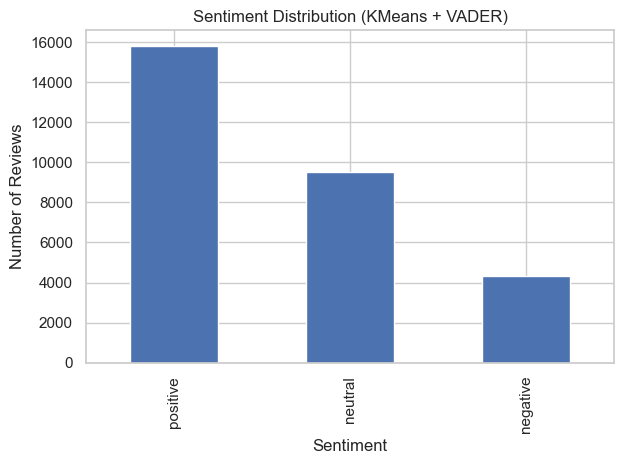

In [117]:
import matplotlib.pyplot as plt

df["sentiment"].value_counts().plot(kind="bar")

plt.title("Sentiment Distribution (KMeans + VADER)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()


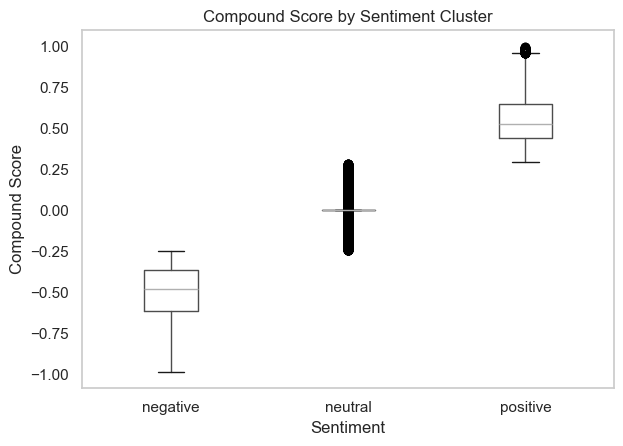

In [118]:
df.boxplot(column="compound", by="sentiment", grid=False)

plt.title("Compound Score by Sentiment Cluster")
plt.suptitle("")
plt.xlabel("Sentiment")
plt.ylabel("Compound Score")
plt.tight_layout()
plt.show()


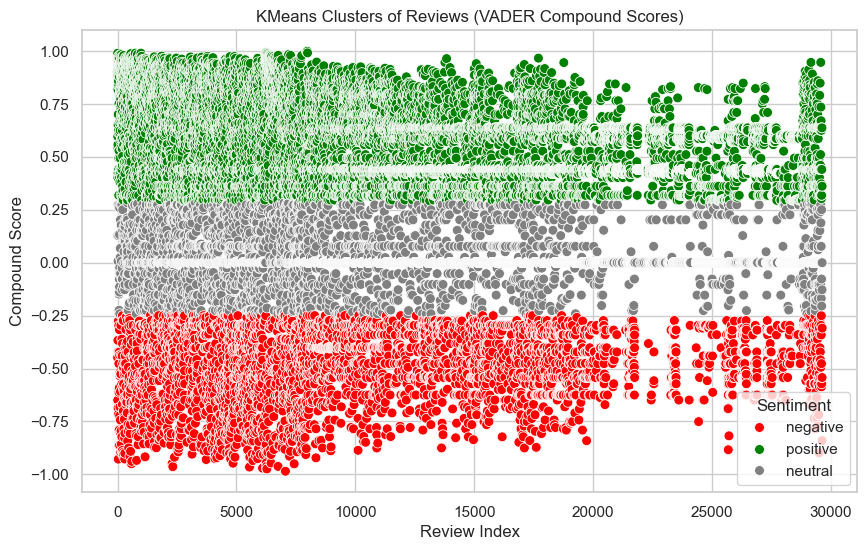

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Plot the clusters along the compound score
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=range(len(df)), 
    y="compound", 
    hue="sentiment", 
    palette={"negative":"red", "neutral":"gray", "positive":"green"},
    data=df,
    s=50
)
plt.title("KMeans Clusters of Reviews (VADER Compound Scores)")
plt.xlabel("Review Index")
plt.ylabel("Compound Score")
plt.legend(title="Sentiment")
plt.show()


The KNN clustering makes a custom threshold for us without us needing to have a hard coded threshold for different sentiments.The reviews seem to be perfectly clustered with respect to their respective scores.

Top words in negative cluster: [('not', 1043), ('twitter', 875), ('no', 863), ('instagram', 826), ('bad', 486), ('post', 452), ('people', 363), ('worst', 325), ('like', 323), ('see', 321)]
Top words in positive cluster: [('good', 3850), ('twitter', 3220), ('like', 2429), ('nice', 2177), ('instagram', 1673), ('better', 1599), ('great', 1178), ('not', 1133), ('best', 985), ('love', 930)]
Top words in neutral cluster: [('twitter', 1711), ('not', 1216), ('instagram', 1145), ('copy', 503), ('post', 456), ('need', 414), ('see', 390), ('use', 379), ('no', 374), ('follow', 350)]


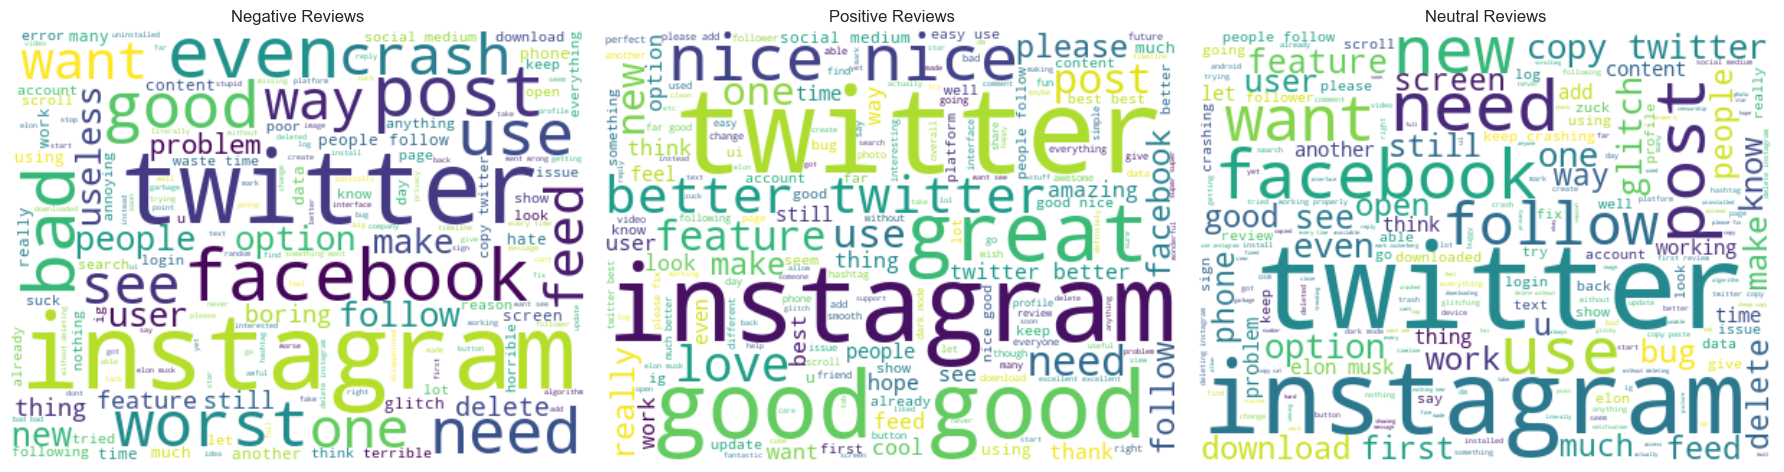

In [120]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Define a function to get top words
def get_top_words(text_series, n=10):
    words = " ".join(text_series).split()
    counter = Counter(words)
    return counter.most_common(n)

# Plot word clouds for each sentiment cluster
sentiments = df["sentiment"].unique()
plt.figure(figsize=(18,6))

for i, sentiment in enumerate(sentiments, 1):
    text = df[df["sentiment"] == sentiment]["review_cleaned"]
    
    # Generate word cloud
    wordcloud = WordCloud(width=400, height=300, background_color="white").generate(" ".join(text))
    
    # Plot
    plt.subplot(1, len(sentiments), i)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"{sentiment.capitalize()} Reviews")
    
    # Print top 10 words in console
    print(f"Top words in {sentiment} cluster:", get_top_words(text))

plt.tight_layout()
plt.show()

threads_pos = df[df["sentiment"] == "positive"]
threads_neu = df[df["sentiment"] == "neutral"]
threads_neg = df[df["sentiment"] == "negative"]


In [121]:
- The negative word cloud shows frustrations about posting, missing features, and comparisons where Threads feels worse than Twitter/Instagram.
- The positive word cloud highlights enthusiasm, with words like good, nice, great, and love showing strong early satisfaction.
- The neutral word cloud reflects general observations about usage: copying, posting, following, and feature needs without strong sentiment.

SyntaxError: invalid syntax (3601449019.py, line 1)

In [122]:
# Stabdardize manual labelling

# Make a copy
df_threads = df.copy()

# Clean label mapping
label_mapping = {
    'negative': 'negative',
    'positive': 'positive',
    'neutral': 'neutral',
    'Negative': 'negative',
    'Positive': 'positive',
    'Neutral': 'neutral',
}

# Create cleaned labels column
df_threads["sentiment_true_clean"] = df_threads["sentiment_true"].map(label_mapping)

# Check unmapped labels
unmapped = df_threads[df_threads["sentiment_true_clean"].isna()]["sentiment_true"].unique()
print("Unmapped labels:", unmapped)

print(df_threads["sentiment_true_clean"].value_counts())


Unmapped labels: [nan 'negatie' 'positive ' 'negtaive' 'neutral ' 'negative ']
sentiment_true_clean
neutral     1398
positive     867
negative     782
Name: count, dtype: int64


In [123]:
# Use only manually labeled rows
df_gold = df_threads[df_threads["sentiment_true_clean"].notna()].copy()

# Train/test split on labeled subset
train_df, test_df = train_test_split(
    df_gold,
    test_size=0.2,
    random_state=42,
    stratify=df_gold["sentiment_true_clean"]
)

print("Train distribution:\n", train_df["sentiment_true_clean"].value_counts())
print("Test distribution:\n", test_df["sentiment_true_clean"].value_counts())


Train distribution:
 sentiment_true_clean
neutral     1118
positive     693
negative     626
Name: count, dtype: int64
Test distribution:
 sentiment_true_clean
neutral     280
positive    174
negative    156
Name: count, dtype: int64


THREADS — VADER SENTIMENT RELIABILITY CHECK

Total manually labeled samples: 3047

Distribution of manual labels:
sentiment_true_clean
neutral     1398
positive     867
negative     782
Name: count, dtype: int64

Distribution of VADER predictions:
sentiment
positive    1582
neutral      893
negative     572
Name: count, dtype: int64

OVERALL METRICS:
Accuracy:          0.5445 (54.45%)
Precision (Macro): 0.5533
Recall (Macro):    0.5710
F1-Score (Macro):  0.5299

DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    negative     0.5402    0.3951    0.4564       782
     neutral     0.6114    0.3906    0.4766      1398
    positive     0.5082    0.9273    0.6566       867

    accuracy                         0.5445      3047
   macro avg     0.5533    0.5710    0.5299      3047
weighted avg     0.5638    0.5445    0.5227      3047



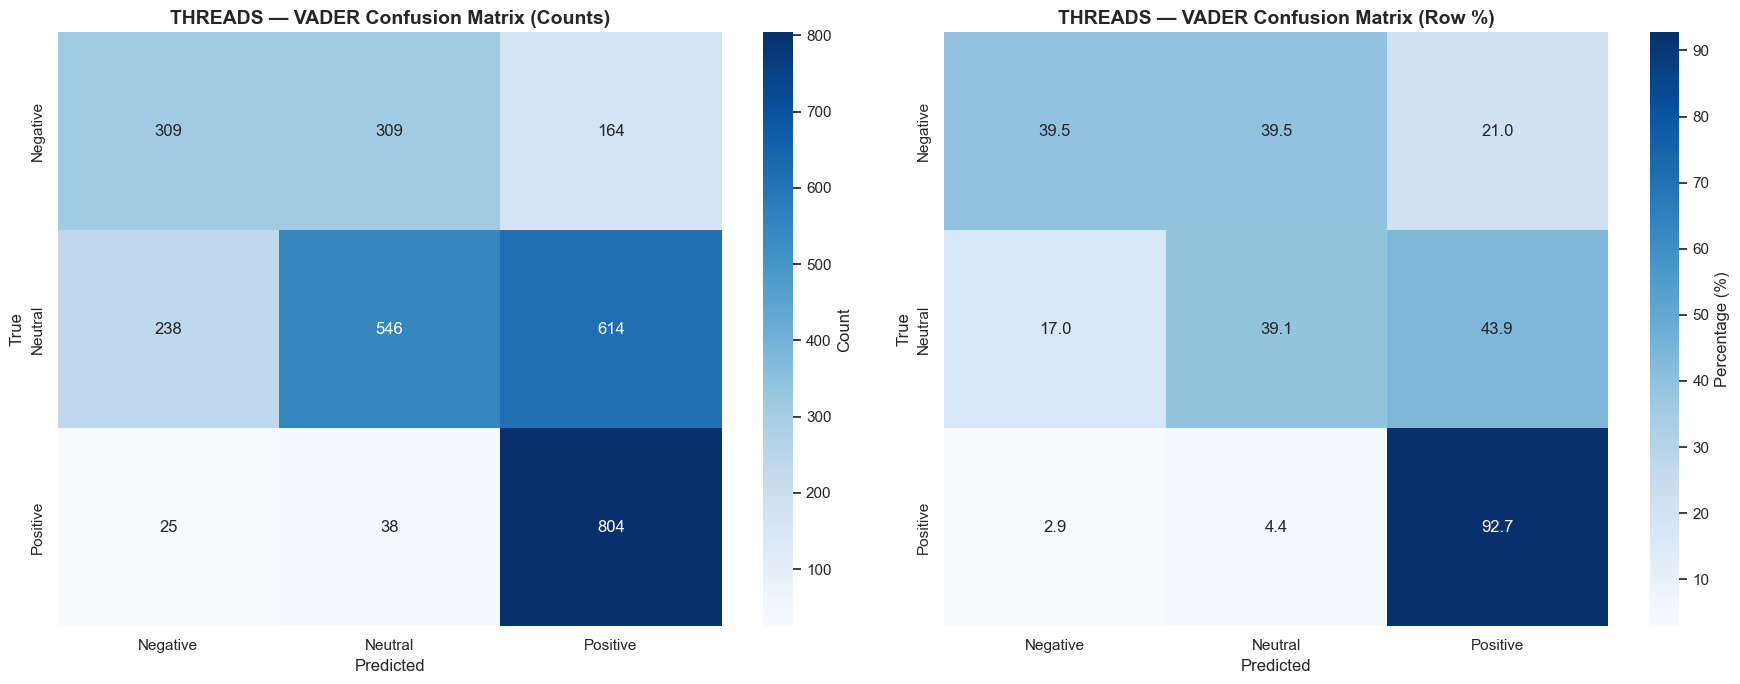

In [131]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# ============================================
# VADER RELIABILITY CHECK WITH CLEAN LABELS (THREADS)
# ============================================
print("THREADS — VADER SENTIMENT RELIABILITY CHECK")

# Filter only manually labeled rows
df_labeled = df_threads[df_threads['sentiment_true_clean'].notna()].copy()

print(f"\nTotal manually labeled samples: {len(df_labeled)}")
print("\nDistribution of manual labels:")
print(df_labeled['sentiment_true_clean'].value_counts())

print("\nDistribution of VADER predictions:")
print(df_labeled['sentiment'].value_counts())

# Calculate metrics
y_true = df_labeled['sentiment_true_clean']
y_pred = df_labeled['sentiment']

# Overall metrics
accuracy = accuracy_score(y_true, y_pred)
precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)

print("\nOVERALL METRICS:")
print(f"Accuracy:          {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro):    {recall_macro:.4f}")
print(f"F1-Score (Macro):  {f1_macro:.4f}")

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=['negative', 'neutral', 'positive'])

# Row % matrix
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# =============================
# PLOT CONFUSION MATRICES
# =============================
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# COUNTS PLOT
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'],
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('THREADS — VADER Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('True', fontsize=12)

# PERCENTAGES PLOT
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'],
            ax=axes[1], cbar_kws={'label': 'Percentage (%)'})
axes[1].set_title('THREADS — VADER Confusion Matrix (Row %)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('True', fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
## Sentiment Classification: TF-IDF + Logistic regression

In [132]:
# Use the full dataset with VADER+KMeans sentiment
df_vader = df_threads.copy()

# Only keep rows where VADER assigned a label (it should be all)
df_vader = df_vader[df_vader["sentiment"].notna()]

print(df_vader["sentiment"].value_counts())


sentiment
positive    15800
neutral      9525
negative     4321
Name: count, dtype: int64


In [136]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    min_df=3,
    stop_words="english"
)

X_train = tfidf.fit_transform(train_df["review_cleaned"])
X_test = tfidf.transform(test_df["review_cleaned"])

y_train = train_df["sentiment"]
y_test = test_df["sentiment"]


In [137]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    n_jobs=-1
)

model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=2000, n_jobs=-1)

In [138]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Accuracy: 0.8298482293423272

Classification Report:
              precision    recall  f1-score   support

    negative     0.6250    0.7234    0.6706       864
     neutral     0.7698    0.8462    0.8062      1905
    positive     0.9464    0.8491    0.8951      3161

    accuracy                         0.8298      5930
   macro avg     0.7804    0.8062    0.7906      5930
weighted avg     0.8428    0.8298    0.8338      5930



In [138]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Accuracy: 0.8298482293423272

Classification Report:
              precision    recall  f1-score   support

    negative     0.6250    0.7234    0.6706       864
     neutral     0.7698    0.8462    0.8062      1905
    positive     0.9464    0.8491    0.8951      3161

    accuracy                         0.8298      5930
   macro avg     0.7804    0.8062    0.7906      5930
weighted avg     0.8428    0.8298    0.8338      5930



## SENTIMENT ANALYSIS : USING VADER + KNN FOR TWITTER

By applying KMeans clustering to the compound sentiment scores, we could segment reviews into three clusters. The centroids of these clusters inform the thresholds for classifying sentiment, allowing for more objective labeling than manual cutoff values.

In [28]:

# ----------- LOAD DATA --------------
df = twitter_clean.copy()     
# ------------------------------------


# ---------- VADER SCORES -----------
analyzer = SentimentIntensityAnalyzer()
df["compound"] = df["review_cleaned"].apply(lambda x: analyzer.polarity_scores(x)["compound"])
compound_array = df["compound"].values.reshape(-1,1)
# ------------------------------------

# ----------- KMEANS 3 CLUSTERS -----
kmeans = KMeans(n_clusters=3, random_state=42, n_init=20)
clusters = kmeans.fit_predict(compound_array)
df["cluster"] = clusters

# map centroids -> pos/neu/neg
centroids = kmeans.cluster_centers_.flatten()
order = np.argsort(centroids)
label_map = {order[0]: "negative", order[1]: "neutral", order[2]: "positive"}

df["sentiment"] = df["cluster"].map(label_map)
# ------------------------------------

print(df[["review_text","review_cleaned","compound","sentiment"]].head())


                                         review_text  \
0  A cesspool of bigotry, rascism, homophobia, tr...   
1  It is good to see there are a lot of people th...   
2  I am removing this app because I abuse Manoj M...   
3  Twitter is nice but my account often got locke...   
4  It's better actually. Just improve the video w...   

                                      review_cleaned  compound sentiment  
0  cesspool bigotry rascism homophobia transphobi...   -0.5859  negative  
1  good see lot people believe thing government d...    0.5106  positive  
2  removing abuse manoj muntasir tweet happened p...    0.8885  positive  
3  nice often got locked lot violation even know ...   -0.0772   neutral  
4  better actually improve video watching experie...    0.7003  positive  


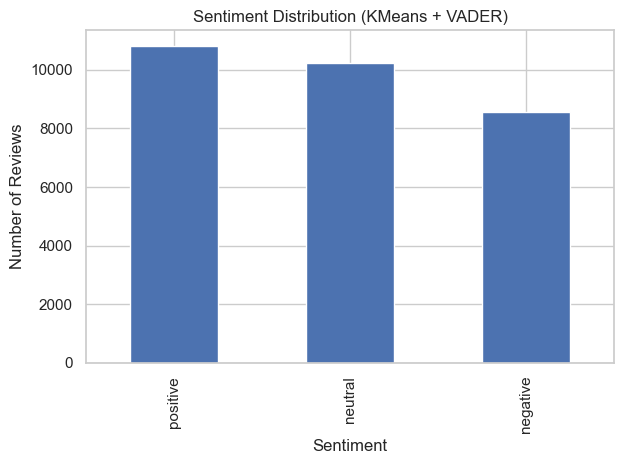

In [29]:
import matplotlib.pyplot as plt

df["sentiment"].value_counts().plot(kind="bar")

plt.title("Sentiment Distribution (KMeans + VADER)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()


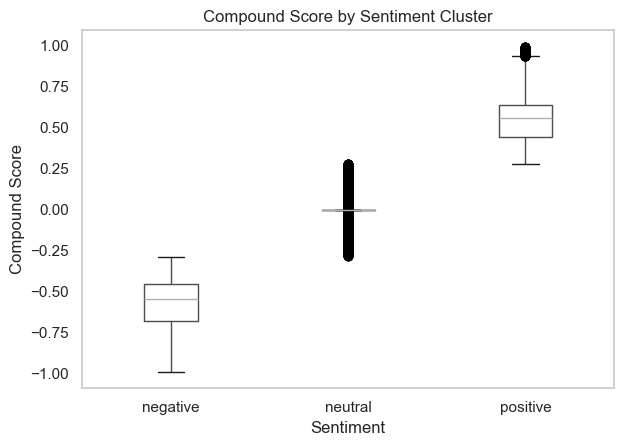

In [30]:
df.boxplot(column="compound", by="sentiment", grid=False)

plt.title("Compound Score by Sentiment Cluster")
plt.suptitle("")
plt.xlabel("Sentiment")
plt.ylabel("Compound Score")
plt.tight_layout()
plt.show()


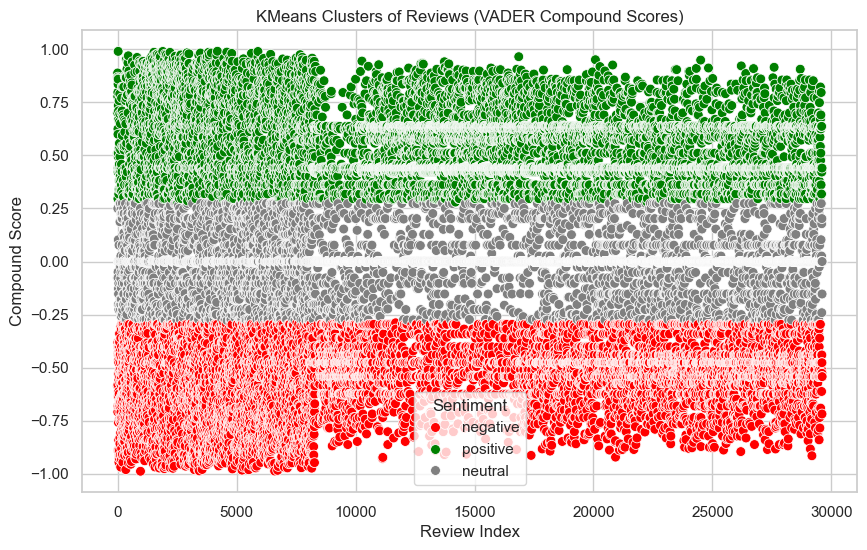

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Plot the clusters along the compound score
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=range(len(df)), 
    y="compound", 
    hue="sentiment", 
    palette={"negative":"red", "neutral":"gray", "positive":"green"},
    data=df,
    s=50
)
plt.title("KMeans Clusters of Reviews (VADER Compound Scores)")
plt.xlabel("Review Index")
plt.ylabel("Compound Score")
plt.legend(title="Sentiment")
plt.show()




Top words in negative cluster: [('elon', 1477), ('not', 1175), ('no', 963), ('worse', 870), ('bad', 865), ('new', 753), ('musk', 752), ('tweet', 746), ('ruined', 695), ('worst', 604)]
Top words in positive cluster: [('good', 2173), ('like', 1213), ('elon', 1103), ('best', 1043), ('great', 1015), ('better', 986), ('not', 800), ('love', 781), ('nice', 738), ('social', 563)]
Top words in neutral cluster: [('elon', 1305), ('not', 1147), ('tweet', 667), ('back', 654), ('musk', 644), ('change', 568), ('like', 464), ('new', 447), ('name', 440), ('bird', 416)]


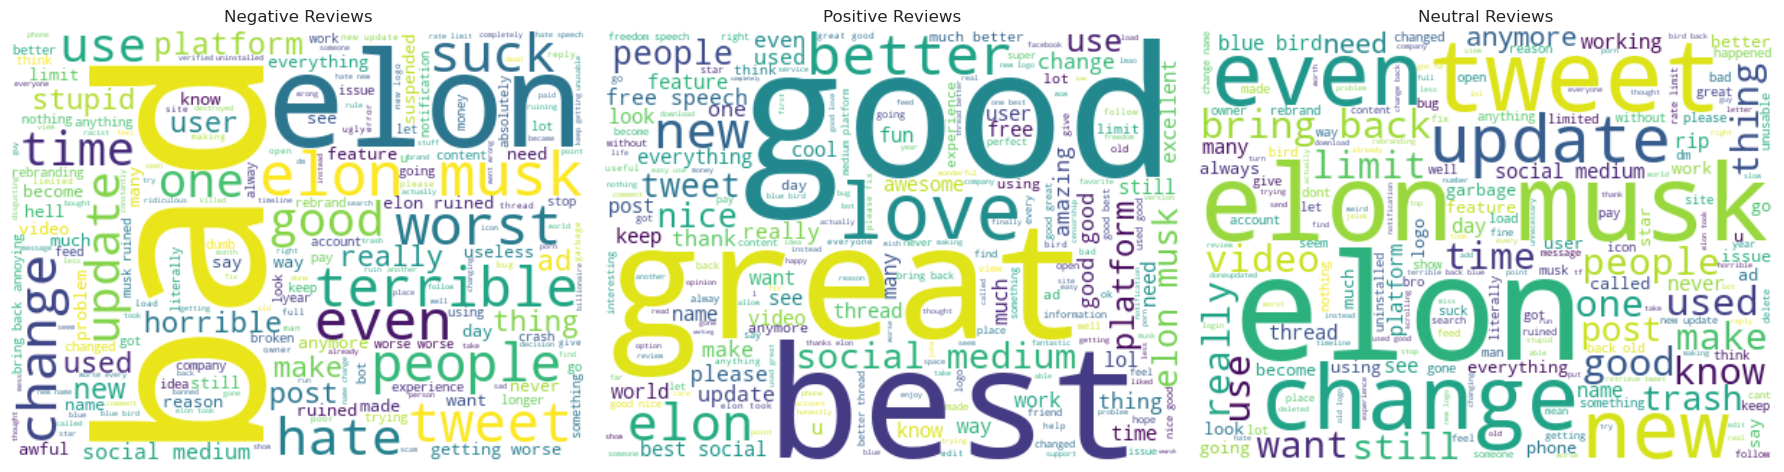

In [58]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Define a function to get top words
def get_top_words(text_series, n=10):
    words = " ".join(text_series).split()
    counter = Counter(words)
    return counter.most_common(n)

# Plot word clouds for each sentiment cluster
sentiments = df["sentiment"].unique()
plt.figure(figsize=(18,6))

for i, sentiment in enumerate(sentiments, 1):
    text = df[df["sentiment"] == sentiment]["review_cleaned"]
    
    # Generate word cloud
    wordcloud = WordCloud(width=400, height=300, background_color="white").generate(" ".join(text))
    
    # Plot
    plt.subplot(1, len(sentiments), i)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"{sentiment.capitalize()} Reviews")
    
    # Print top 10 words in console
    print(f"Top words in {sentiment} cluster:", get_top_words(text))

plt.tight_layout()
plt.show()


- The negative word cloud shows frustration with Elon/Musk, worsening updates, and strong complaints about the platform becoming “bad,” “worse,” and “ruined.”
- The positive word cloud highlights appreciation for certain features and updates, with users expressing satisfaction through words like good, great, best, and love.
- The neutral word cloud reflects general discussion around Elon/Musk, tweets, changes, and platform updates without strong emotional tone.

In [32]:
df_twitter = df.copy()

from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df_twitter, 
    test_size=0.2, 
    random_state=42,
    stratify=df_twitter['sentiment'] 
)
twitter_pos = df[df["sentiment"] == "positive"]
twitter_neu = df[df["sentiment"] == "neutral"]
twitter_neg = df[df["sentiment"] == "negative"]


twitter_pos_train = train_df[train_df["sentiment"] == "positive"]
twitter_neu_train = train_df[train_df["sentiment"] == "neutral"]
twitter_neg_train = train_df[train_df["sentiment"] == "negative"]

twitter_pos_test = test_df[test_df["sentiment"] == "positive"]
twitter_neu_test = test_df[test_df["sentiment"] == "neutral"]
twitter_neg_test = test_df[test_df["sentiment"] == "negative"]


### Correlation between Rating and VADER sentiment for Twitter

In [60]:
# ============================================
# 4. CORRELATION ANALYSIS
# ============================================
print("CORRELATION ANALYSIS")

# Pearson correlation between rating and compound score
from scipy.stats import pearsonr, spearmanr

correlation_pearson, p_value_pearson = pearsonr(df_threads['review_rating'], df_threads['compound'])
correlation_spearman, p_value_spearman = spearmanr(df_threads['review_rating'], df_threads['compound'])

print(f"\nPearson Correlation (Rating vs Compound):  {correlation_pearson:.4f} (p-value: {p_value_pearson:.4e})")
print(f"Spearman Correlation (Rating vs Compound): {correlation_spearman:.4f} (p-value: {p_value_spearman:.4e})")

# Scatter plot with trend line
plt.figure(figsize=(10, 6))
plt.scatter(df_threads['review_rating'], df_threads['compound'], alpha=0.5, s=30)
z = np.polyfit(df_threads['review_rating'], df_threads['compound'], 1)
p = np.poly1d(z)
plt.plot(df_threads['review_rating'].unique(), p(df_threads['review_rating'].unique()), "r--", linewidth=2, label=f'Trend line (r={correlation_pearson:.3f})')
plt.xlabel('Rating', fontsize=12)
plt.ylabel('VADER Compound Score', fontsize=12)
plt.title('Rating vs VADER Compound Score\nWith Correlation Trend', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



CORRELATION ANALYSIS


'\n# Pearson correlation between rating and compound score\nfrom scipy.stats import pearsonr, spearmanr\n\ncorrelation_pearson, p_value_pearson = pearsonr(df_comparison[\'review_rating\'], df_comparison[\'compound\'])\ncorrelation_spearman, p_value_spearman = spearmanr(df_comparison[\'review_rating\'], df_comparison[\'compound\'])\n\nprint(f"\nPearson Correlation (Rating vs Compound):  {correlation_pearson:.4f} (p-value: {p_value_pearson:.4e})")\nprint(f"Spearman Correlation (Rating vs Compound): {correlation_spearman:.4f} (p-value: {p_value_spearman:.4e})")\n\n# Scatter plot with trend line\nplt.figure(figsize=(10, 6))\nplt.scatter(df_comparison[\'review_rating\'], df_comparison[\'compound\'], alpha=0.5, s=30)\nz = np.polyfit(df_comparison[\'review_rating\'], df_comparison[\'compound\'], 1)\np = np.poly1d(z)\nplt.plot(df_comparison[\'review_rating\'].unique(), p(df_comparison[\'review_rating\'].unique()), "r--", linewidth=2, label=f\'Trend line (r={correlation_pearson:.3f})\')\nplt.xl

### Checking Reliability of VADER labelling

In [61]:
print(df_twitter['sentiment_true'].value_counts())


sentiment_true
Negative    1783
Positive     855
Neutral      170
ngea           6
negative       5
Nge            3
neag           3
neha           2
nga            1
Negaive        1
NGEA           1
[ps            1
N              1
bega           1
pnega          1
spos           1
Name: count, dtype: int64


In [62]:
# ============================================
# FIX AND STANDARDIZE LABELS
# ============================================
print("\n" + "="*60)
print("CLEANING AND STANDARDIZING LABELS")
print("="*60)

# Create mapping dictionary for typos and variations
label_mapping = {
    # Negative variations
    'Negative': 'negative',
    'ngea': 'negative',
    'negative': 'negative',
    'Nge': 'negative',
    'neag': 'negative',
    'nega': 'negative',
    'Negaive': 'negative',
    'nga': 'negative',
    'NGEA': 'negative',
    'N': 'negative',
    'bega': 'negative',
    'pnega': 'negative',
    'npega': 'negative',
    
    # Positive variations
    'Positive': 'positive',
    'spos': 'positive',
    '[ps': 'positive',
    
    # Neutral variations
    'Neutral': 'neutral',
    'neha': 'neutral'  # Assuming this is a typo for neutral
}

# Apply mapping
df_twitter['sentiment_true_clean'] = df_twitter['sentiment_true'].map(label_mapping)

# Check for any unmapped values
unmapped = df_twitter[df_twitter['sentiment_true'].notna() & df_twitter['sentiment_true_clean'].isna()]['sentiment_true'].unique()
if len(unmapped) > 0:
    print(f"\nWARNING: Found unmapped values: {unmapped}")
    print("These will be treated as NaN. Please add them to the mapping if needed.\n")

print("\nAfter cleaning - Value counts for 'sentiment_true_clean':")
print(df_twitter['sentiment_true_clean'].value_counts())

print("\nLabels successfully standardized!")
print(f"  - Total labeled: {df_twitter['sentiment_true_clean'].notna().sum()}")
print(f"  - Negative: {(df_twitter['sentiment_true_clean'] == 'negative').sum()}")
print(f"  - Positive: {(df_twitter['sentiment_true_clean'] == 'positive').sum()}")
print(f"  - Neutral: {(df_twitter['sentiment_true_clean'] == 'neutral').sum()}")




CLEANING AND STANDARDIZING LABELS

After cleaning - Value counts for 'sentiment_true_clean':
sentiment_true_clean
negative    1806
positive     857
neutral      172
Name: count, dtype: int64

Labels successfully standardized!
  - Total labeled: 2835
  - Negative: 1806
  - Positive: 857
  - Neutral: 172


VADER SENTIMENT RELIABILITY CHECK

Total manually labeled samples: 2835

Distribution of manual labels:
sentiment_true_clean
negative    1806
positive     857
neutral      172
Name: count, dtype: int64

Distribution of VADER predictions:
sentiment
positive    1073
negative     909
neutral      853
Name: count, dtype: int64
OVERALL METRICS:
Accuracy:          0.6085 (60.85%)
Precision (Macro): 0.5933
Recall (Macro):    0.6421
F1-Score (Macro):  0.5375
DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    negative     0.9725    0.4895    0.6512      1806
     neutral     0.1149    0.5698    0.1912       172
    positive     0.6925    0.8670    0.7699       857

    accuracy                         0.6085      2835
   macro avg     0.5933    0.6421    0.5375      2835
weighted avg     0.8358    0.6085    0.6592      2835



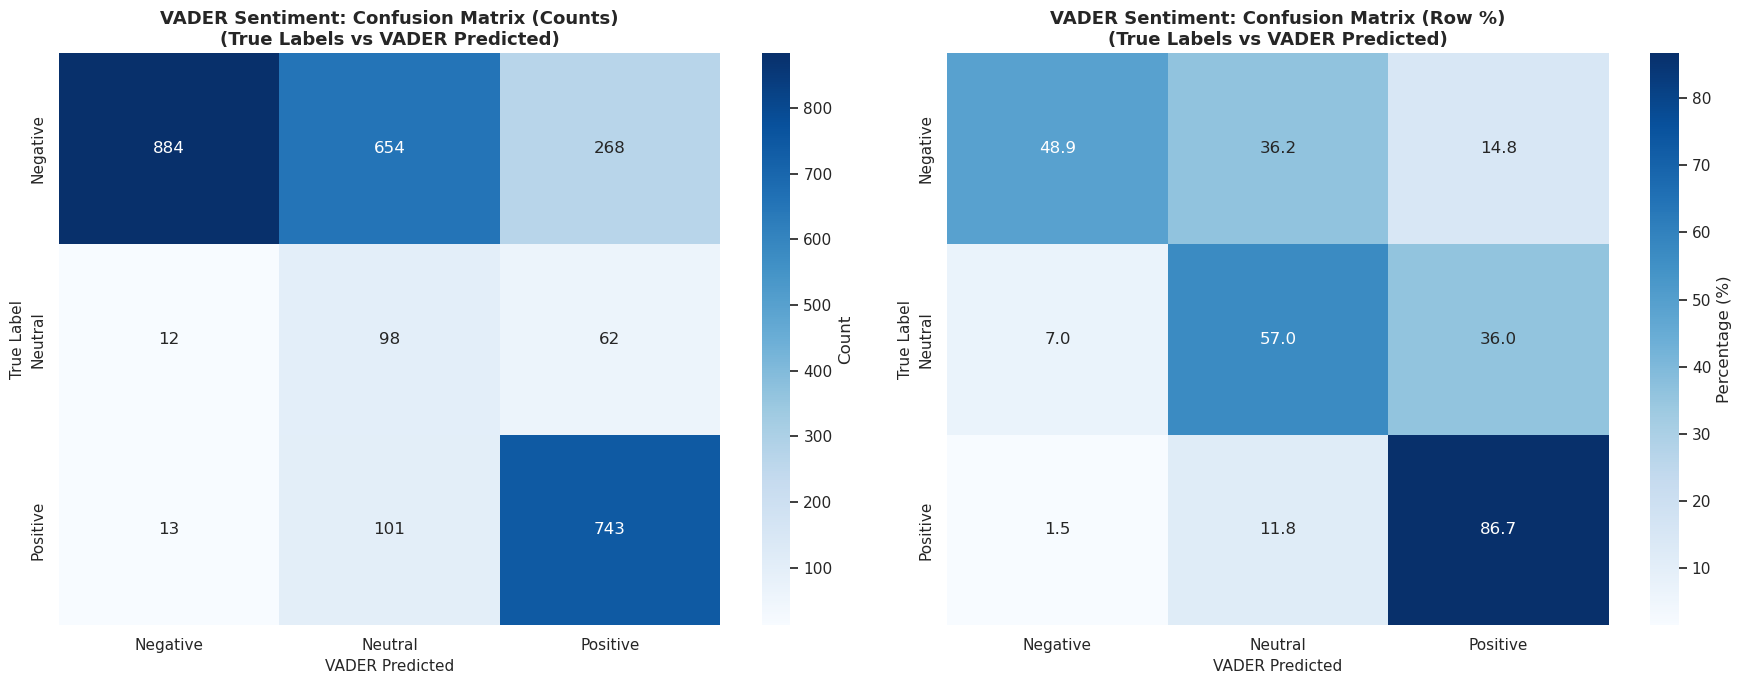

In [63]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# ============================================
# VADER RELIABILITY CHECK WITH CLEAN LABELS
# ============================================
print("VADER SENTIMENT RELIABILITY CHECK")

# Filter non-null sentiment_true values
df_labeled = df_twitter[df_twitter['sentiment_true_clean'].notna()].copy()
print(f"\nTotal manually labeled samples: {len(df_labeled)}")
print(f"\nDistribution of manual labels:")
print(df_labeled['sentiment_true_clean'].value_counts())
print(f"\nDistribution of VADER predictions:")
print(df_labeled['sentiment'].value_counts())

# Calculate metrics
y_true = df_labeled['sentiment_true_clean']
y_pred = df_labeled['sentiment']

# Overall metrics
accuracy = accuracy_score(y_true, y_pred)
precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)

print("OVERALL METRICS:")
print(f"Accuracy:          {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro):    {recall_macro:.4f}")
print(f"F1-Score (Macro):  {f1_macro:.4f}")

print("DETAILED CLASSIFICATION REPORT:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=['negative', 'neutral', 'positive'])

# Calculate percentages for each row
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'],
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('VADER Sentiment: Confusion Matrix (Counts)\n(True Labels vs VADER Predicted)', 
                  fontsize=13, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=11)
axes[0].set_xlabel('VADER Predicted', fontsize=11)

# Percentages
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', 
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'],
            ax=axes[1], cbar_kws={'label': 'Percentage (%)'})
axes[1].set_title('VADER Sentiment: Confusion Matrix (Row %)\n(True Labels vs VADER Predicted)', 
                  fontsize=13, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=11)
axes[1].set_xlabel('VADER Predicted', fontsize=11)

plt.tight_layout()
plt.show()


##### To evaluate the reliability of VADER sentiment classification for our Twitter dataset, we manually labelled a subset of around 3k reviews as a validation set. VADER achieved an overall accuracy of 60.85% with a macro F1-score of 0.54, showing reasonable performance as an unsupervised, lexicon-based baseline for social media sentiment analysis.

##### The model worked very well for for negative sentiment with precision (97.25%), indicating high confidence when classifying negative reviews, though with moderate recall (48.95%). Positive sentiment detection was really accurate as well , with 86.70% recall and an F1-score of 0.77, suggesting VADER effectively captures positive expressions on Twitter data. As expected with rule-based approaches, neutral sentiment proved challenging (F1: 0.19), a common issue when analysing context-dependent langauge in social media. The manual labelling could also be dependent on an individual hence, making it ambiguous for humans as well

##### These results validate VADER as a suitable tool for initial sentiment labeling and could be used for sentiment classification. 


## Data Cleaning Pipeline 2 (for topic modelling) 

In [64]:
# Data Cleaning 2
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser

negations = {"no", "not", "nor", "dont", "can't", "cannot", "never"}
stop_words = stop_words - negations

# App-specific words to remove
custom_stopwords_tm = set([
    "app", "apps", "application", "applications",
    "experience", "account", 
])

# ============================
#  Cleaning Function
# ============================
def clean_text_for_tm(text):
    # text = str(text).lower()
    # text = emoji.replace_emoji(text, replace="")
    # text = re.sub(r"http\S+|www\S+", "", text)
    # text = re.sub(r"[^a-zA-Z\s]", " ", text)  # keep only letters
    
    tokens = simple_preprocess(text, deacc=True)

    # # remove stopwords
    # tokens = [t for t in tokens if t not in stop_words]
    # tokens = [t for t in tokens if t not in custom_stopwords_tm]

    return tokens

# ============================
#  Bigram Builder
# ============================
def create_bigrams(texts):
    bigram = Phrases(texts, min_count=10, threshold=10)
    bigram_mod = Phraser(bigram)
    return [bigram_mod[doc] for doc in texts]

# ============================
# Prepare Dataset for Topic Modeling
# ============================
def prepare_tm_texts(df):
    docs = df["review_cleaned"].apply(clean_text_for_tm).tolist()
    docs_bigrams = create_bigrams(docs)
    return docs_bigrams



## Topic Modelling 1 with sentiment labels (pos, neu, neg)

In [65]:


from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel


def train_lda_model(docs_bigrams, num_topics=5):

    dictionary = Dictionary(docs_bigrams)
    dictionary.filter_extremes(no_below=10, no_above=0.5)

    corpus = [dictionary.doc2bow(doc) for doc in docs_bigrams]

    lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        chunksize=2000,
        passes=10,
        alpha='auto'
    )

    coherence_model = CoherenceModel(
        model=lda_model,
        texts=docs_bigrams,
        dictionary=dictionary,
        coherence='c_v'
    )

    coherence_score = coherence_model.get_coherence()

    return lda_model, corpus, dictionary, coherence_score



def run_lda(docs_df):
    docs_bigrams = prepare_tm_texts(docs_df)

    topic_range = range(3, 7)
    coherence_scores = {}

    for k in topic_range:
        lda_model, corpus, dictionary, coherence = train_lda_model(docs_bigrams, num_topics=k)
        coherence_scores[k] = coherence
        print(f"k={k} Coherence={coherence:.4f}")

    best_k = max(coherence_scores, key=coherence_scores.get)
    print("\nBest number of topics =", best_k)

    final_lda, corpus, dictionary, coherence = train_lda_model(docs_bigrams, num_topics=best_k)

    print("Final Coherence Score:", coherence)

    topics = final_lda.show_topics(num_topics=-1, num_words=15, formatted=False)

    for topic_id, words in topics:
        print(f"TOPIC {topic_id+1}:")
        top_terms = [w for w, weight in words]
        print(", ".join(top_terms))
        print()

    return final_lda    # 


print("\n===== POSITIVE TOPICS =====")
def run_lda_block(df_input):
    print("\n===== RUNNING LDA BLOCK =====")
    return run_lda(df_input)

# print("\n===== THREADS NEUTRAL TOPICS =====")
# lda_neu = run_lda(threads_neu)

# print("\n===== THREADS NEGATIVE TOPICS =====")
# lda_neg = run_lda(threads_neg)



===== POSITIVE TOPICS =====


### Visulaizing the Topics in pos, neu, neg (LDA)

In [66]:
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# Visualization helper
# ---------------------------------------------------------
def plot_lda_topic(words, weights, title):
    plt.figure(figsize=(10, 5))
    plt.barh(words[::-1], weights[::-1], color='royalblue')
    plt.title(title)
    plt.xlabel("Topic Weight")
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------
# Function to visualize topics for a trained LDA model
# ---------------------------------------------------------
def visualize_lda_topics(lda_model, sentiment_label, num_words=12):
    print(f"\n--- VISUALIZING LDA TOPICS: {sentiment_label.upper()} ---")

    topics = lda_model.show_topics(num_topics=-1, num_words=num_words, formatted=False)

    for topic_id, topic in topics:
        words = [w for w, wt in topic]
        weights = [wt for w, wt in topic]

        title = f"{sentiment_label.upper()} - LDA Topic {topic_id+1}"
        plot_lda_topic(words, weights, title)

# ---------------------------------------------------------
# Call this after you finish training lda_pos, lda_neu, lda_neg
# ---------------------------------------------------------

def visualize_lda_block(lda_model, sentiment_label):
    visualize_lda_topics(lda_model, sentiment_label)

# visualize_lda_topics(lda_pos, "Positive")
# visualize_lda_topics(lda_neu, "Neutral")
# visualize_lda_topics(lda_neg, "Negative")





## Threads LDA analysis


===== THREADS POSITIVE TOPICS =====

===== RUNNING LDA BLOCK =====
k=3 Coherence=0.5622
k=4 Coherence=0.5559
k=5 Coherence=0.5334
k=6 Coherence=0.5283

Best number of topics = 3
Final Coherence Score: 0.5621554183779712
TOPIC 1:
great, best, twitter, awesome, cool, excellent, instagram, new, facebook, like, thank, social_medium, use, platform, not_bad

TOPIC 2:
good, nice, twitter, better, love, amazing, super, wow, ok, like, perfect, far, aap, interesting, one

TOPIC 3:
like, instagram, not, post, need, please, see, feature, would, people, option, also, make, follow, add


===== THREADS NEUTRAL TOPICS =====

===== RUNNING LDA BLOCK =====
k=3 Coherence=0.5885
k=4 Coherence=0.5698
k=5 Coherence=0.5859
k=6 Coherence=0.5204

Best number of topics = 3
Final Coherence Score: 0.5885282655348895
TOPIC 1:
twitter, copy, elon_musk, elon, zuck, op, facebook, osm, trash, better, copied, mark, copy_cat, copy_paste, bakwas

TOPIC 2:
instagram, not, use, first, new, glitch, bug, even, delete, one, 

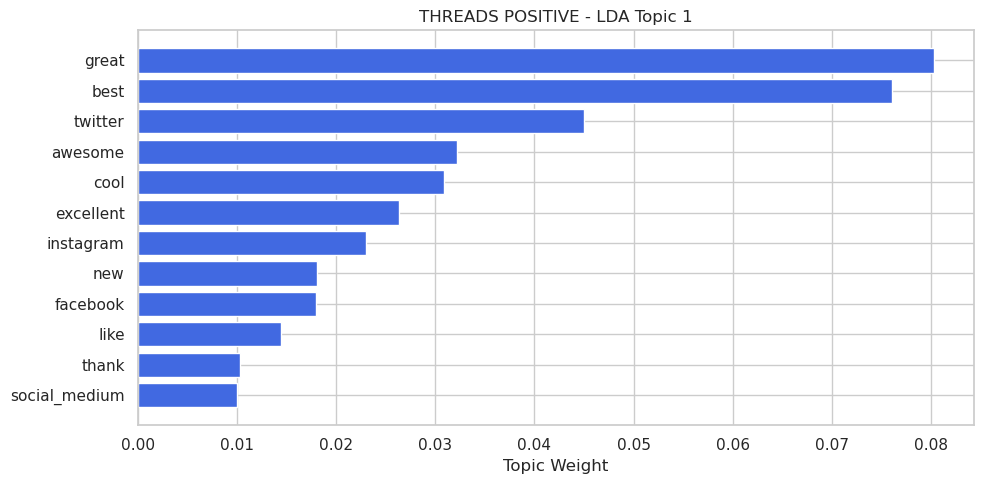

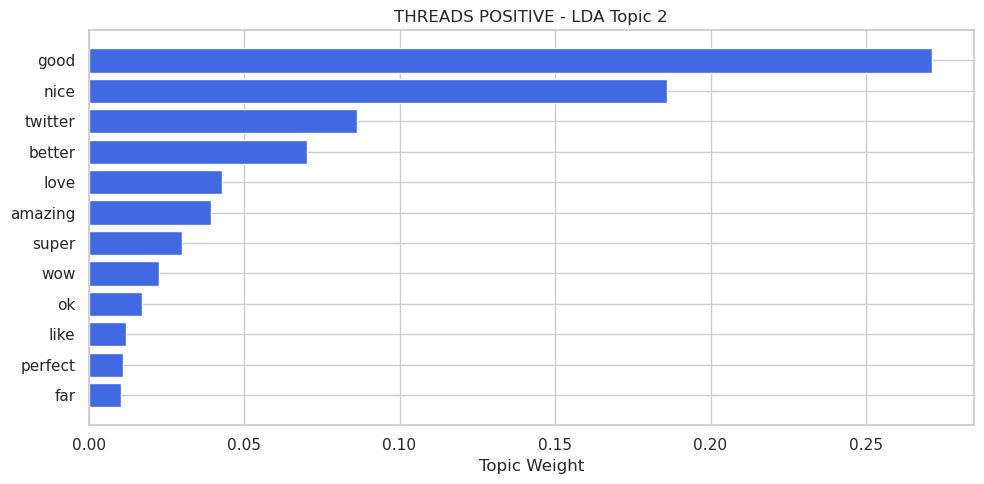

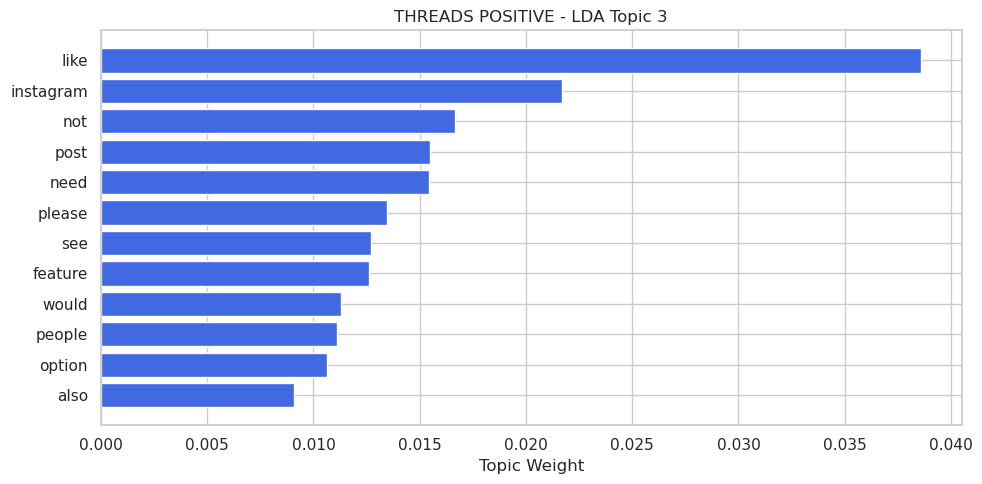


--- VISUALIZING LDA TOPICS: THREADS NEUTRAL ---


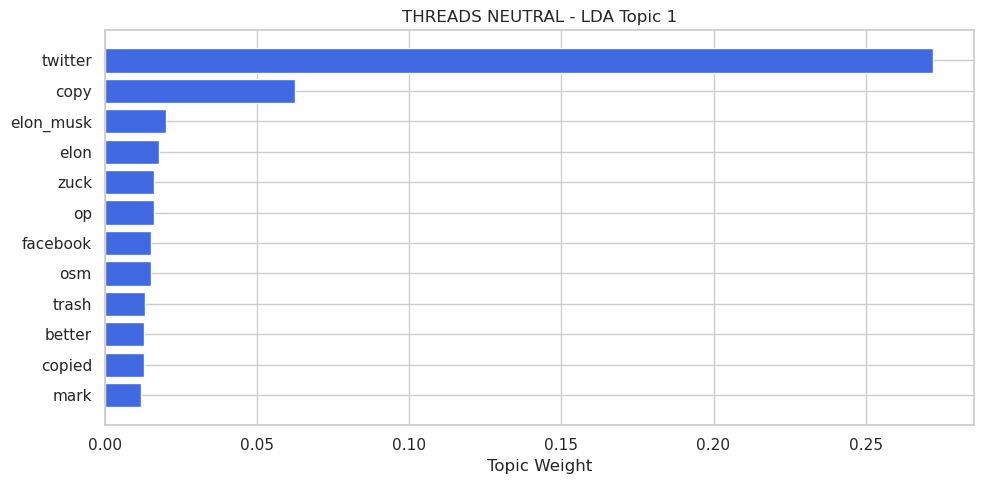

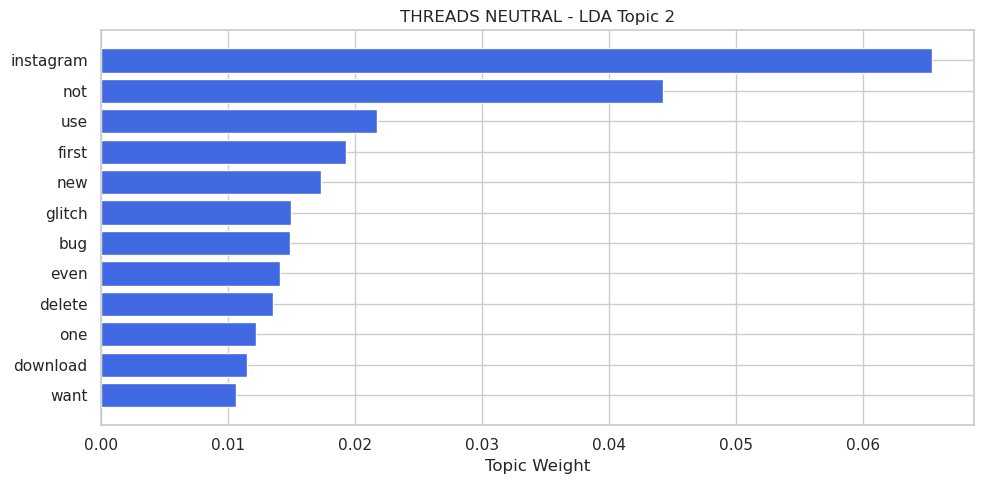

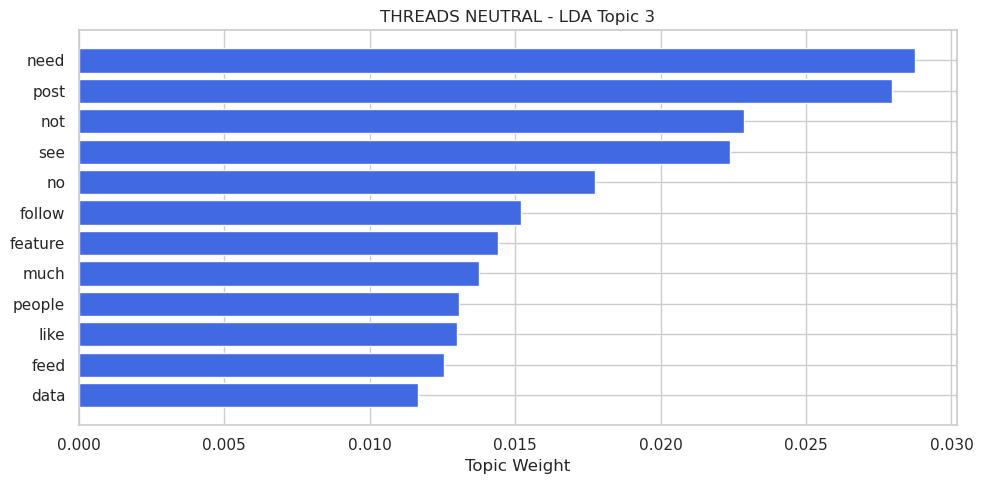


--- VISUALIZING LDA TOPICS: THREADS NEGATIVE ---


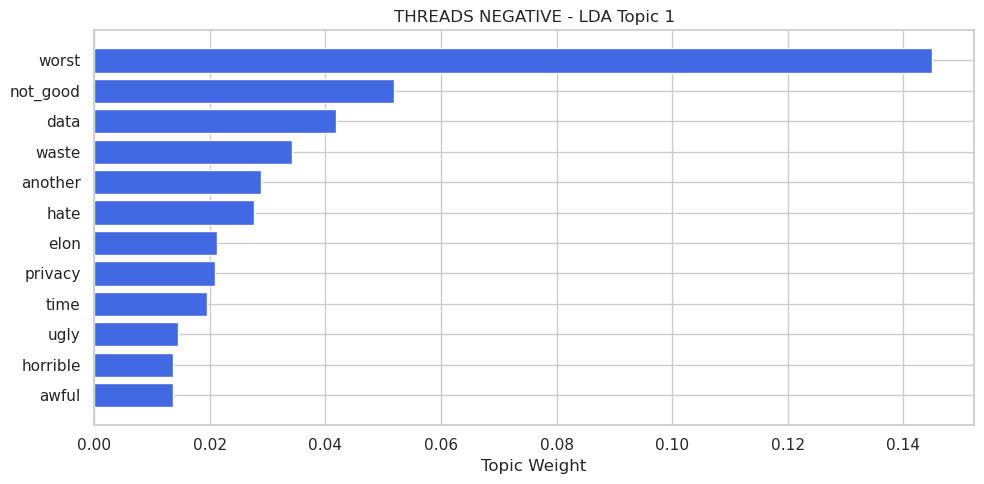

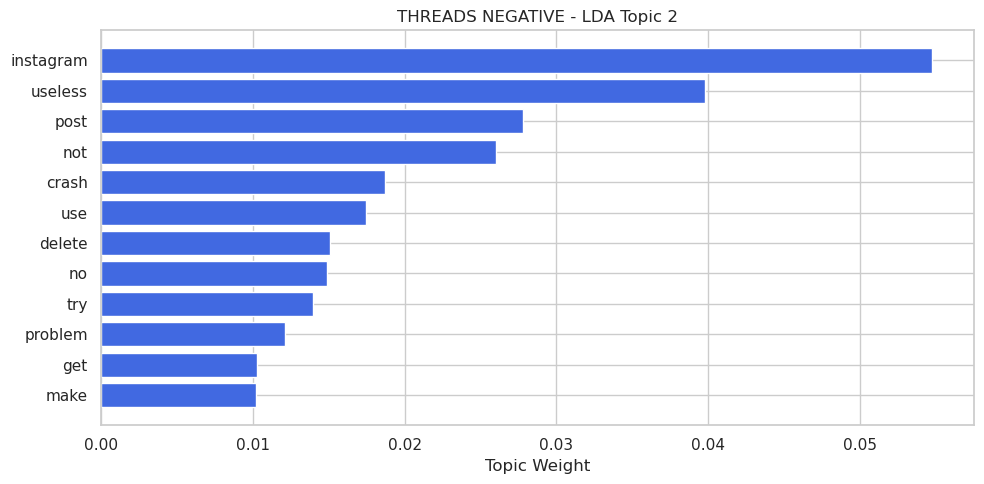

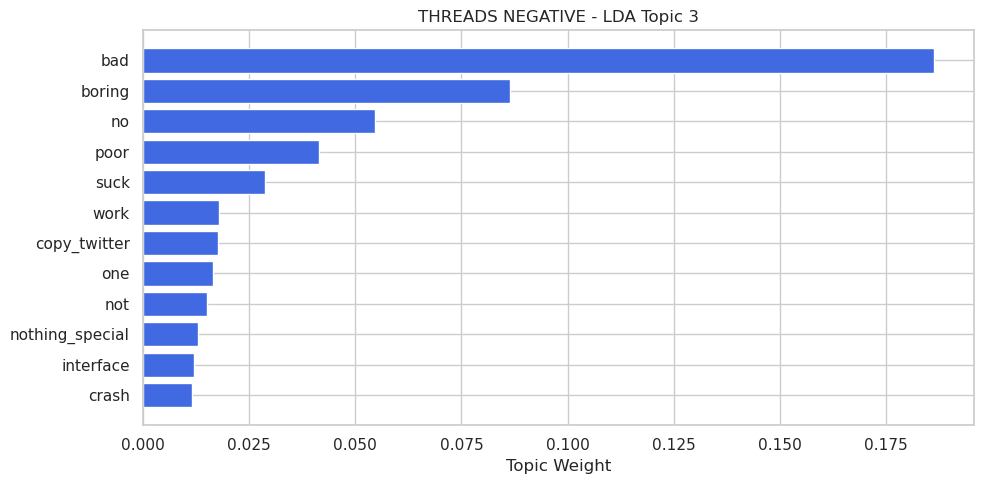

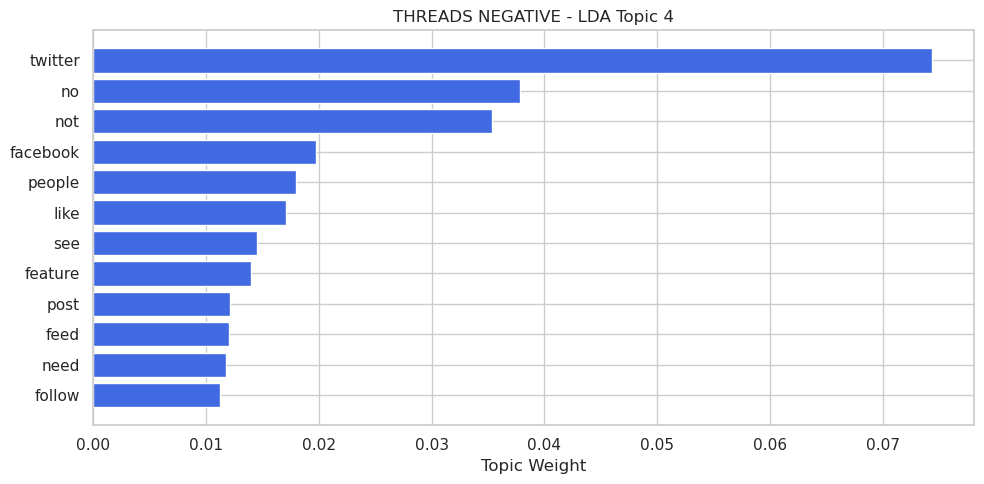

In [67]:


print("\n===== THREADS POSITIVE TOPICS =====")
lda_pos_threads = run_lda_block(threads_pos)
print("\n===== THREADS NEUTRAL TOPICS =====")
lda_neu_threads = run_lda_block(threads_neu)
print("\n===== THREADS NEGATIVE TOPICS =====")
lda_neg_threads = run_lda_block(threads_neg)

visualize_lda_block(lda_pos_threads, "Threads Positive")
visualize_lda_block(lda_neu_threads, "Threads Neutral")
visualize_lda_block(lda_neg_threads, "Threads Negative")


**Overall Summary:**
- Positive reviews: Users express generally positive impressions and note that the app works well, while also offering polite suggestions for additional features.
- Neutral reviews: Comments focus on platform comparisons, technical observations, and practical usage notes without strong emotional tone.
- Negative reviews: Users report dissatisfaction related to crashes, missing features, feed issues, and comparisons where Threads feels weaker than alternatives.

-------

**Positive Sentiment Analysis**
 
Best model: k = 3 topics — Coherence = 0.5622

**1. General Positivity** — *great, best, awesome, cool, excellent*
Users express broadly positive reactions toward the app.

**2. Basic Satisfaction** — *good, nice, better, love, amazing*
Many reviewers indicate they like using Threads and feel it works well.

**3. Polite Feature Requests** — *like, need, please, feature, option*
Even positive users mention improvements they would like to see added.

**Insight:**

Positive reviews reflect overall satisfaction, while still highlighting the need for additional features and refinements.

-------

**Neutral Sentiment Analysis**

Best model: k = 3 topics — Coherence = 0.5885

**1. Platform Comparisons & Commentary** — *twitter, copy, elon_musk, zuck, facebook*
Neutral discussions about the rivalry (Twitter vs Meta), copying debates, and general platform talk.

**2. Practical App Usage Notes** — *instagram, use, first, glitch, bug*
Matter-of-fact comments about using the app, early glitches, installations, or basic usability.

**3. Functional Suggestions** — *need, post, see, follow, feature*
Users provide neutral observations on feed behavior, posting, and missing features without emotional judgment.

**Insight:**
Neutral reviews are dominated by platform comparisons, technical notes, and feature suggestions, providing practical, non-emotional feedback.

-------

**Negative Sentiment Analysis**

Best model: k = 4 topics — Coherence = 0.5233

**1. Harsh Criticism & Rejection** — *worst, hate, horrible, awful, crazy*
Strongly emotional reactions rejecting the platform or complaining about Meta/Elon.

**2. Performance Failures** — *crash, useless, delete, problem, error*
Common frustrations with crashes, errors, and inability to post or use the app reliably.

**3. Low Quality & UX Problems** — *bad, boring, poor, suck, interface*
Complaints about dull design, poor content, or Threads feeling inferior to other platforms.

**4. Feature & Feed Issues** — *twitter, see, feature, feed, follow*
Users upset with missing features, bad feed sorting, and comparisons to Twitter/Instagram where Threads feels worse.

**Insight:**
Negative reviews center on crashes, missing features, feed visibility issues, and comparisons to competitors, showing clear pain-points affecting user retention.


## Twitter LDA analysis


===== TWITTER POSITIVE TOPICS =====

===== RUNNING LDA BLOCK =====
k=3 Coherence=0.4521
k=4 Coherence=0.4267
k=5 Coherence=0.4582
k=6 Coherence=0.4667

Best number of topics = 6
Final Coherence Score: 0.4667061501758924
TOPIC 1:
best, love, amazing, elon, cool, new, better_thread, elon_musk, version, thanks, look_like, support, world, favorite, make

TOPIC 2:
great, nice, better, thread, much_better, experience, facebook, perfect, freedom_speech, far, way, since_elon, elon, place, took

TOPIC 3:
not, awesome, new, make, user, video, tweet, day, time, thing, want, feature, people, getting, also

TOPIC 4:
tweet, even, people, not, fun, use, news, get, information, super, like, going, find, see, time

TOPIC 5:
platform, free_speech, social_medium, best_social, medium, lol, ever, bird, one, elon, no, work, people, elon_musk, freedom

TOPIC 6:
good, like, name, change, used, logo, excellent, please, really, back, not, old, give, ok, changed


===== TWITTER NEUTRAL TOPICS =====

===== RUNNI

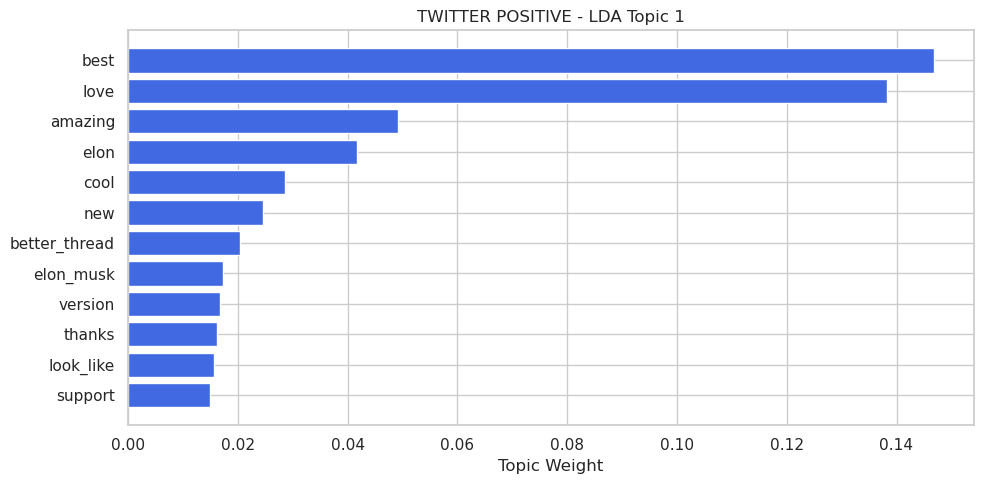

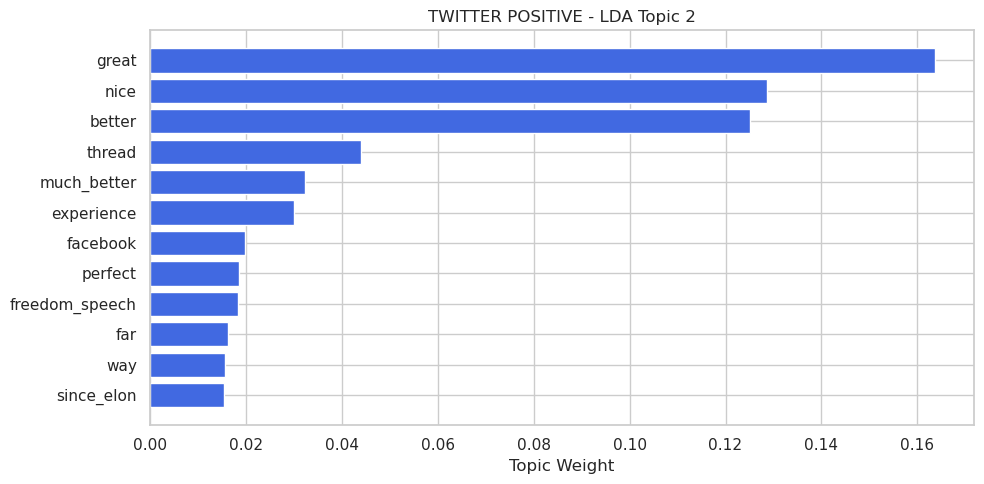

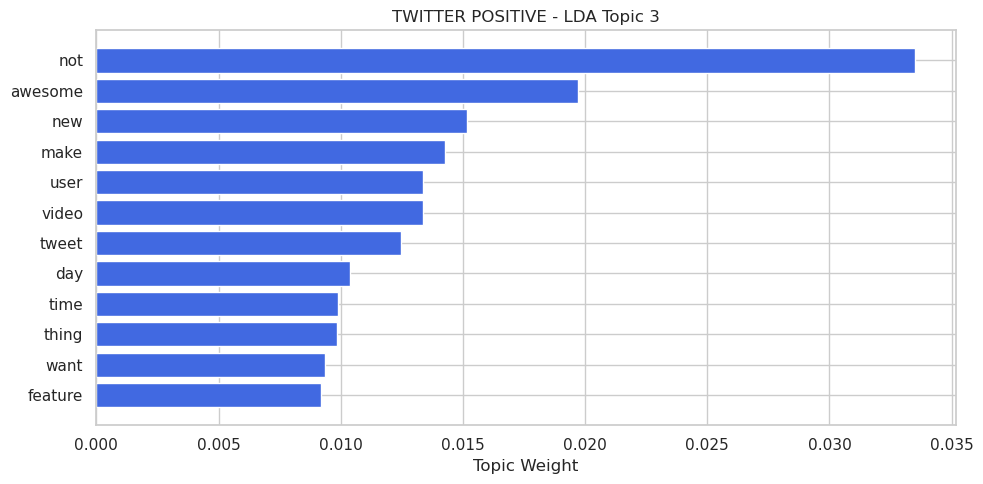

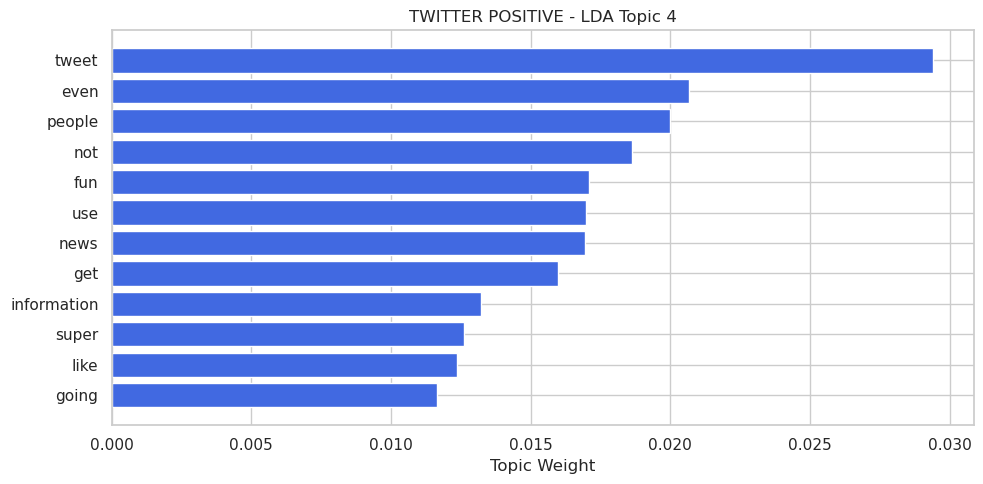

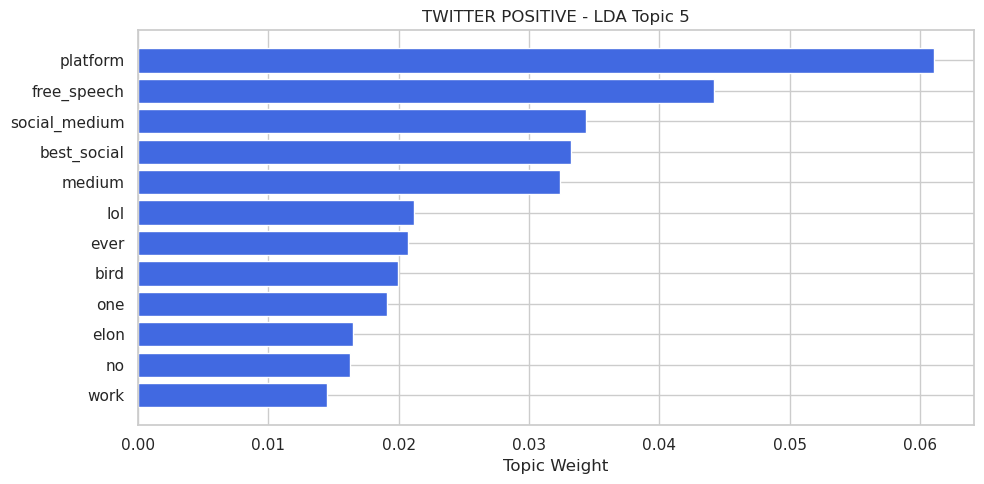

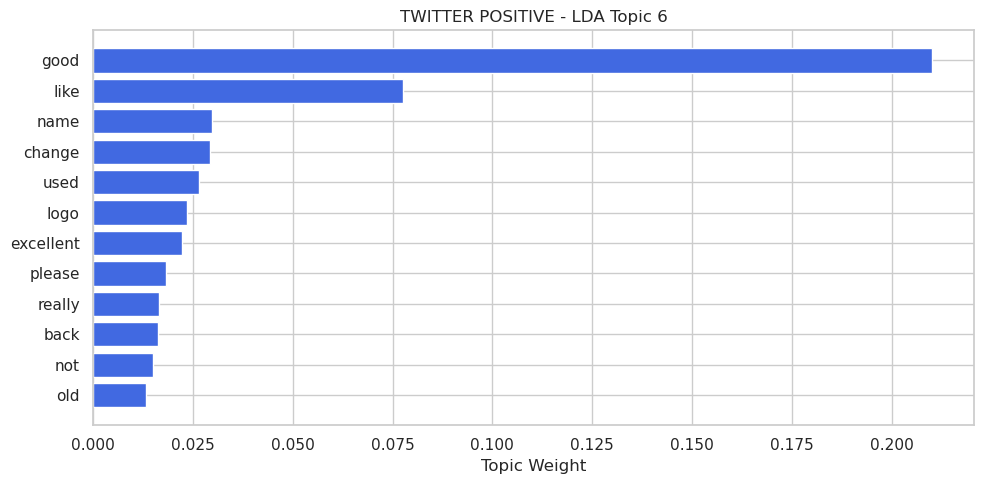


--- VISUALIZING LDA TOPICS: TWITTER NEUTRAL ---


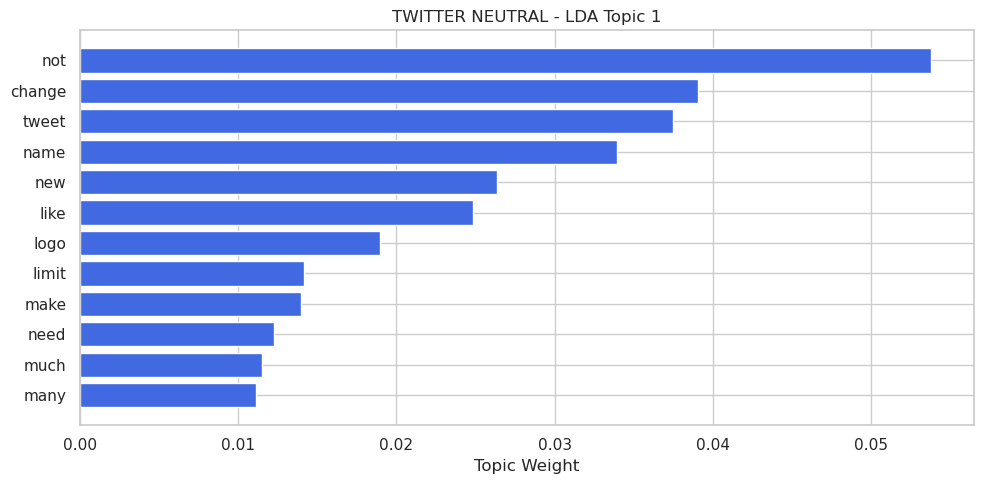

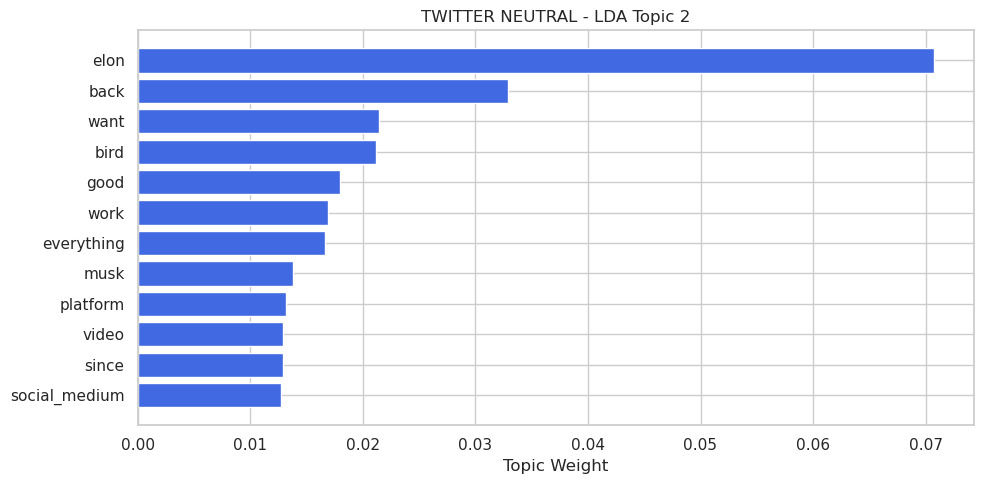

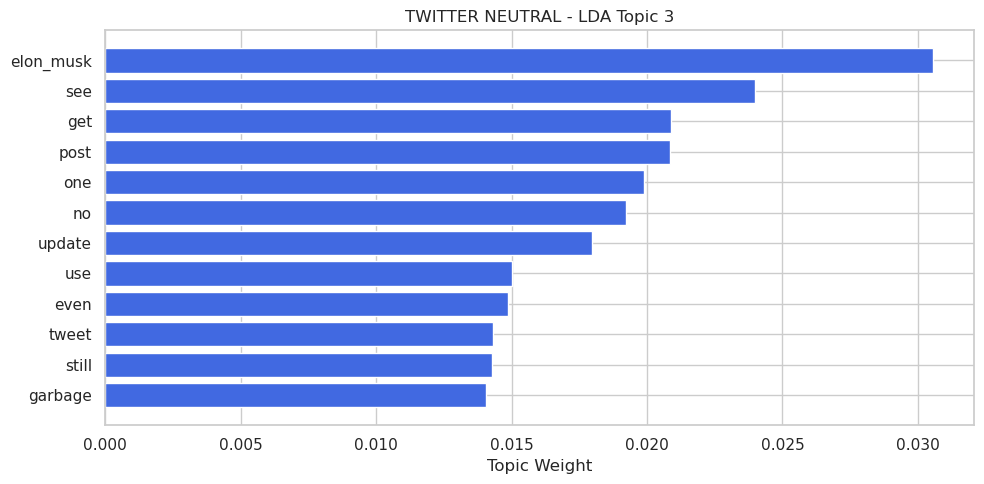


--- VISUALIZING LDA TOPICS: TWITTER NEGATIVE ---


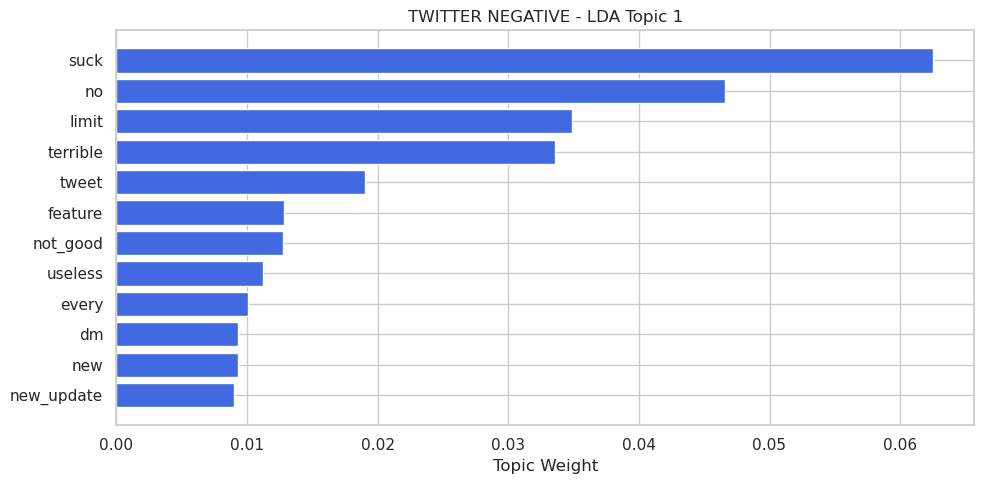

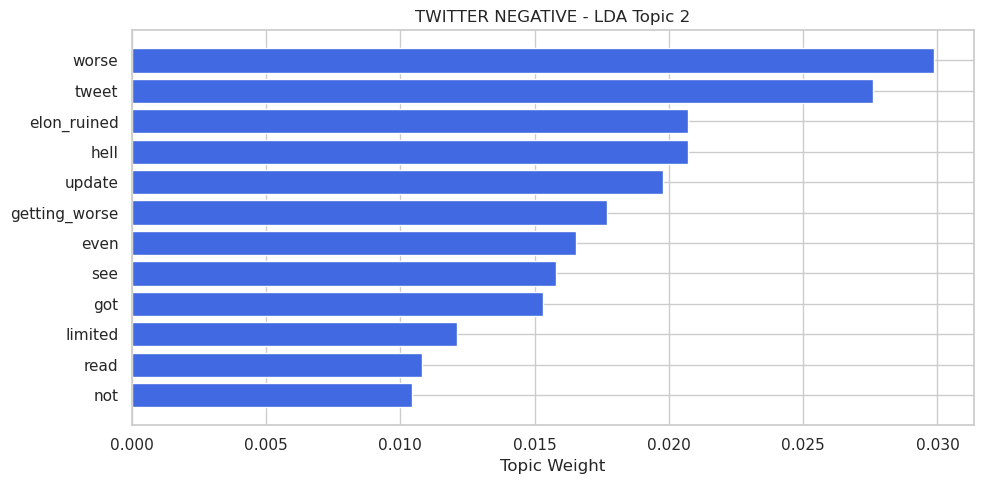

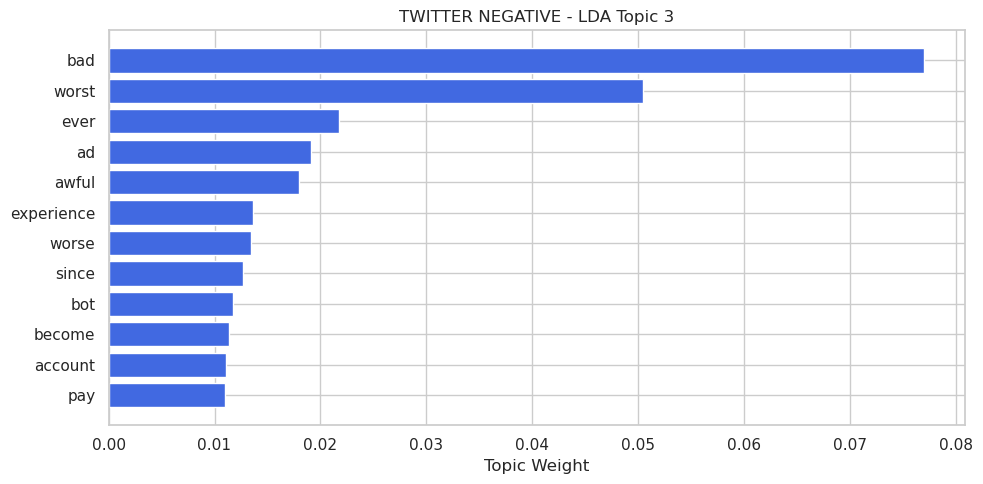

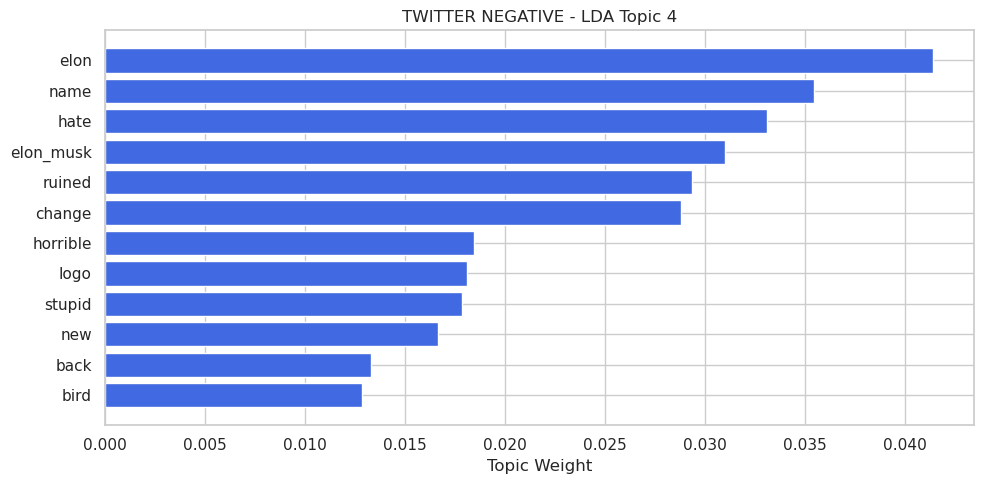

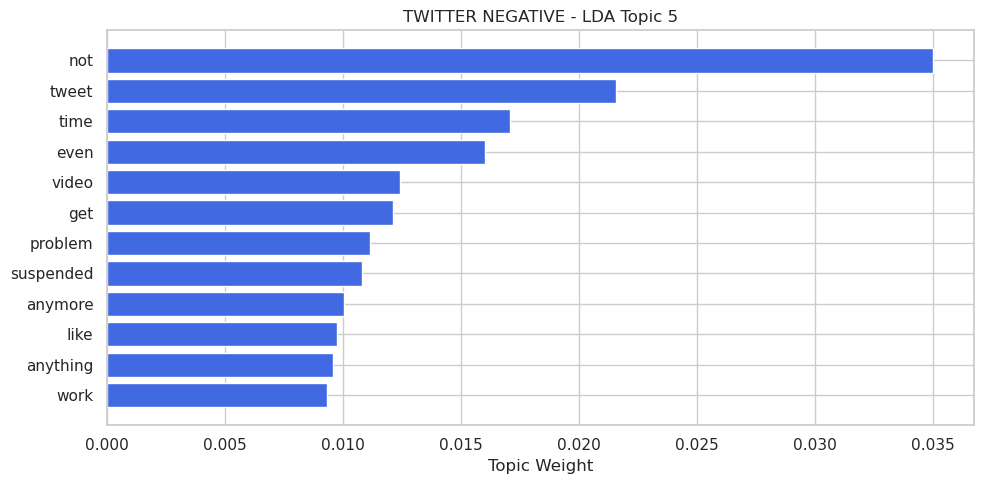

In [68]:


print("\n===== TWITTER POSITIVE TOPICS =====")
lda_pos_twitter = run_lda_block(twitter_pos)

print("\n===== TWITTER NEUTRAL TOPICS =====")
lda_neu_twitter = run_lda_block(twitter_neu)

print("\n===== TWITTER NEGATIVE TOPICS =====")
lda_neg_twitter = run_lda_block(twitter_neg)

visualize_lda_block(lda_pos_twitter, "Twitter Positive")
visualize_lda_block(lda_neu_twitter, "Twitter Neutral")
visualize_lda_block(lda_neg_twitter, "Twitter Negative")


##### On training data LDA performs well with coherence scores of 0.46 for Positive topics, 0.46 for Neutral Topics and 0.51 for Negative Topics
##### On an average LDA performs decently on all sentiments with average coherence score of 47.6

##### As per few reviews that we checked for the negative sentiment, LDA captures topics pretty well, which we could summarize as:
Many users companing about post limit, new update which has given few glitches in videos, bad experience due to bots and few services being available only for paid users, change of logo and sudden suspension of accounts

## Topic Modelling 2 NMF (using sentiment - pos, neu, neg)

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

def run_nmf(docs_df):
    docs_bigrams = prepare_tm_texts(docs_df)
    docs_text = [" ".join(doc) for doc in docs_bigrams]

    tfidf_vectorizer = TfidfVectorizer(
        max_df=0.95,
        min_df=10,
        ngram_range=(1, 1),
    )

    tfidf = tfidf_vectorizer.fit_transform(docs_text)
    feature_names = tfidf_vectorizer.get_feature_names_out()

    dictionary = Dictionary(docs_bigrams)
    dictionary.filter_extremes(no_below=10, no_above=0.5)

    topic_range = range(3, 10)
    coherence_scores = {}

    for k in topic_range:
        nmf_model = NMF(
            n_components=k,
            random_state=42,
            init="nndsvda",
            max_iter=2000
        )
        
        W = nmf_model.fit_transform(tfidf)
        H = nmf_model.components_

        top_words = []
        for topic in H:
            idxs = topic.argsort()[-20:]
            top_words.append([feature_names[i] for i in idxs])

        coherence_model = CoherenceModel(
            topics=top_words,
            texts=docs_bigrams,
            dictionary=dictionary,
            coherence='c_v'
        )

        coherence = coherence_model.get_coherence()
        coherence_scores[k] = coherence
        print(f"k={k} Coherence={coherence:.4f}")

    best_k = max(coherence_scores, key=coherence_scores.get)
    print("\nBest number of NMF topics =", best_k)

    final_nmf = NMF(
        n_components=best_k,
        random_state=42,
        init="nndsvda",
        max_iter=400
    )

    W_final = final_nmf.fit_transform(tfidf)
    H_final = final_nmf.components_

    print("\n--- FINAL NMF TOPIC WORDS ---\n")
    for idx, topic in enumerate(H_final):
        indices = topic.argsort()[-15:]
        words = [feature_names[i] for i in indices]
        print(f"TOPIC {idx+1}: {', '.join(words)}")

    return final_nmf, feature_names



def run_nmf_block(df_input):
    print("\n===== RUNNING NMF BLOCK =====")
    return run_nmf(df_input)
# nmf_pos, pos_feats = run_nmf(threads_pos)

# print("\n===== NMF THREADS NEUTRAL =====")
# nmf_neu, neu_feats = run_nmf(threads_neu)

# print("\n===== NMF THREADS NEGATIVE =====")
# nmf_neg, neg_feats = run_nmf(threads_neg)



### Visulaizing the Topics in pos, neu, neg (NMF)

In [70]:
import matplotlib.pyplot as plt

def plot_topic(words, weights, title):
    plt.figure(figsize=(10, 5))
    plt.barh(words[::-1], weights[::-1], color='royalblue')
    plt.title(title)
    plt.xlabel("Topic Weight")
    plt.tight_layout()
    plt.show()

def visualize_nmf_topics(nmf_model, feature_names, sentiment_label):
    print(f"\n--- VISUALIZING NMF TOPICS: {sentiment_label.upper()} ---")
    
    H = nmf_model.components_

    for idx, topic in enumerate(H):
        top_idx = topic.argsort()[-15:][::-1]
        words = [feature_names[i] for i in top_idx]
        weights = [topic[i] for i in top_idx]

        title = f"{sentiment_label.upper()} - NMF Topic {idx+1}"
        plot_topic(words, weights, title)

def visualize_nmf_block(nmf_model, feature_names, sentiment_label):
    visualize_nmf_topics(nmf_model, feature_names, sentiment_label)


# visualize_nmf_topics(nmf_pos, pos_feats, "Positive")
# visualize_nmf_topics(nmf_neu, neu_feats, "Neutral")
# visualize_nmf_topics(nmf_neg, neg_feats, "Negative")


## NMF Threads Analysis


===== NMF THREADS POSITIVE =====

===== RUNNING NMF BLOCK =====
k=3 Coherence=0.5009
k=4 Coherence=0.5314
k=5 Coherence=0.5307
k=6 Coherence=0.5460
k=7 Coherence=0.5340
k=8 Coherence=0.5157
k=9 Coherence=0.5043

Best number of NMF topics = 6

--- FINAL NMF TOPIC WORDS ---

TOPIC 1: new, think, pretty, job, use, feature, need, aap, twitter, instagram, like, really, one, far, good
TOPIC 2: see, download, ui, platform, feature, new, twitter, instagram, work, really, like, one, wow, aap, nice
TOPIC 3: use, need, facebook, alternative, feature, not, copy, think, much_better, far, instagram, way, like, twitter, better
TOPIC 4: facebook, thing, far, new, social, use, feature, world, aap, platform, instagram, social_medium, one, twitter, best
TOPIC 5: work, not, would, one, job, alternative, new, start, really, need, feature, far, instagram, like, great
TOPIC 6: post, would, much, cool, super, new, feature, facebook, far, really, wow, instagram, like, amazing, love

===== NMF THREADS NEUTRAL 

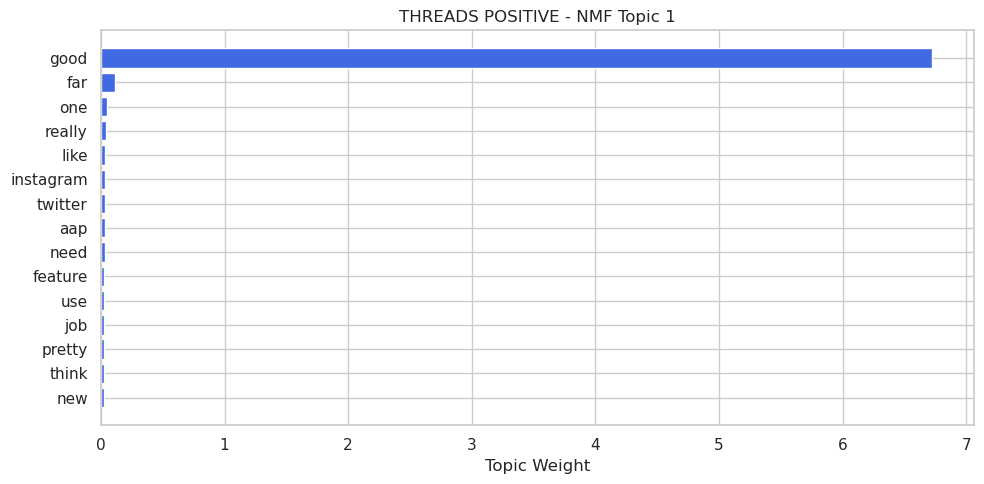

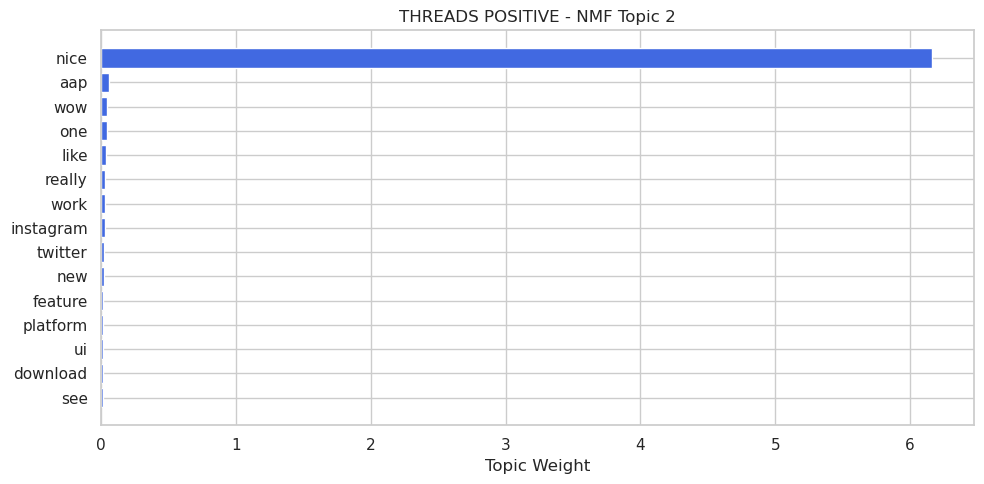

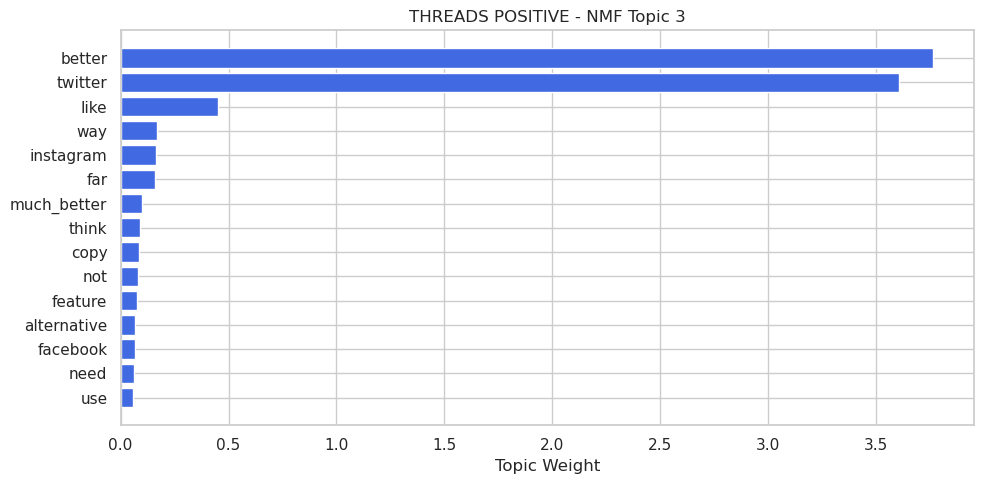

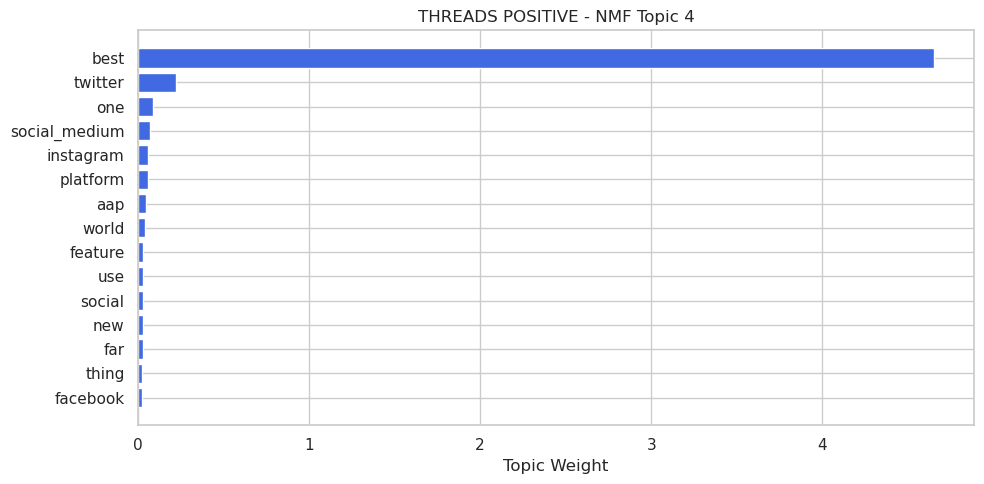

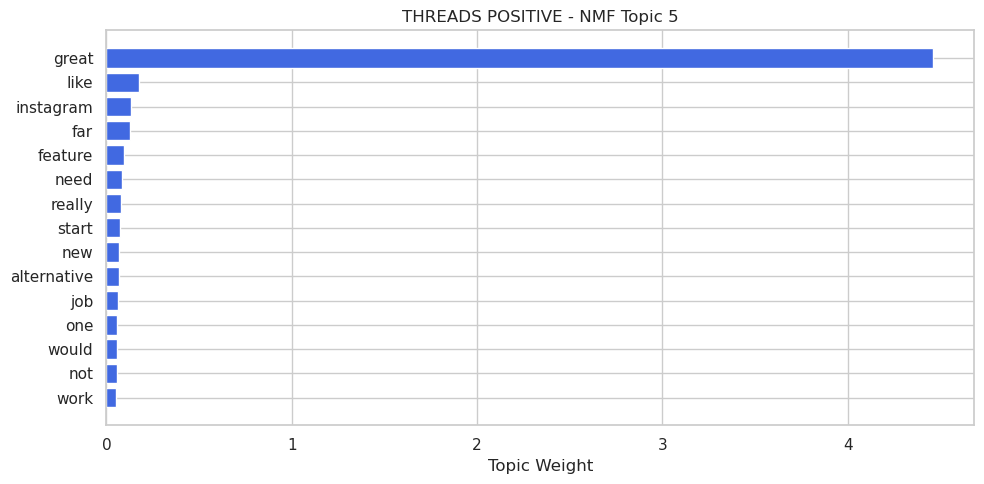

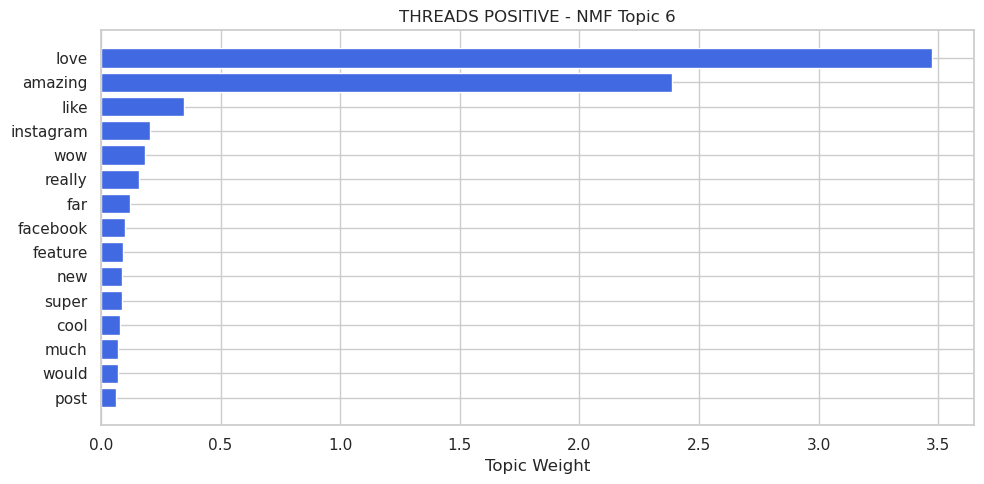


--- VISUALIZING NMF TOPICS: THREADS NEUTRAL ---


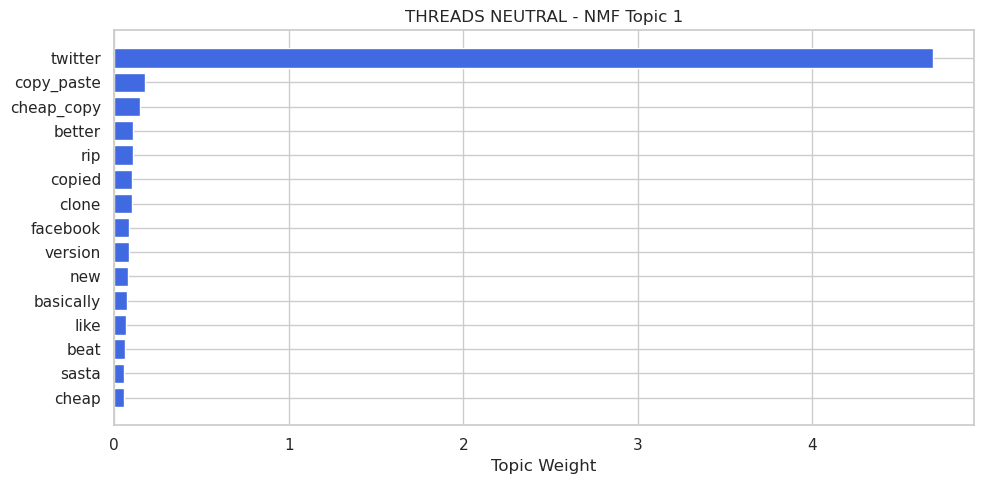

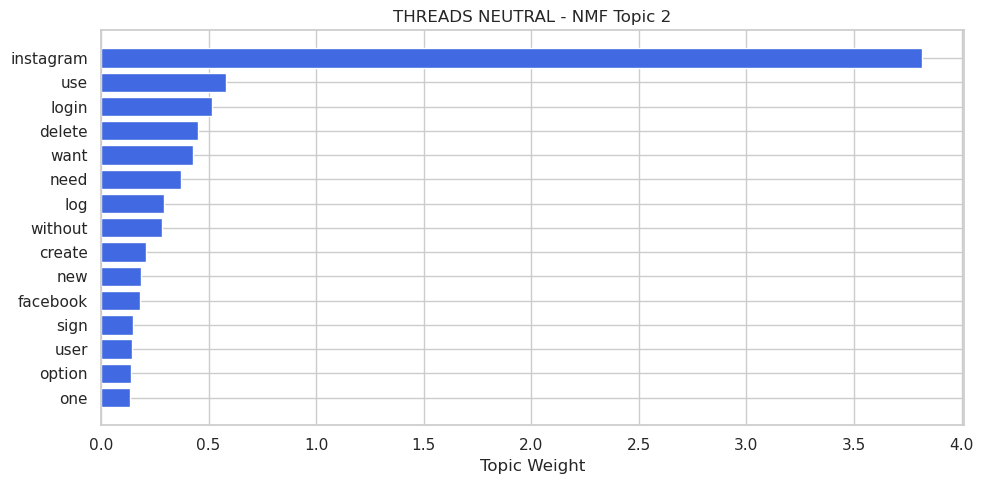

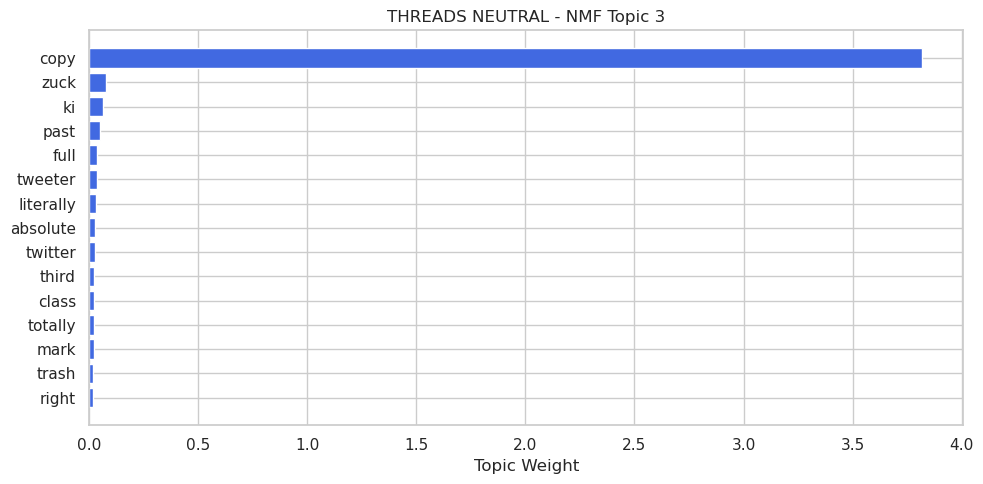

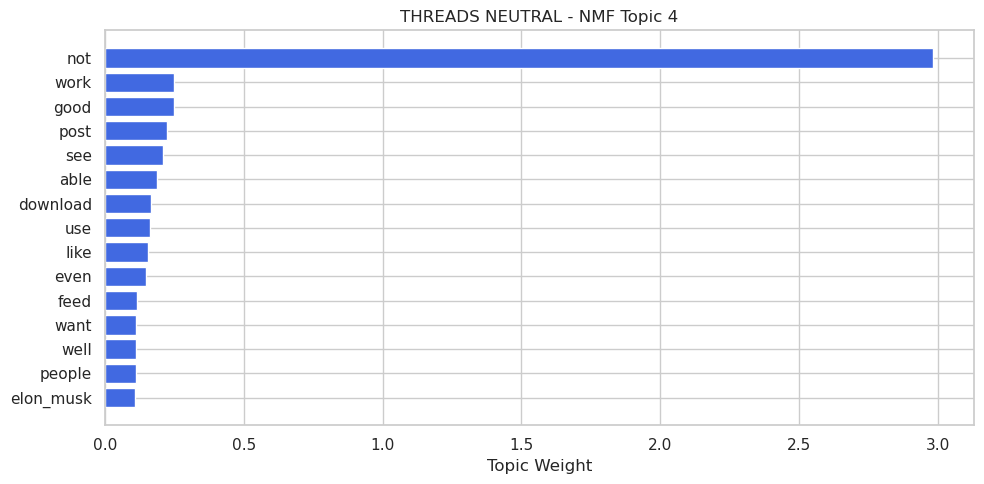

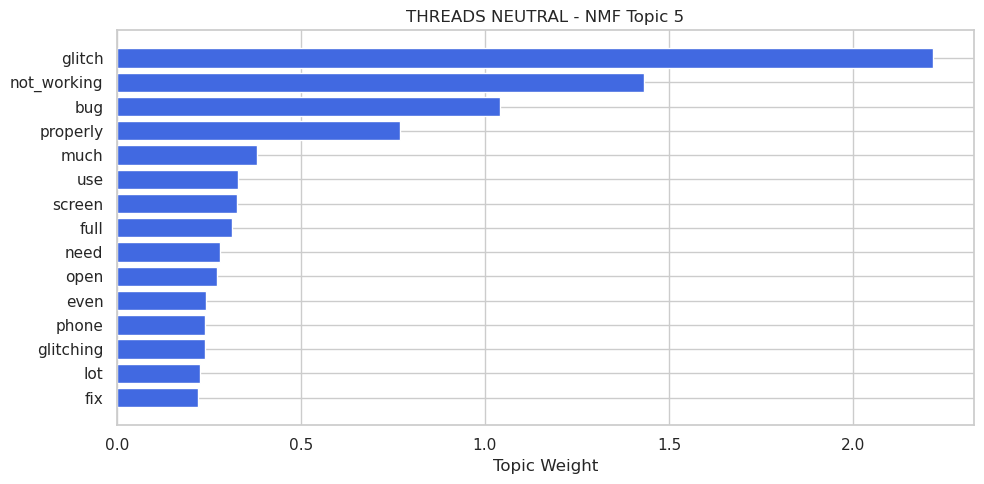

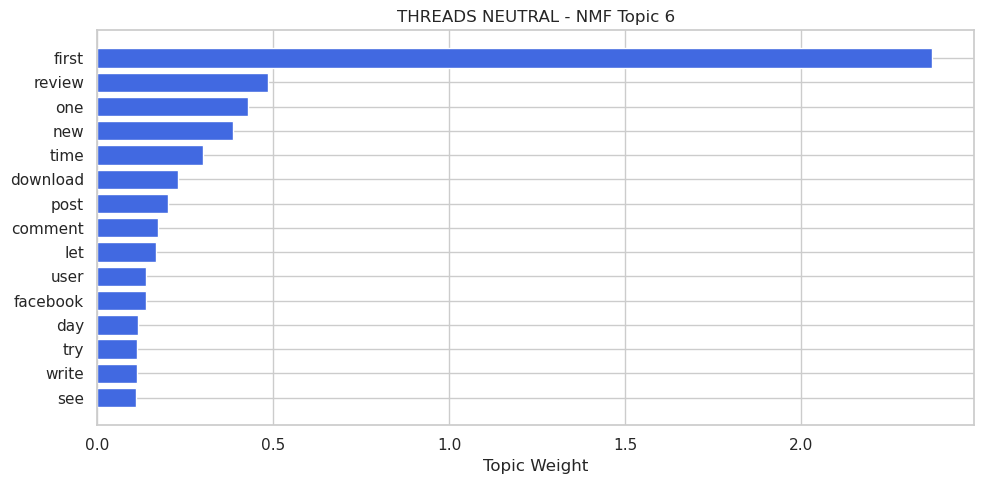


--- VISUALIZING NMF TOPICS: THREADS NEGATIVE ---


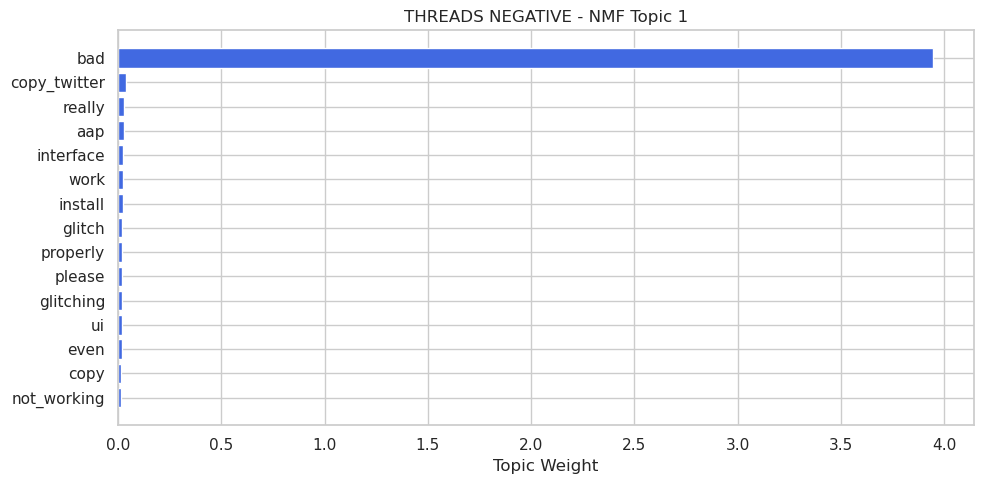

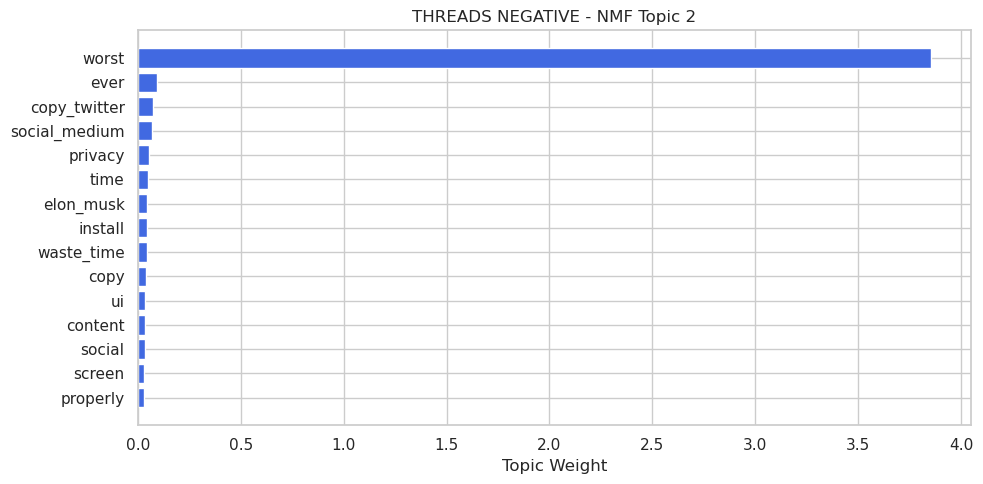

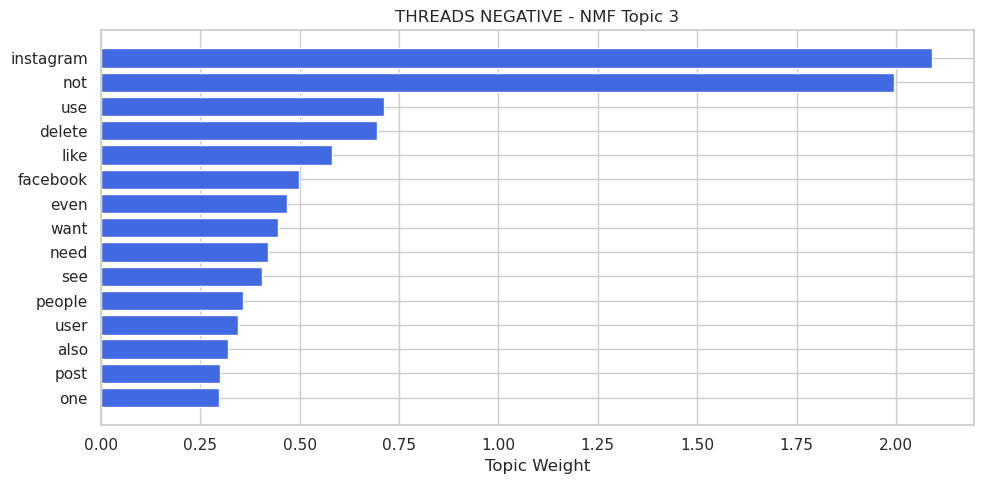

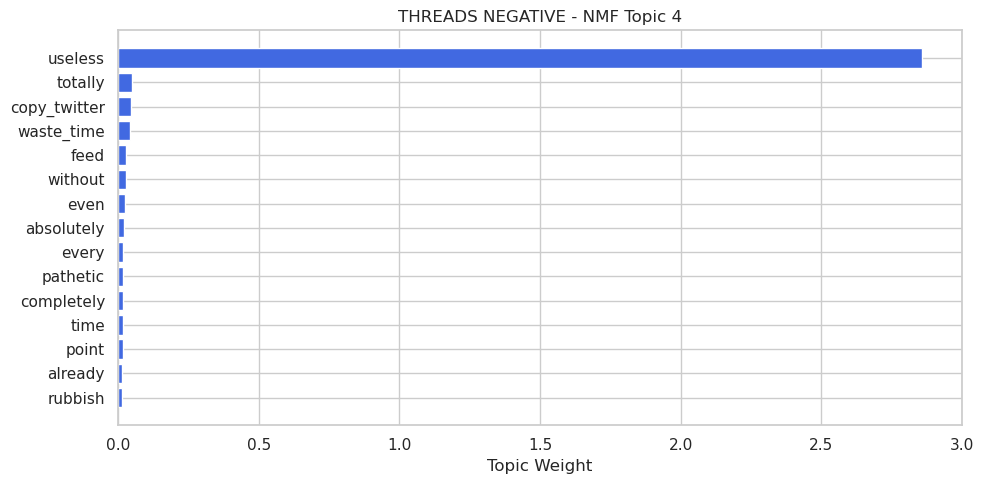

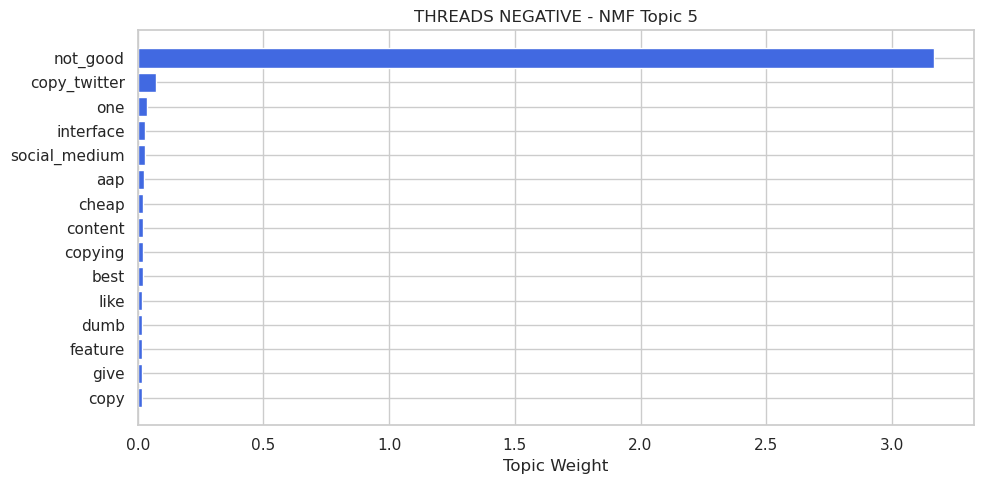

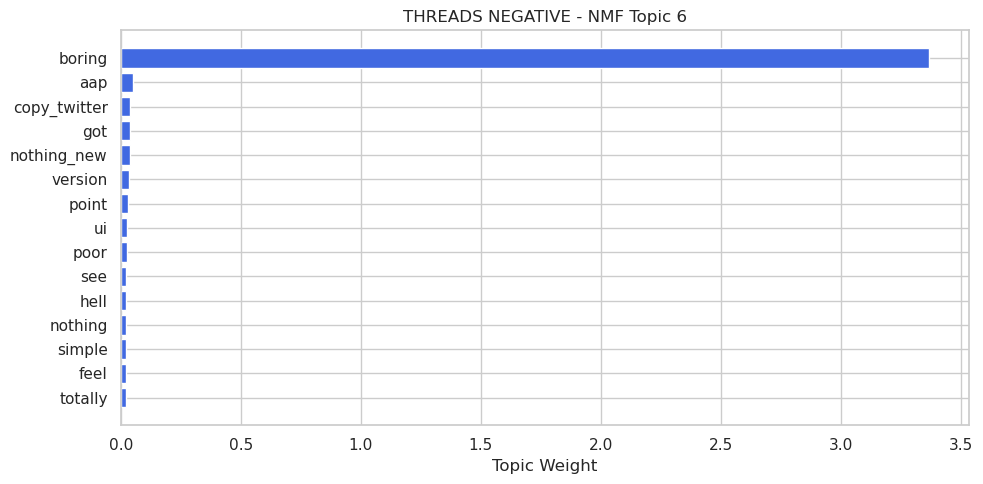

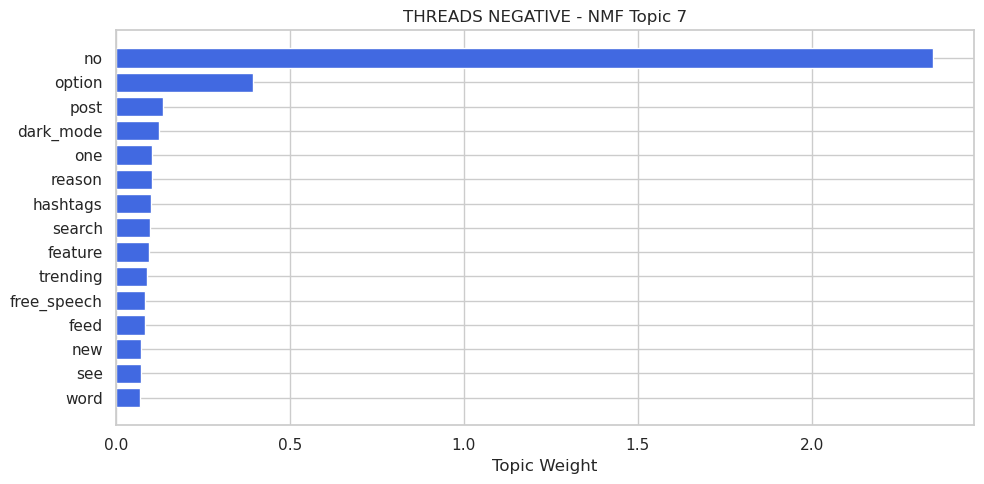

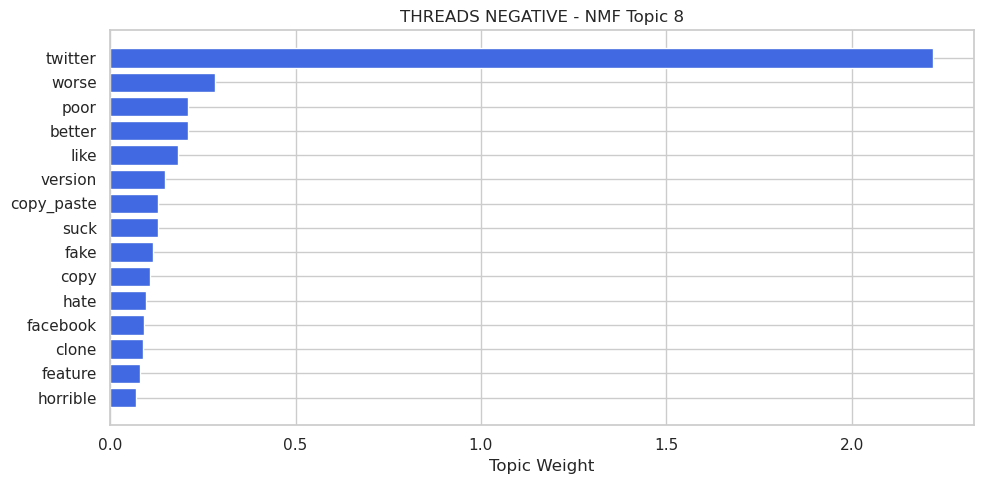

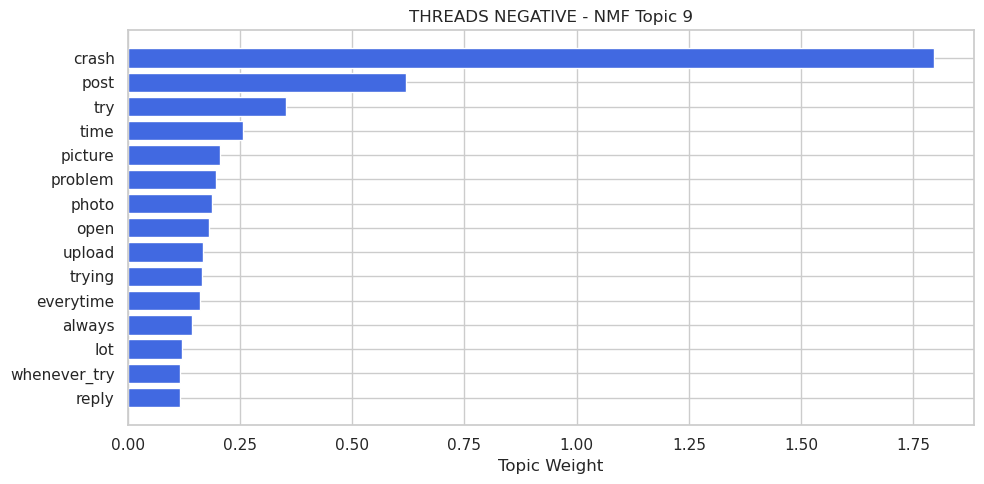

In [71]:
print("\n===== NMF THREADS POSITIVE =====")
nmf_pos, pos_feats = run_nmf_block(threads_pos)

print("\n===== NMF THREADS NEUTRAL =====")
nmf_neu, neu_feats = run_nmf_block(threads_neu)

print("\n===== NMF THREADS NEGATIVE =====")
nmf_neg, neg_feats = run_nmf_block(threads_neg)

visualize_nmf_block(nmf_pos, pos_feats, "Threads Positive")
visualize_nmf_block(nmf_neu, neu_feats, "Threads Neutral")
visualize_nmf_block(nmf_neg, neg_feats, "Threads Negative")


## Twitter NMF Analysis


===== NMF TWITTER POSITIVE =====

===== RUNNING NMF BLOCK =====
k=3 Coherence=0.4264
k=4 Coherence=0.4238
k=5 Coherence=0.4387
k=6 Coherence=0.4233
k=7 Coherence=0.4109
k=8 Coherence=0.4069
k=9 Coherence=0.4152

Best number of NMF topics = 5

--- FINAL NMF TOPIC WORDS ---

TOPIC 1: elon_musk, information, not, pretty, use, news, thing, work, far, elon, platform, really, like, used, good
TOPIC 2: elon, work, people, use, super, update, easy_use, logo, aap, experience, like, platform, really, one, nice
TOPIC 3: not, social_medium, job, free_speech, place, like, update, better, news, elon, platform, used, work, experience, great
TOPIC 4: social_medium, experience, better, ever, name, free_speech, elon, news, like, thread, world, elon_musk, one, platform, best
TOPIC 5: thing, bird, platform, not, much, excellent, elon_musk, used, free_speech, really, new, better, like, elon, love

===== NMF TWITTER NEUTRAL =====

===== RUNNING NMF BLOCK =====
k=3 Coherence=0.3426
k=4 Coherence=0.4157
k=5 

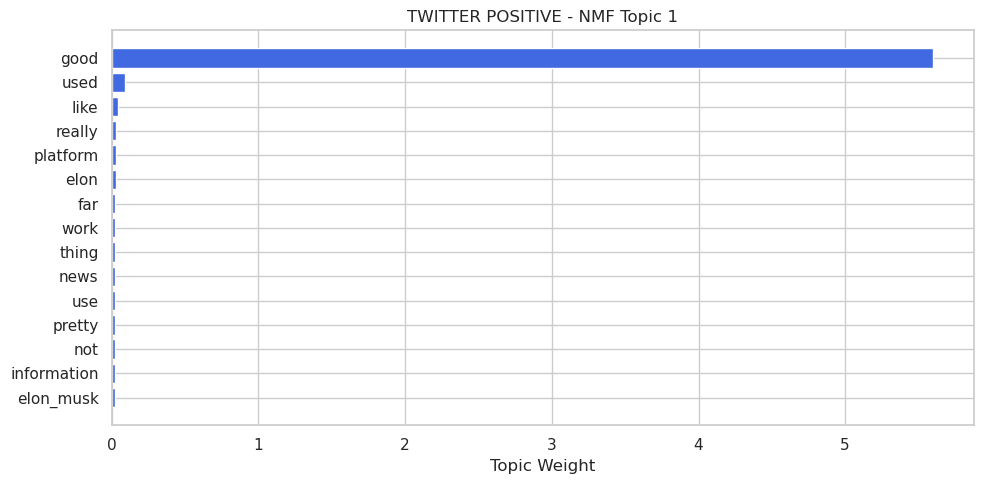

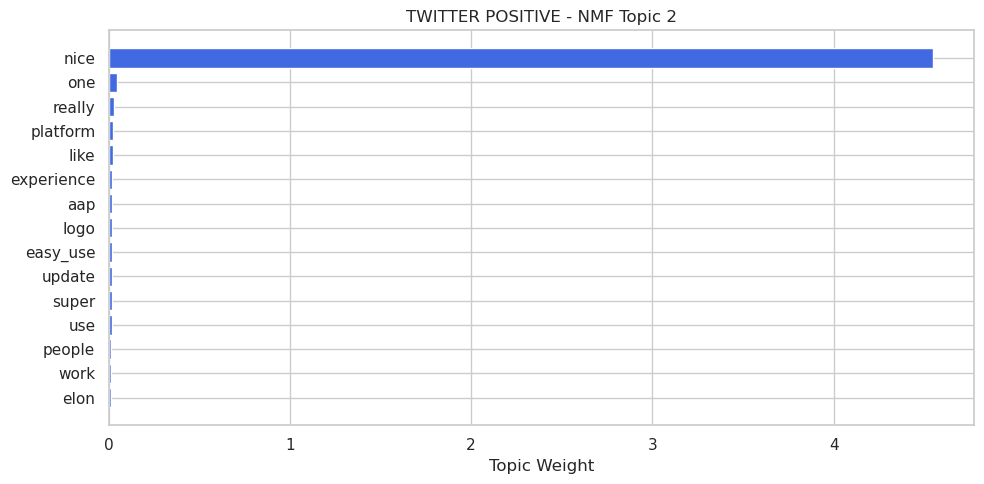

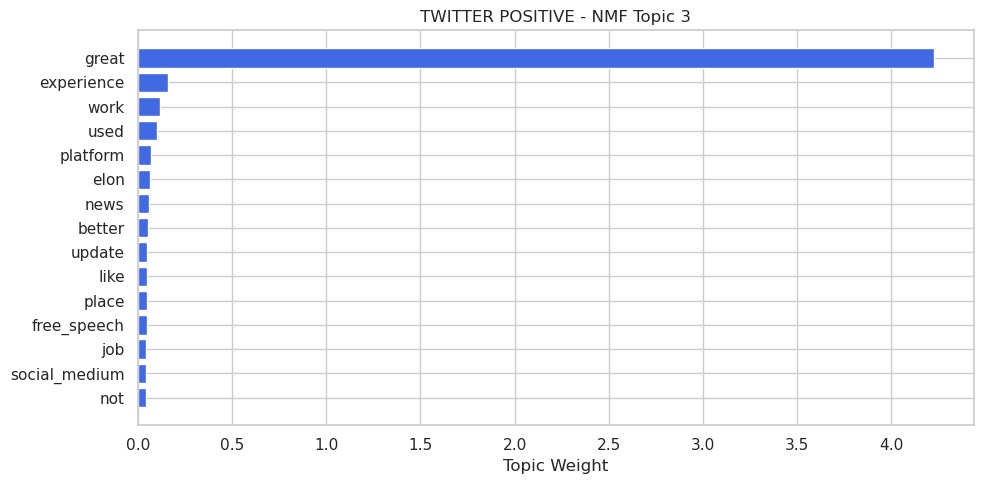

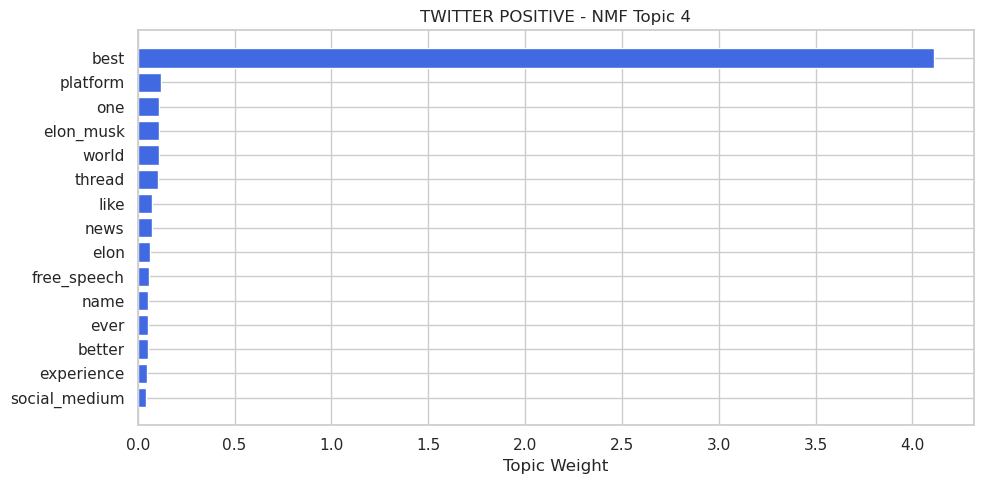

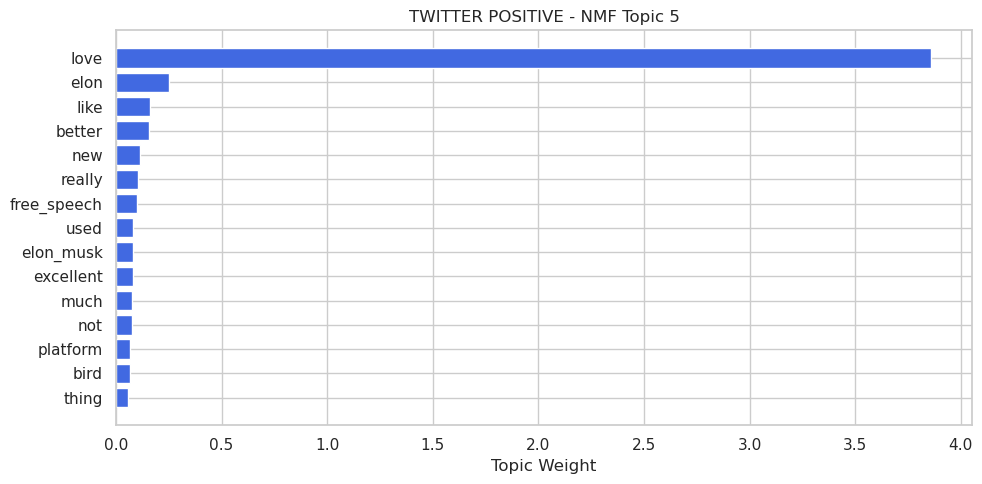


--- VISUALIZING NMF TOPICS: TWITTER NEUTRAL ---


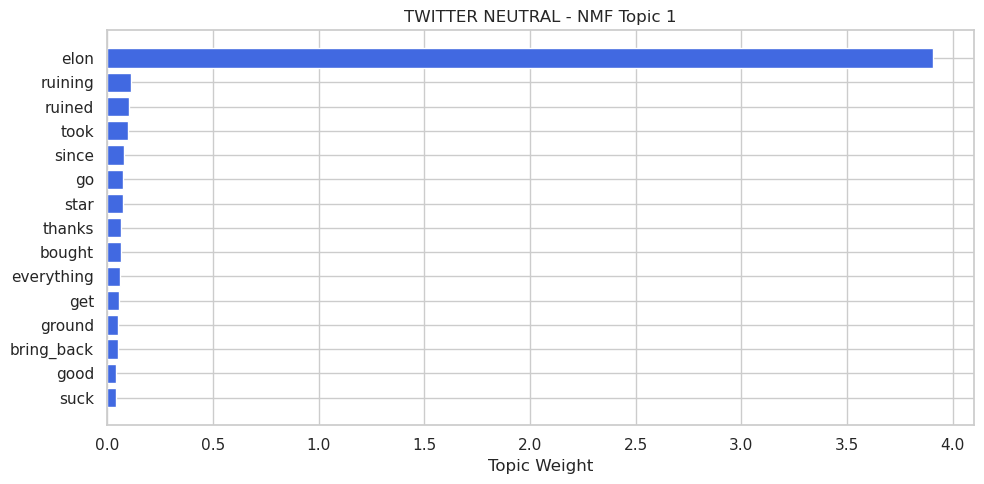

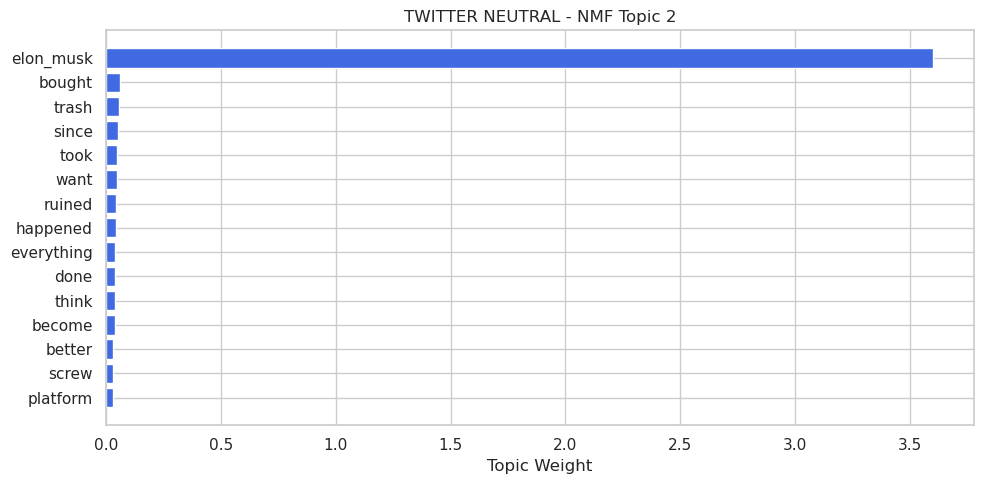

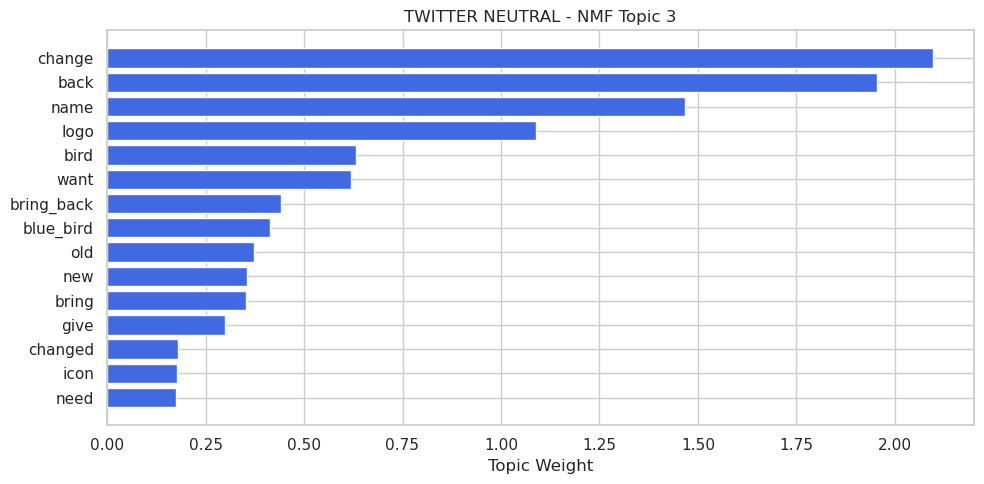

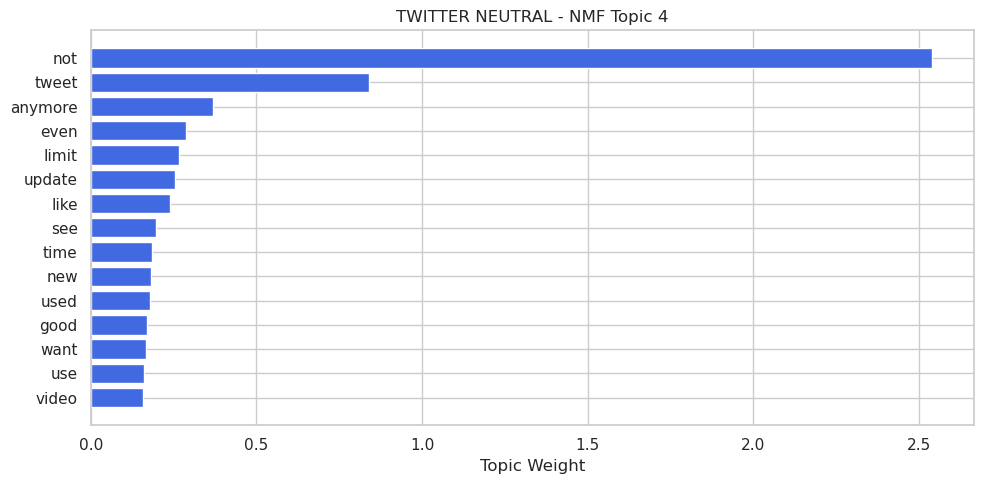


--- VISUALIZING NMF TOPICS: TWITTER NEGATIVE ---


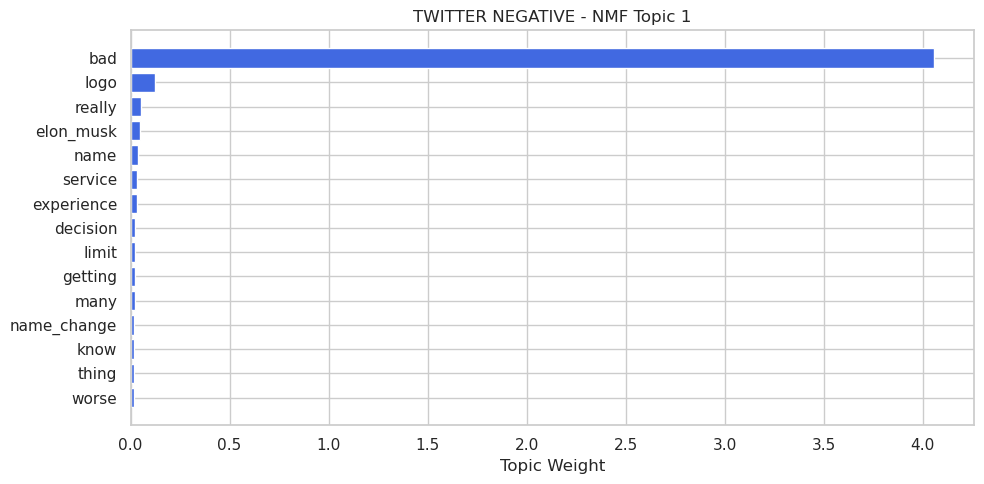

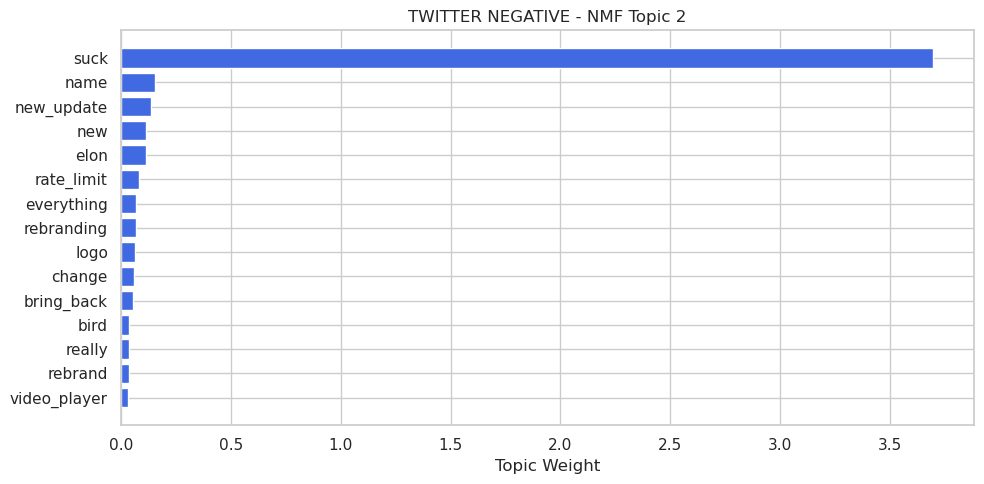

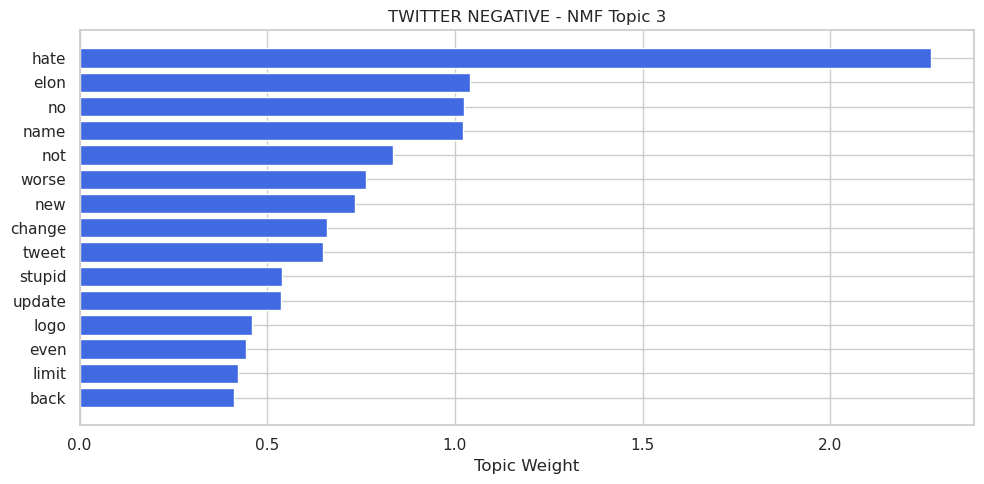

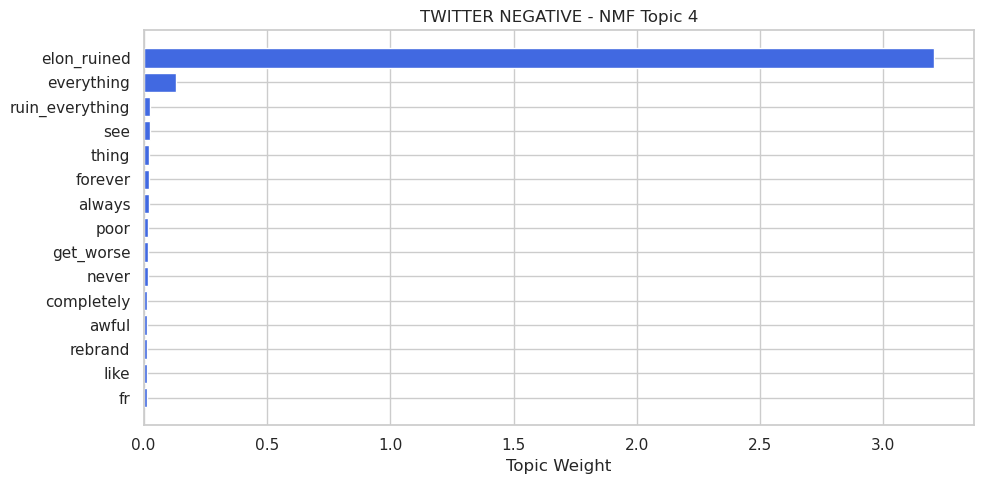

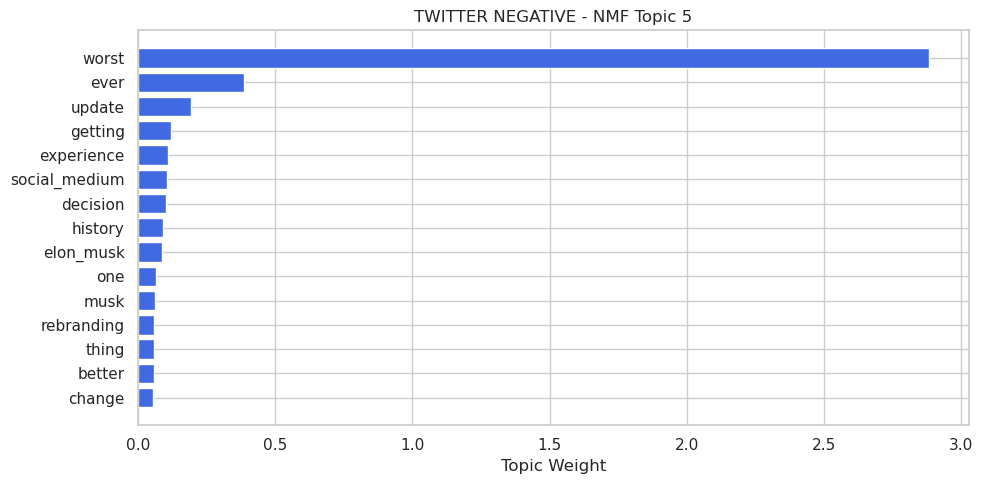

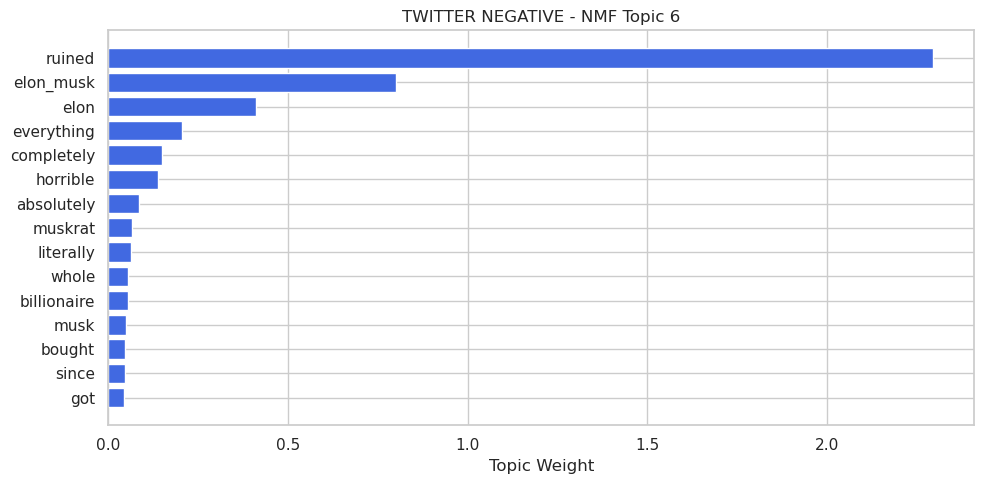

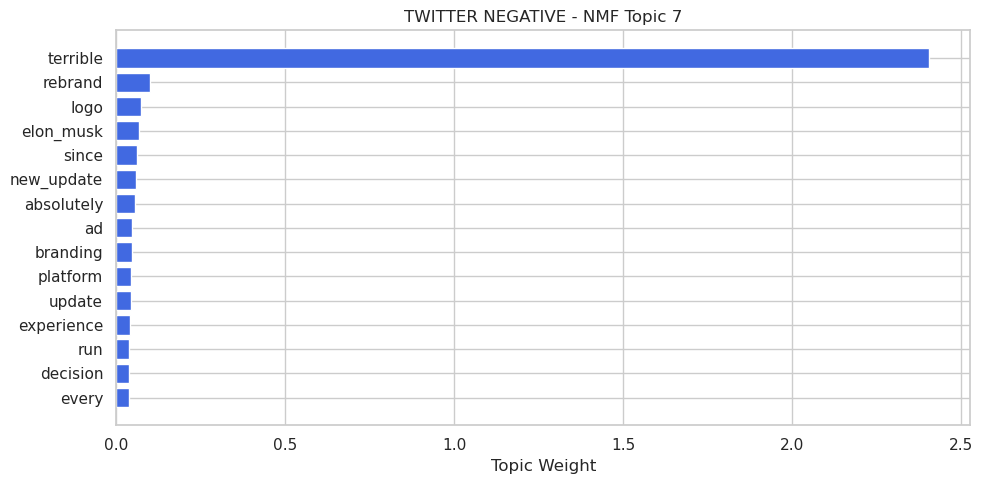

In [72]:
print("\n===== NMF TWITTER POSITIVE =====")
nmf_pos_tw, pos_feats_tw = run_nmf_block(twitter_pos)

print("\n===== NMF TWITTER NEUTRAL =====")
nmf_neu_tw, neu_feats_tw = run_nmf_block(twitter_neu)
print("\n===== NMF TWITTER NEGATIVE =====")
nmf_neg_tw, neg_feats_tw = run_nmf_block(twitter_neg)

visualize_nmf_block(nmf_pos_tw, pos_feats_tw, "Twitter Positive")
visualize_nmf_block(nmf_neu_tw, neu_feats_tw, "Twitter Neutral")
visualize_nmf_block(nmf_neg_tw, neg_feats_tw, "Twitter Negative")


##### NMF seems to have decent coherence for positive neutral and negative around 0.40 but it is significantly low than LDA and the insights found in LDA seem to be much better than NMF. Hence, LDA is the best choice for now.

## BERTopic  - remove this later

In [73]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.pyplot as plt
'''
# Sentiment splits
positive_df = df[df["sentiment"] == "positive"].copy()
neutral_df  = df[df["sentiment"] == "neutral"].copy()
negative_df = df[df["sentiment"] == "negative"].copy()

positive_texts = positive_df["review_description"].tolist()
neutral_texts  = neutral_df["review_description"].tolist()
negative_texts = negative_df["review_description"].tolist()

print("Counts:", len(positive_texts), len(neutral_texts), len(negative_texts))

# Embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

def run_bertopic(texts, min_topic_size=20):
    embeddings = embedding_model.encode(texts, show_progress_bar=True)
    model = BERTopic(
        language="english",
        umap_model=None,
        min_topic_size=min_topic_size,
        top_n_words=15,
        calculate_probabilities=True,
        verbose=True
    )
    topics, probs = model.fit_transform(texts, embeddings)
    return model, topics, probs, embeddings

print("Running BERTopic on positive reviews...")
pos_model, pos_topics5, pos_probs5, pos_embeddings = run_bertopic(positive_texts, min_topic_size=20)

print("Running BERTopic on neutral reviews...")
neu_model, neu_topics5, neu_probs5, neu_embeddings = run_bertopic(neutral_texts, min_topic_size=20)

print("Running BERTopic on negative reviews...")
neg_model, neg_topics5, neg_probs5, neg_embeddings = run_bertopic(negative_texts, min_topic_size=20)

positive_df["topic5"] = pos_topics5
neutral_df["topic5"]  = neu_topics5
negative_df["topic5"] = neg_topics5
'''

'\n# Sentiment splits\npositive_df = df[df["sentiment"] == "positive"].copy()\nneutral_df  = df[df["sentiment"] == "neutral"].copy()\nnegative_df = df[df["sentiment"] == "negative"].copy()\n\npositive_texts = positive_df["review_description"].tolist()\nneutral_texts  = neutral_df["review_description"].tolist()\nnegative_texts = negative_df["review_description"].tolist()\n\nprint("Counts:", len(positive_texts), len(neutral_texts), len(negative_texts))\n\n# Embedding model\nembedding_model = SentenceTransformer("all-MiniLM-L6-v2")\n\ndef run_bertopic(texts, min_topic_size=20):\n    embeddings = embedding_model.encode(texts, show_progress_bar=True)\n    model = BERTopic(\n        language="english",\n        umap_model=None,\n        min_topic_size=min_topic_size,\n        top_n_words=15,\n        calculate_probabilities=True,\n        verbose=True\n    )\n    topics, probs = model.fit_transform(texts, embeddings)\n    return model, topics, probs, embeddings\n\nprint("Running BERTopic on 

In [74]:
# pos_model, pos_topics, pos_probs, pos_emb = run_bertopic(positive_texts)
# neu_model, neu_topics, neu_probs, neu_emb = run_bertopic(neutral_texts)
# neg_model, neg_topics, neg_probs, neg_emb = run_bertopic(negative_texts)
'''
def reduce_to_5(model, texts, embeddings):
    reduced_model = model.reduce_topics(texts, nr_topics=5)
    new_topics, new_probs = reduced_model.transform(texts, embeddings)
    return reduced_model, new_topics, new_probs

pos_model5, pos_topics5, pos_probs5 = reduce_to_5(pos_model, positive_texts, pos_embeddings)
neu_model5, neu_topics5, neu_probs5 = reduce_to_5(neu_model, neutral_texts, neu_embeddings)
neg_model5, neg_topics5, neg_probs5 = reduce_to_5(neg_model, negative_texts, neg_embeddings)
'''

'\ndef reduce_to_5(model, texts, embeddings):\n    reduced_model = model.reduce_topics(texts, nr_topics=5)\n    new_topics, new_probs = reduced_model.transform(texts, embeddings)\n    return reduced_model, new_topics, new_probs\n\npos_model5, pos_topics5, pos_probs5 = reduce_to_5(pos_model, positive_texts, pos_embeddings)\nneu_model5, neu_topics5, neu_probs5 = reduce_to_5(neu_model, neutral_texts, neu_embeddings)\nneg_model5, neg_topics5, neg_probs5 = reduce_to_5(neg_model, negative_texts, neg_embeddings)\n'

In [75]:
import matplotlib.pyplot as plt
'''
def plot_topic(words, weights, title):
    plt.figure(figsize=(10, 5))
    plt.barh(words[::-1], weights[::-1], color="royalblue")
    plt.title(title)
    plt.xlabel("Topic Weight")
    plt.tight_layout()
    plt.show()

'''

'\ndef plot_topic(words, weights, title):\n    plt.figure(figsize=(10, 5))\n    plt.barh(words[::-1], weights[::-1], color="royalblue")\n    plt.title(title)\n    plt.xlabel("Topic Weight")\n    plt.tight_layout()\n    plt.show()\n\n'

In [76]:
'''
def inspect_topics(model, df_sent, group_name):
    print(f"===== BERTOPIC SUMMARY ({group_name.upper()}) — 5 TOPICS =====")

    topic_info = model.get_topic_info()
    print(topic_info)

    print(f"\n--- TOP WORDS ({group_name}) ---")
    for tid in topic_info["Topic"]:
        if tid == -1:
            continue
        print(f"\nTopic {tid}:")
        print(model.get_topic(tid))

    # Topic distribution barplot
    plt.figure(figsize=(8,4))
    sns.barplot(x="Topic", y="Count", data=topic_info[topic_info["Topic"] != -1])
    plt.title(f"Topic Distribution ({group_name.capitalize()} Reviews)")
    plt.tight_layout()
    plt.show()

    for tid in topic_info["Topic"]:
        if tid == -1:
            continue

        words_scores = model.get_topic(tid)
        words = [w for (w, score) in words_scores]
        weights = [score for (w, score) in words_scores]

        plot_topic(words, weights, title=f"{group_name.upper()} - BERTopic {tid}")

    print(f"\n--- REPRESENTATIVE EXAMPLES ({group_name}) ---")
    repr_docs = model.get_representative_docs()
    for tid, docs in repr_docs.items():
        if tid == -1:
            continue
        print(f"\nTopic {tid} Examples:")
        for d in docs[:3]:
            print("-", d[:200], "...")
'''

'\ndef inspect_topics(model, df_sent, group_name):\n    print(f"===== BERTOPIC SUMMARY ({group_name.upper()}) — 5 TOPICS =====")\n\n    topic_info = model.get_topic_info()\n    print(topic_info)\n\n    print(f"\n--- TOP WORDS ({group_name}) ---")\n    for tid in topic_info["Topic"]:\n        if tid == -1:\n            continue\n        print(f"\nTopic {tid}:")\n        print(model.get_topic(tid))\n\n    # Topic distribution barplot\n    plt.figure(figsize=(8,4))\n    sns.barplot(x="Topic", y="Count", data=topic_info[topic_info["Topic"] != -1])\n    plt.title(f"Topic Distribution ({group_name.capitalize()} Reviews)")\n    plt.tight_layout()\n    plt.show()\n\n    for tid in topic_info["Topic"]:\n        if tid == -1:\n            continue\n\n        words_scores = model.get_topic(tid)\n        words = [w for (w, score) in words_scores]\n        weights = [score for (w, score) in words_scores]\n\n        plot_topic(words, weights, title=f"{group_name.upper()} - BERTopic {tid}")\n\n    pr

In [77]:
'''
inspect_topics(pos_model5, positive_df, "positive")
inspect_topics(neu_model5, neutral_df, "neutral")
inspect_topics(neg_model5, negative_df, "negative")
'''

'\ninspect_topics(pos_model5, positive_df, "positive")\ninspect_topics(neu_model5, neutral_df, "neutral")\ninspect_topics(neg_model5, negative_df, "negative")\n'

In [78]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
'''
def get_bertopic_top_words(model, top_n=15):
    topic_words = []
    for topic_num in model.get_topics().keys():
        if topic_num == -1:  # skip outlier topic
            continue
        words_probs = model.get_topic(topic_num)
        words = [w for w, _ in words_probs[:top_n]]
        topic_words.append(words)
    return topic_words

def tokenize_texts(texts):
    return [text.split() for text in texts]

def compute_bertopic_coherence(model, texts, top_n=15):
    tokenized_texts = tokenize_texts(texts)
    topic_word_lists = get_bertopic_top_words(model, top_n=top_n)
    dictionary = Dictionary(tokenized_texts)
    corpus = [dictionary.doc2bow(text) for text in tokenized_texts]
    cm = CoherenceModel(
        topics=topic_word_lists,
        texts=tokenized_texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    return cm.get_coherence()

# Compute coherence for each sentiment
pos_coherence = compute_bertopic_coherence(pos_model, positive_texts)
neu_coherence = compute_bertopic_coherence(neu_model, neutral_texts)
neg_coherence = compute_bertopic_coherence(neg_model, negative_texts)

print("Positive BERTopic Coherence:", pos_coherence)
print("Neutral BERTopic Coherence:", neu_coherence)
print("Negative BERTopic Coherence:", neg_coherence)
'''

'\ndef get_bertopic_top_words(model, top_n=15):\n    topic_words = []\n    for topic_num in model.get_topics().keys():\n        if topic_num == -1:  # skip outlier topic\n            continue\n        words_probs = model.get_topic(topic_num)\n        words = [w for w, _ in words_probs[:top_n]]\n        topic_words.append(words)\n    return topic_words\n\ndef tokenize_texts(texts):\n    return [text.split() for text in texts]\n\ndef compute_bertopic_coherence(model, texts, top_n=15):\n    tokenized_texts = tokenize_texts(texts)\n    topic_word_lists = get_bertopic_top_words(model, top_n=top_n)\n    dictionary = Dictionary(tokenized_texts)\n    corpus = [dictionary.doc2bow(text) for text in tokenized_texts]\n    cm = CoherenceModel(\n        topics=topic_word_lists,\n        texts=tokenized_texts,\n        dictionary=dictionary,\n        coherence=\'c_v\'\n    )\n    return cm.get_coherence()\n\n# Compute coherence for each sentiment\npos_coherence = compute_bertopic_coherence(pos_model,

BERTopic Analysis for Threads Reviews

---

Positive Sentiment Analysis
**Coherence Score:** 0.5980  


---

Neutral Sentiment Analysis
**Coherence Score:** 0.4907


---

Negative Sentiment Analysis
**Coherence Score:** 0.411


BERTopic does an impressive job in positive sentiment but performs pretty poorly in negative sentiment, hence we are not going to analyse each topic in the sentiments.

## FINAL VERDIT : LDA Performs the best among all the unsupervised models and provides the best coherence score and a good division of topics among the sentiments

## BERTopic

In [79]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

# -----------------------------
# Embedding model (shared)
# -----------------------------
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# -----------------------------
# Plotting helper
# -----------------------------
def plot_topic(words, weights, title):
    plt.figure(figsize=(10,5))
    plt.barh(words[::-1], weights[::-1], color="royalblue")
    plt.title(title)
    plt.xlabel("Topic Weight")
    plt.tight_layout()
    plt.show()

# -----------------------------
# BERTopic pipeline
# -----------------------------
def run_bertopic_pipeline(df, sentiment_col="sentiment", review_col="review_description",
                          sentiment_value=None, min_topic_size=20, reduce_to=5):
    """
    Run BERTopic for a given sentiment subset of a DataFrame.
    Returns the fitted model, topics, probabilities, embeddings, and coherence score.
    """
    # Filter data
    subset = df[df[sentiment_col] == sentiment_value].copy()
    
    # Remove NaN values and convert to string
    subset = subset[subset[review_col].notna()].copy()  
    subset[review_col] = subset[review_col].astype(str)  
    texts = subset[review_col].tolist()

    texts = [t for t in texts if t.strip() != ""]
    
    # Compute embeddings
    embeddings = embedding_model.encode(texts, show_progress_bar=True)
    
    # Fit BERTopic
    model = BERTopic(
        language="english",
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        min_topic_size=min_topic_size,
        top_n_words=15,
        calculate_probabilities=True,
        verbose=False
    )
    
    topics, probs = model.fit_transform(texts, embeddings)
    
    # Reduce topics
    if reduce_to is not None:
        model = model.reduce_topics(texts, nr_topics=reduce_to)
        topics, probs = model.transform(texts, embeddings)
    
    # Inspect topics
    inspect_topics(model, texts, sentiment_value.capitalize())
    
    # Compute coherence
    coherence = compute_bertopic_coherence(model, texts)
    
    print(f"{sentiment_value.capitalize()} BERTopic Coherence:", coherence)
    
    return model, topics, probs, embeddings, coherence

# -----------------------------
# Inspect topics helper
# -----------------------------
def inspect_topics(model, texts, group_name):
    print(f"\n===== BERTOPIC SUMMARY ({group_name.upper()}) — 5 TOPICS =====")
    topic_info = model.get_topic_info()
    print(topic_info)

    # Topic distribution barplot
    plt.figure(figsize=(8,4))
    sns.barplot(x="Topic", y="Count", data=topic_info[topic_info["Topic"] != -1])
    plt.title(f"Topic Distribution ({group_name.capitalize()} Reviews)")
    plt.tight_layout()
    plt.show()

    # Plot top words per topic
    for tid in topic_info["Topic"]:
        if tid == -1:
            continue
        words_scores = model.get_topic(tid)
        words = [w for w, score in words_scores]
        weights = [score for w, score in words_scores]
        plot_topic(words, weights, title=f"{group_name.upper()} - BERTopic {tid}")

    # Representative examples
    print(f"\n--- REPRESENTATIVE EXAMPLES ({group_name}) ---")
    repr_docs = model.get_representative_docs()
    for tid, docs in repr_docs.items():
        if tid == -1:
            continue
        print(f"\nTopic {tid} Examples:")
        for d in docs[:3]:
            print("-", d[:200], "...")

# -----------------------------
# Coherence computation
# -----------------------------
def get_bertopic_top_words(model, top_n=15):
    topic_words = []
    for topic_num in model.get_topics().keys():
        if topic_num == -1:
            continue
        words_probs = model.get_topic(topic_num)
        words = [w for w, _ in words_probs[:top_n]]
        topic_words.append(words)
    return topic_words

def tokenize_texts(texts):
    return [text.split() for text in texts]

def compute_bertopic_coherence(model, texts, top_n=15):
    tokenized_texts = tokenize_texts(texts)
    topic_word_lists = get_bertopic_top_words(model, top_n=top_n)
    dictionary = Dictionary(tokenized_texts)
    cm = CoherenceModel(
        topics=topic_word_lists,
        texts=tokenized_texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    return cm.get_coherence()


### Threads BERTopic Analysis

Batches: 100%|████████████████████████████████████████████████████████████████| 494/494 [00:03<00:00, 135.35it/s]



===== BERTOPIC SUMMARY (POSITIVE) — 5 TOPICS =====
   Topic  Count                             Name  \
0     -1   3489                -1_the_to_app_and   
1      0   7364                 0_app_to_the_and   
2      1   4785            1_good_nice_very_best   
3      2    133       2_mark_zuckerberg_zuck_you   
4      3     30  3_copy_original_copycat_copying   

                                      Representation  \
0  [the, to, app, and, it, is, this, twitter, of,...   
1  [app, to, the, and, is, it, twitter, this, ins...   
2  [good, nice, very, best, super, wow, awesome, ...   
3  [mark, zuckerberg, zuck, you, thanks, this, an...   
4  [copy, original, copycat, copying, is, of, cop...   

                                 Representative_Docs  
0  [I know there are tons of updates coming but T...  
1  [I like where this is going but a lot of thing...  
2                                 [Good, good, Good]  
3  [Very Nice App Love U Mark Zuckerberg 🖤💯, Good...  
4  [Nice copy, Good cop

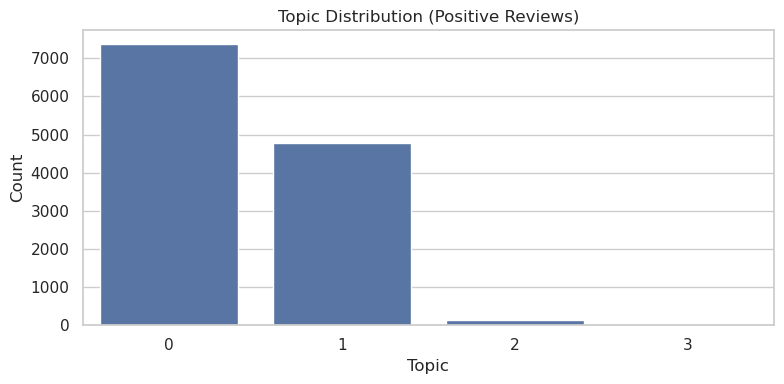

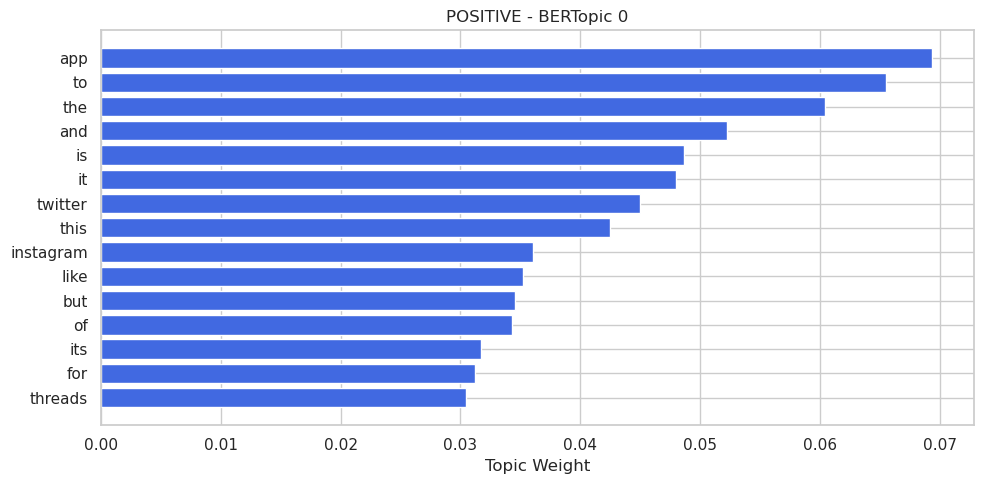

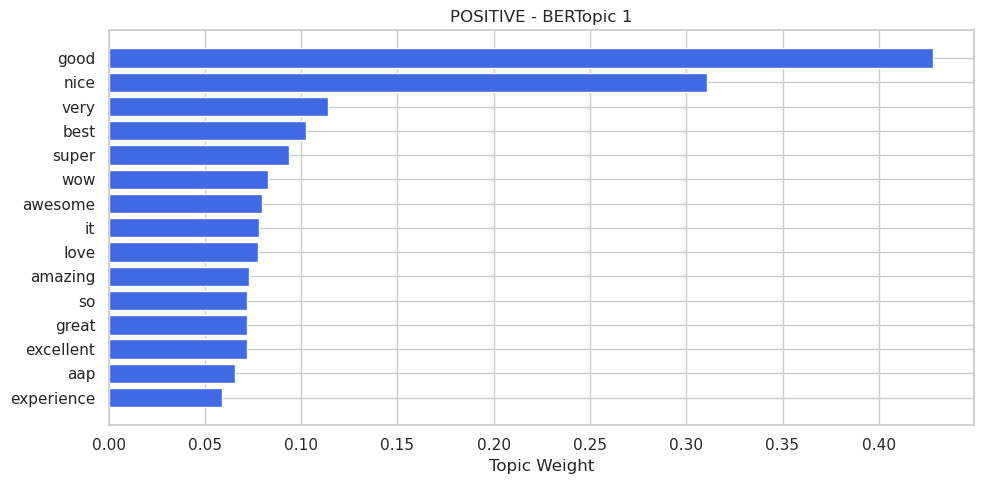

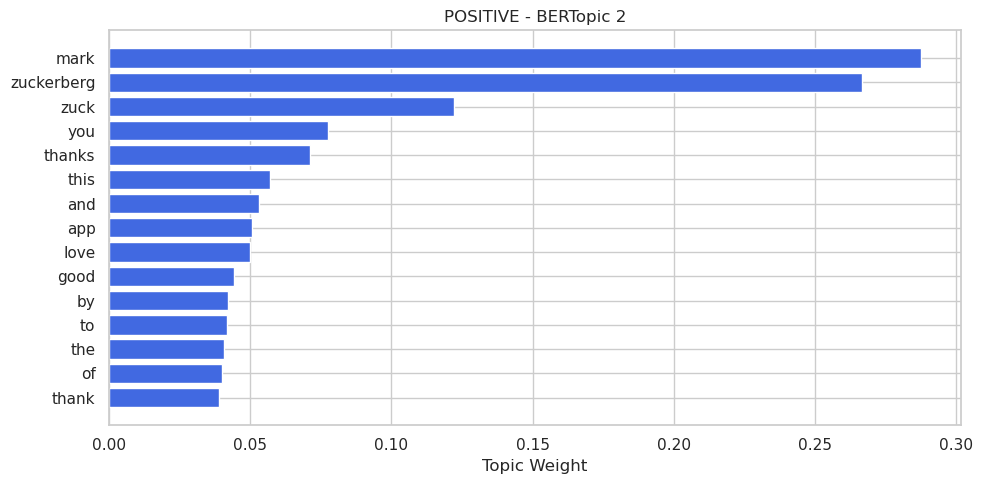

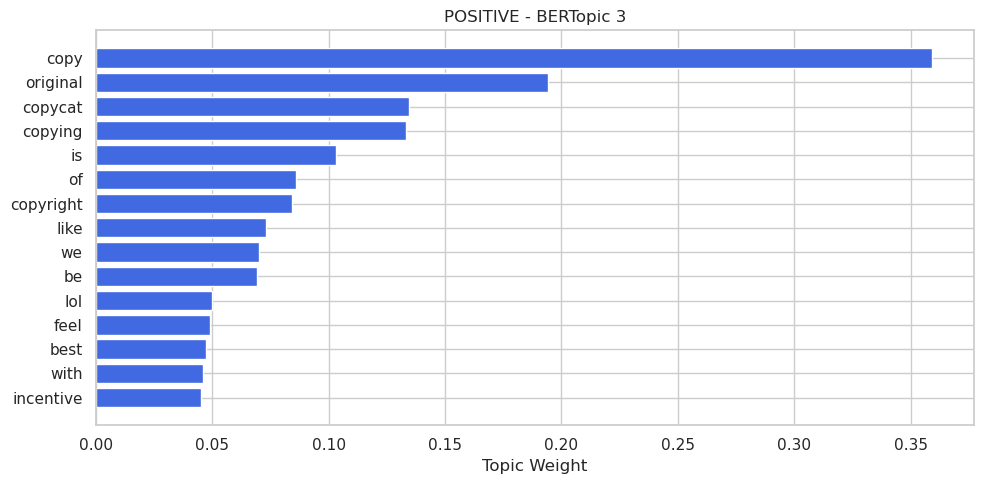


--- REPRESENTATIVE EXAMPLES (Positive) ---

Topic 0 Examples:
- I like where this is going but a lot of things need to change before I use this consistently. Please make a section that consists only of the posts by the people I’m following! I’m tired of seeing ran ...
- Super app and instagram is very very good what will be very good threads now and there is no better app than this i do it a lot thank you Instagram ❤️☄️🎶🎧💌🌍🤞🏻 ...
- It's okay ,But not good as Twitter, i definitely know that only the " Instagram" users will use this app , The twitter user were not interested to use this app , this app only get the numbers of membe ...

Topic 1 Examples:
- Good ...
- good ...
- Good ...

Topic 2 Examples:
- Very Nice App Love U Mark Zuckerberg 🖤💯 ...
- Good mark Zuckerberg we love you ...
- So good app🥰🥰🥰 Love you Mark Zuckerberg❤️❤️❤️🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰 ...

Topic 3 Examples:
- Nice copy ...
- Good copy ...
- Copy is copy anyway , original is always best ...
Positive BERTopic Coherence: 0.4

Batches: 100%|████████████████████████████████████████████████████████████████| 298/298 [00:01<00:00, 163.69it/s]



===== BERTOPIC SUMMARY (NEUTRAL) — 5 TOPICS =====
   Topic  Count                       Name  \
0     -1   3000           -1_the_to_app_it   
1      0   2513  0_twitter_to_instagram_of   
2      1   2016   1_first_review_elon_musk   
3      2   1801            2_app_the_it_to   
4      3    194   3_copy_cat_copycat_cheap   

                                      Representation  \
0  [the, to, app, it, and, is, this, twitter, of,...   
1  [twitter, to, instagram, of, the, account, and...   
2  [first, review, elon, musk, zuck, is, the, to,...   
3  [app, the, it, to, this, is, not, and, cant, w...   
4  [copy, cat, copycat, cheap, copied, app, clone...   

                                 Representative_Docs  
0  [Worst app Twitter is better than threads and ...  
1  [It’s better than twitter as of now and cooler...  
2  [im the first one to review it, The very first...  
3  [This app is crashing when I tap on the new po...  
4                                 [Copy, Copy, Copy]  


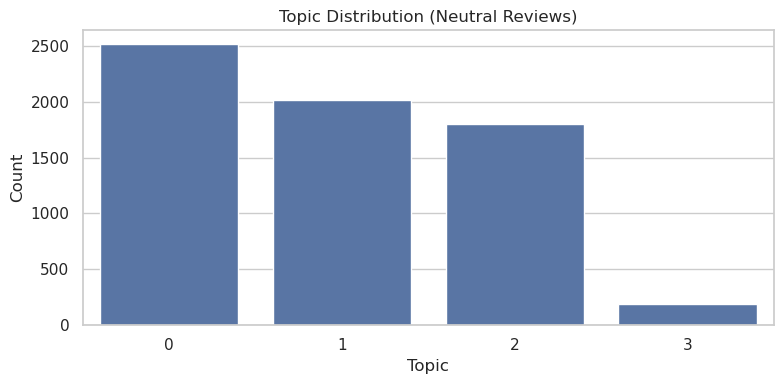

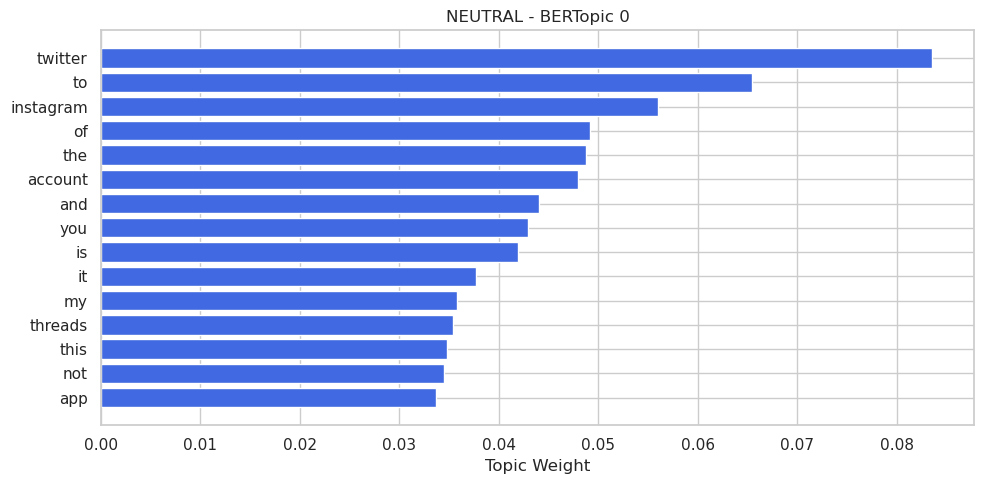

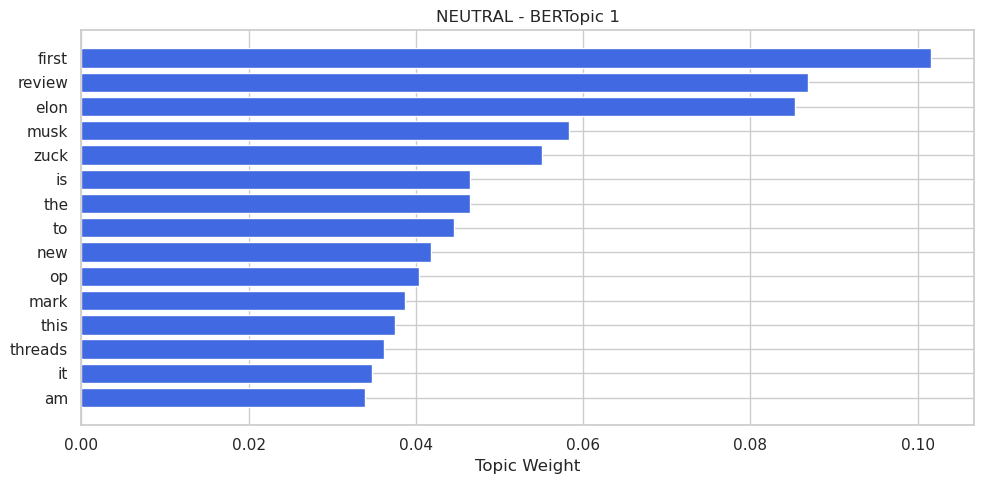

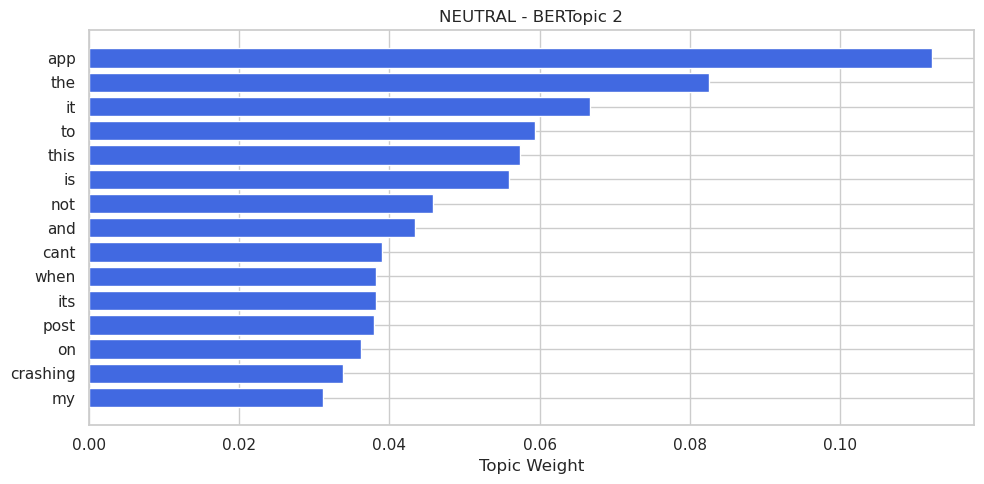

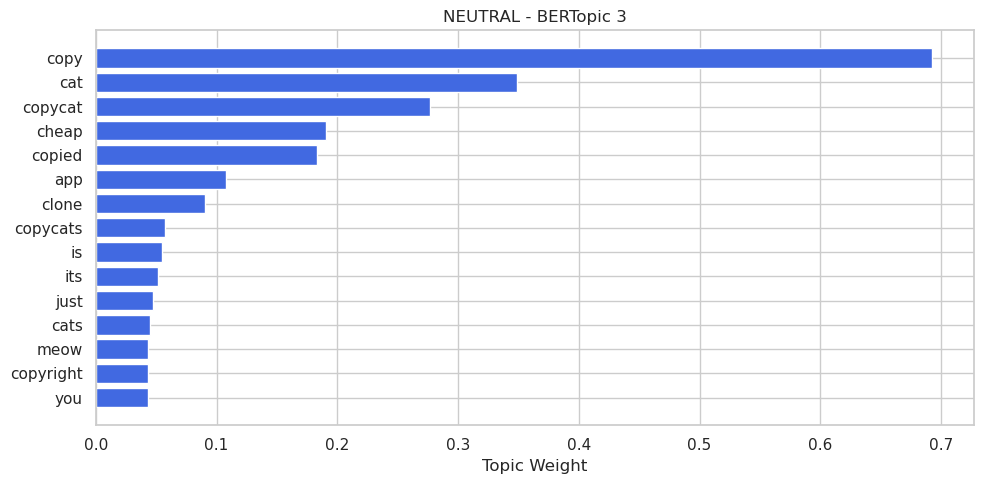


--- REPRESENTATIVE EXAMPLES (Neutral) ---

Topic 0 Examples:
- It’s better than twitter as of now and cooler especially because they won’t ban you and limit you tweet read count, also it’s an easy install and setup, it transfers everything from your instagram acc ...
- Don't use this app if you installed this app and log in with Instagram id your not delete threads account. If you delete your threads account than Instagram account also delete. ...
- The feed is nothing but suggested people and threads with maybe 1% of who you actually follow (much like Facebook but without an option for following only). Take a note from Twitter and make a Timelin ...

Topic 1 Examples:
- im the first one to review it ...
- The very first review of this app. Mark I told you I was the first to review it 😁 ...
- I’m the first review ...

Topic 2 Examples:
- This app is crashing when I tap on the new post icon. What is the point of using this app when I can not interact with others.... ...
- When i refres

Batches: 100%|████████████████████████████████████████████████████████████████| 136/136 [00:01<00:00, 133.79it/s]



===== BERTOPIC SUMMARY (NEGATIVE) — 5 TOPICS =====
   Topic  Count                   Name  \
0     -1   1171      -1_the_to_and_app   
1      0   1207        0_to_the_and_of   
2      1   1199        1_app_the_to_it   
3      2    629  2_bad_boring_not_good   
4      3    115    3_elon_musk_zuck_is   

                                      Representation  \
0  [the, to, and, app, it, is, of, this, twitter,...   
1  [to, the, and, of, is, twitter, you, it, insta...   
2  [app, the, to, it, and, is, post, crashes, my,...   
3  [bad, boring, not, good, useless, very, experi...   
4  [elon, musk, zuck, is, hai, he, bhi, ki, the, ...   

                                 Representative_Docs  
0  [Don't download this app this app is block you...  
1  [There are no settings for you to control the ...  
2  [Bad app not to try it 🤮, I just installed the...  
3  [Very bad experience 🤮🤮🤮🤮🤮🤮🤮🤮🤮🤮, ⚠️🛑⚠️Very Bad...  
4  [This is the real fight between Zuck and Elon ...  


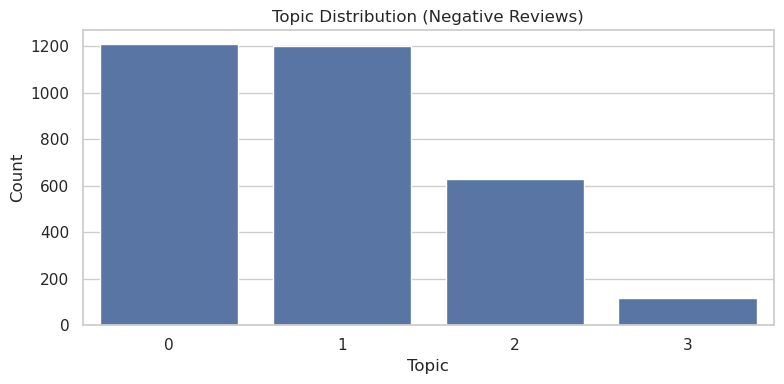

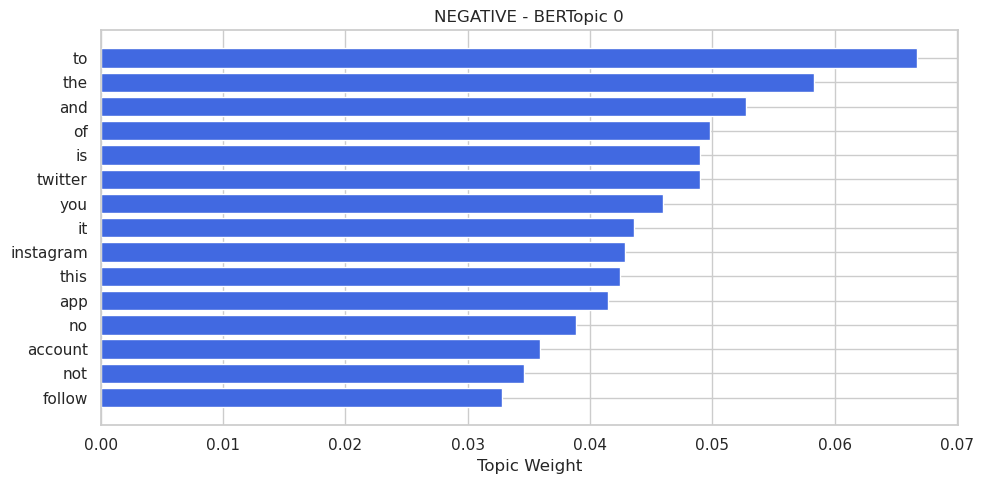

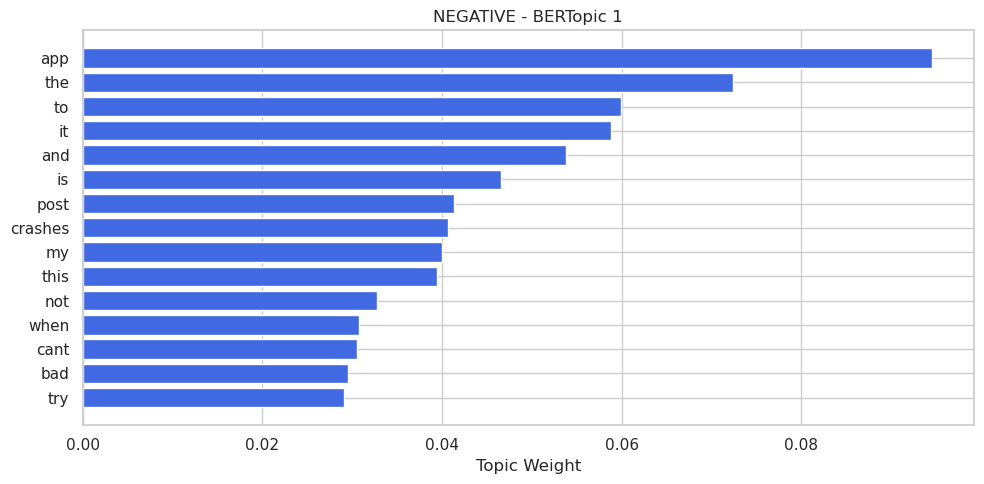

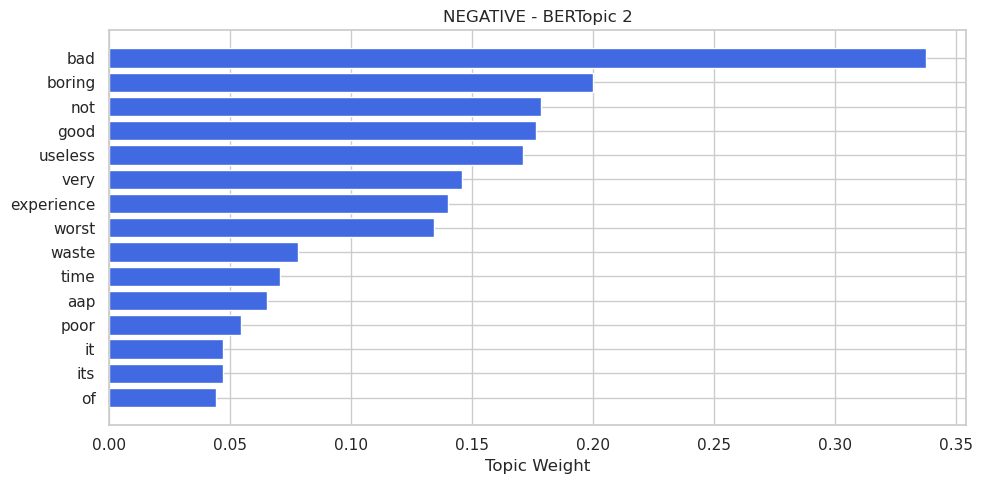

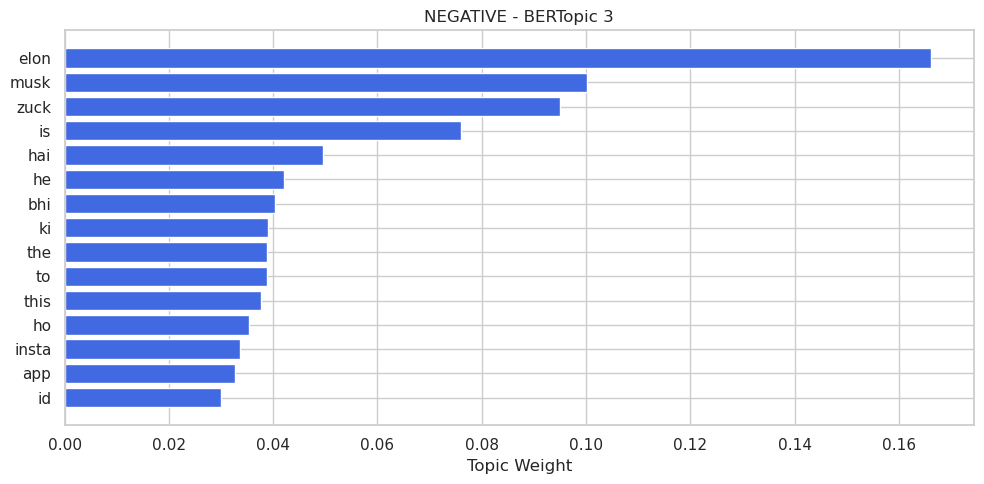


--- REPRESENTATIVE EXAMPLES (Negative) ---

Topic 0 Examples:
- There are no settings for you to control the experience. 

I made the mistake of refreshing my homepage and now I’m seeing accounts from the entire world — I can’t even find the people I follow anymor ...
- it's on a good start to be a good socmed app, i just have some problems with it: 1. there is only a for you page, you have to see what the algorithm wants you to see and there's no way to only see pos ...
- No interaction with people you follow. Period. You'll be lucky to see a post that isn't a business or verified account. No rhyme or reason to posts that the feed shows you. This is the same as the ad  ...

Topic 1 Examples:
- Bad app not to try it 🤮 ...
- I just installed the app. But when I try to open it it crashes. ...
- This app is THE WORST!!!!!!! Like seriously my gosh. I can't do anything in the app etohout it kicking me out and sending me to the home screen. I can see people’s threads, butbitbkicks me out an

In [80]:
threads_pos_model, threads_pos_topics, threads_pos_probs, threads_pos_emb, threads_pos_coh = \
    run_bertopic_pipeline(df_threads, sentiment_value="positive")

threads_neu_model, threads_neu_topics, threads_neu_probs, threads_neu_emb, threads_neu_coh = \
    run_bertopic_pipeline(df_threads, sentiment_value="neutral")

threads_neg_model, threads_neg_topics, threads_neg_probs, threads_neg_emb, threads_neg_coh = \
    run_bertopic_pipeline(df_threads, sentiment_value="negative")


### Twitter BERTopic Analysis

Batches: 100%|████████████████████████████████████████████████████████████████| 271/271 [00:01<00:00, 165.12it/s]



===== BERTOPIC SUMMARY (POSITIVE) — 5 TOPICS =====
   Topic  Count                      Name  \
0     -1   2200          -1_the_to_and_it   
1      0   2996      0_app_the_to_twitter   
2      1   2863    1_good_nice_very_great   
3      2    306     2_elon_musk_took_over   
4      3    284  3_speech_free_freedom_of   

                                      Representation  \
0  [the, to, and, it, is, twitter, app, of, this,...   
1  [app, the, to, twitter, it, and, is, this, bes...   
2  [good, nice, very, great, best, it, to, its, a...   
3  [elon, musk, took, over, since, better, to, it...   
4  [speech, free, freedom, of, the, for, to, is, ...   

                                 Representative_Docs  
0  [I dont care much for most of the content on t...  
1  [I love this app it's the best, The Twitter ap...  
2                                 [Good, Good, Good]  
3  [Elon musk is the best!!, Elon Musk is the bes...  
4            [Free speech, Free speech, Free Speech]  


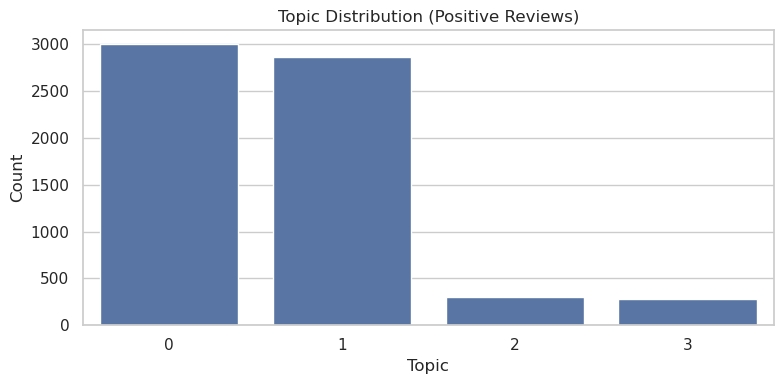

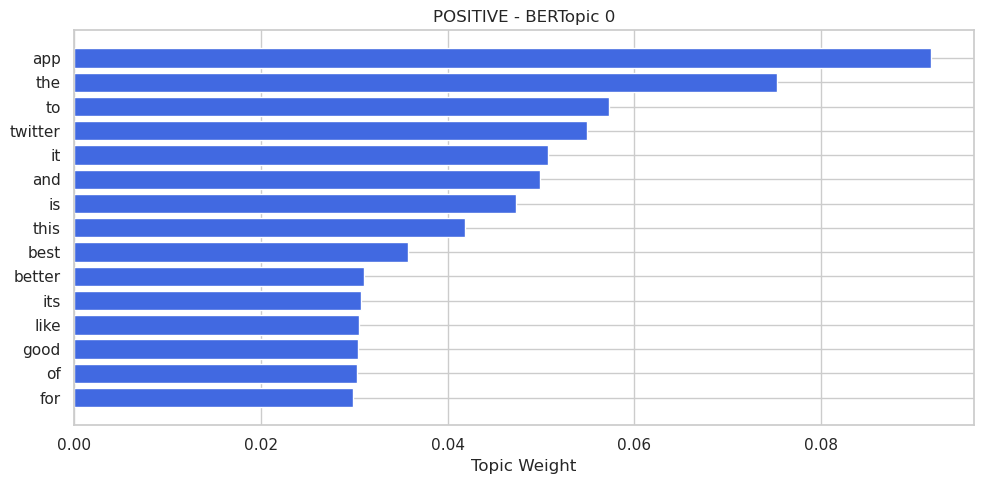

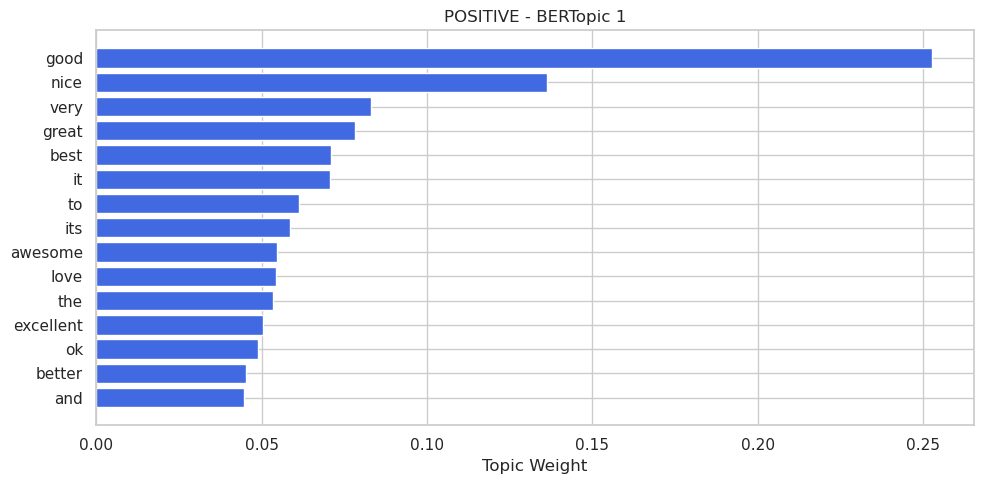

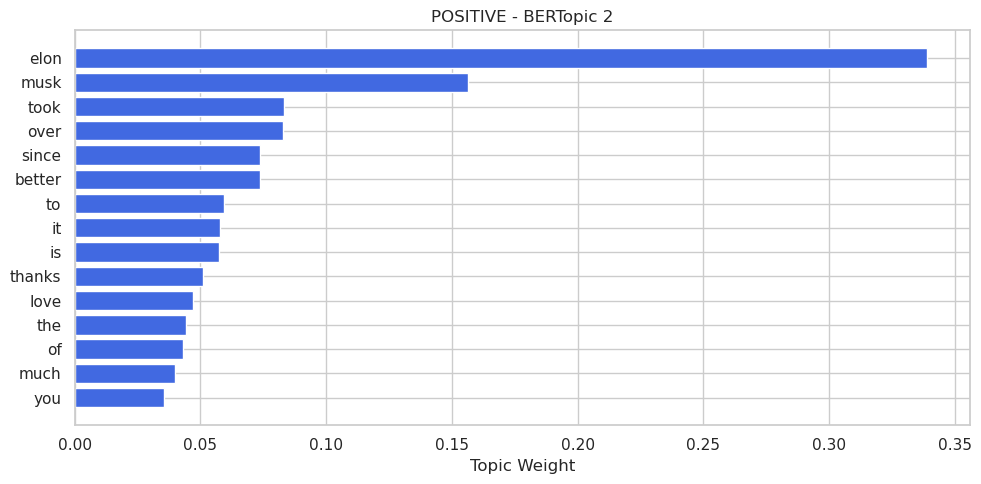

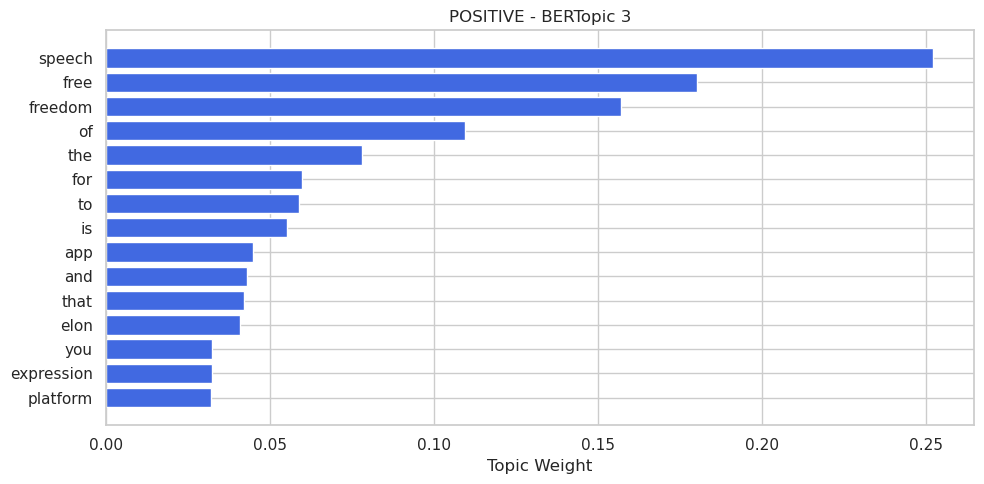


--- REPRESENTATIVE EXAMPLES (Positive) ---

Topic 0 Examples:
- I love this app it's the best ...
- The Twitter app is really nice and I love it ...
- I love this app the best App 🤩🤩🤩🤩🤩🤩 ...

Topic 1 Examples:
- Good ...
- Good ...
- Good ...

Topic 2 Examples:
- Elon musk is the best!! ...
- Elon Musk is the best 👌 ...
- Elon Musk is the best 🌠 ...

Topic 3 Examples:
- Free speech ...
- Free speech ...
- Free Speech ...
Positive BERTopic Coherence: 0.5746462154509531


Batches: 100%|████████████████████████████████████████████████████████████████| 257/257 [00:01<00:00, 168.25it/s]



===== BERTOPIC SUMMARY (NEUTRAL) — 5 TOPICS =====
   Topic  Count                     Name  \
0     -1   2451         -1_the_to_it_and   
1      0   3074     0_the_twitter_to_app   
2      1   1417         1_it_is_trash_to   
3      2   1138       2_elon_musk_it_the   
4      3    119  3_limit_rate_limits_the   

                                      Representation  \
0  [the, to, it, and, is, app, twitter, this, of,...   
1  [the, twitter, to, app, and, it, is, this, not...   
2  [it, is, trash, to, the, its, what, why, garba...   
3  [elon, musk, it, the, to, app, is, twitter, th...   
4  [limit, rate, limits, the, exceeded, posts, of...   

                                 Representative_Docs  
0  [the whole entire point of the app now is just...  
1  [Why you change the name and logo twitter?, ch...  
2  [It used to be good. But now it sucks, It's tr...  
3              [Elon Musk 🤩, Elon Musk⚡⚡, Elon musk]  
4                    [LIMIT????, LIMIT???!!!, Limit]  


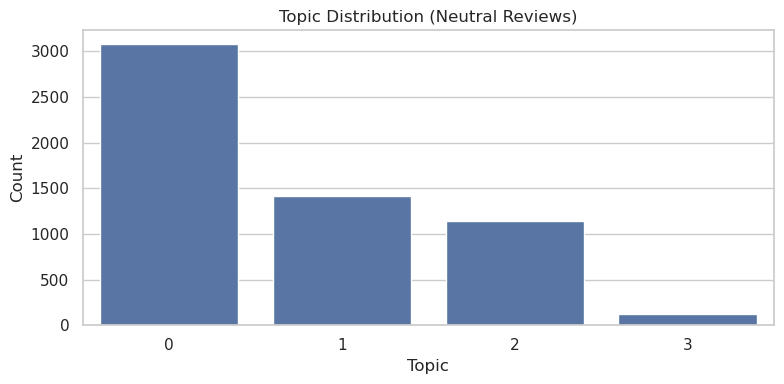

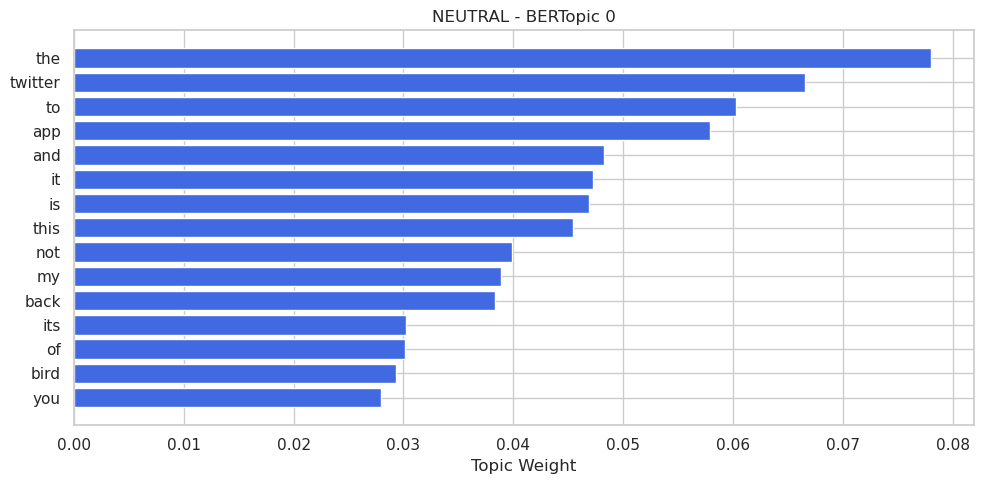

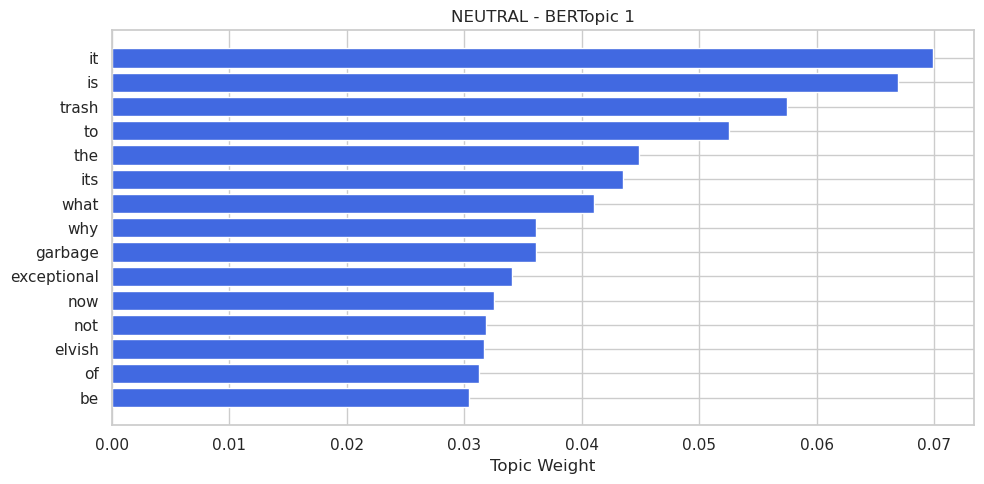

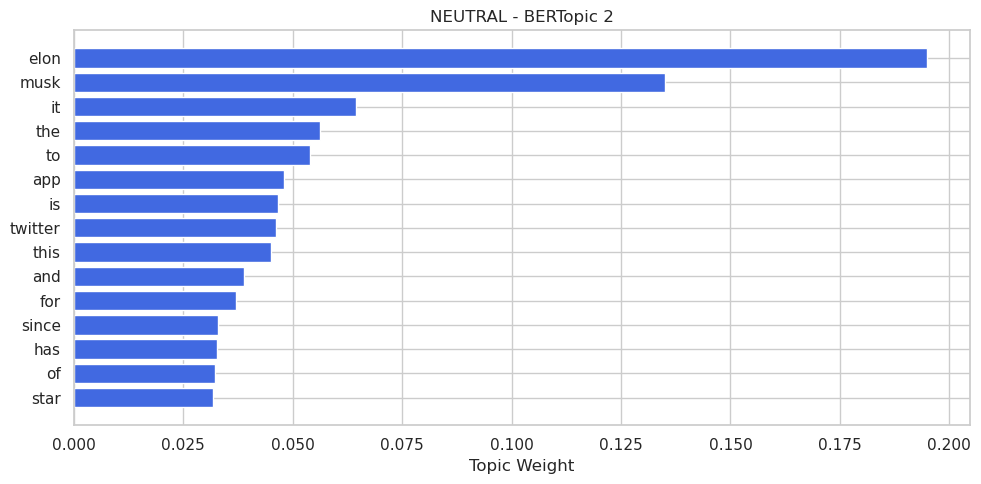

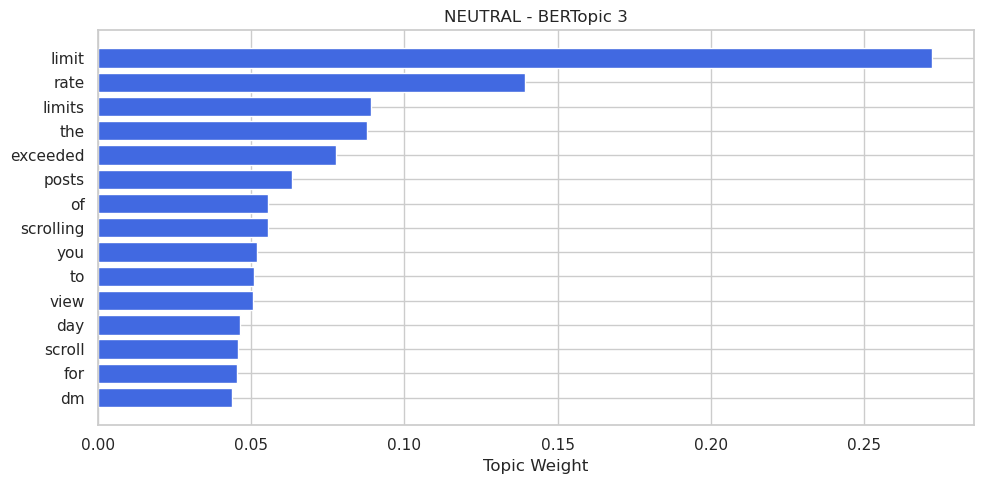


--- REPRESENTATIVE EXAMPLES (Neutral) ---

Topic 0 Examples:
- Why you change the name and logo twitter? ...
- change the name back to twitter ...
- Change the name back to twitter ...

Topic 1 Examples:
- It used to be good. But now it sucks ...
- It's trash now ...
- Not what it used to be ...

Topic 2 Examples:
- Elon Musk 🤩 ...
- Elon Musk⚡⚡ ...
- Elon musk ...

Topic 3 Examples:
- LIMIT???? ...
- LIMIT???!!! ...
- Limit ...
Neutral BERTopic Coherence: 0.5734558850710133


Batches: 100%|████████████████████████████████████████████████████████████████| 214/214 [00:01<00:00, 139.62it/s]



===== BERTOPIC SUMMARY (NEGATIVE) — 5 TOPICS =====
   Topic  Count                        Name  \
0     -1   1889           -1_the_to_and_app   
1      0   3527            0_the_to_and_app   
2      1    657  1_bad_sucks_worst_terrible   
3      2    608        2_the_bird_name_logo   
4      3    156       3_limit_rate_star_the   

                                      Representation  \
0  [the, to, and, app, is, it, this, of, twitter,...   
1  [the, to, and, app, it, is, twitter, elon, thi...   
2  [bad, sucks, worst, terrible, very, no, good, ...   
3  [the, bird, name, logo, is, and, new, back, it...   
4  [limit, rate, star, the, limits, it, is, give,...   

                                 Representative_Docs  
0  [if the rate would base on the old app it woul...  
1  [Everything went down hill since elon musk bou...  
2                                    [Bad, bad, Bad]  
3  [I HATE THE NEW LOGO AND NAME., hate the new l...  
4  [rate limit sucks., The rate limit sucks, THE ... 

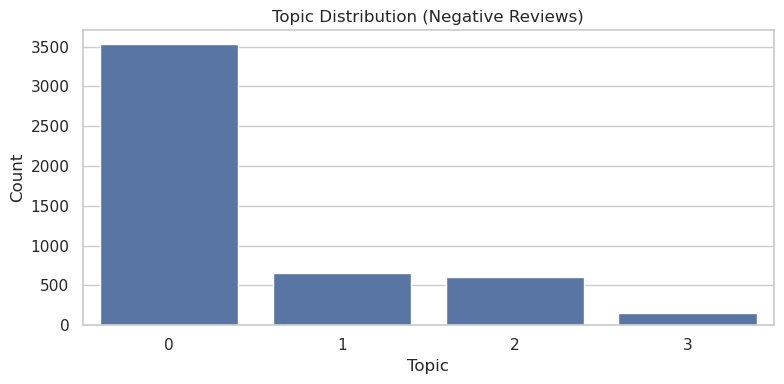

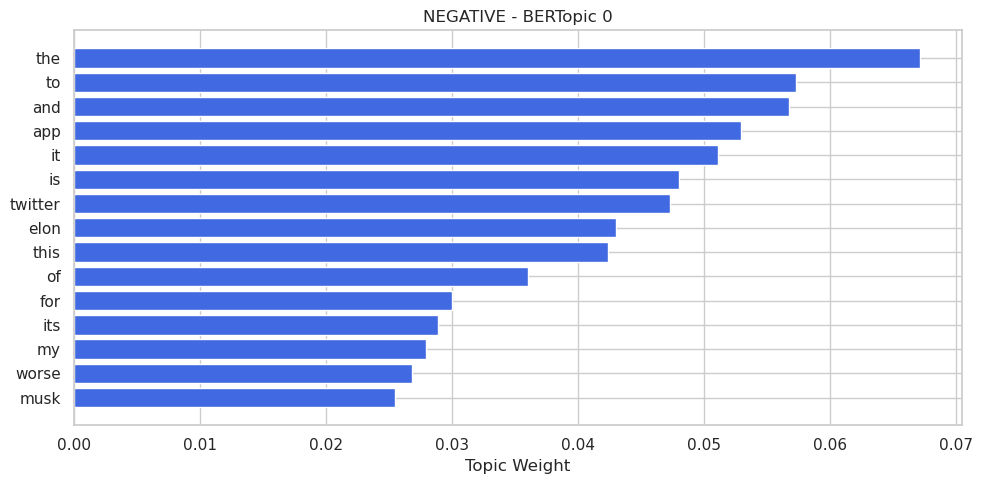

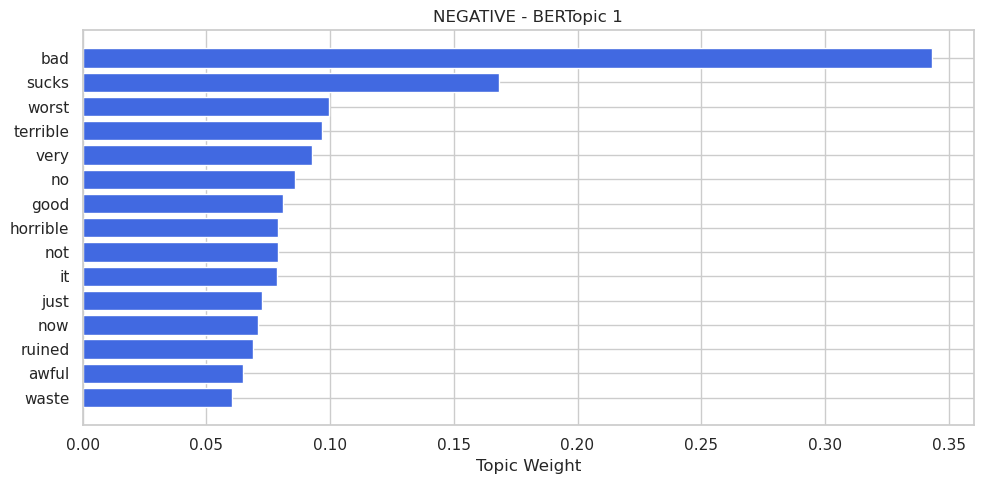

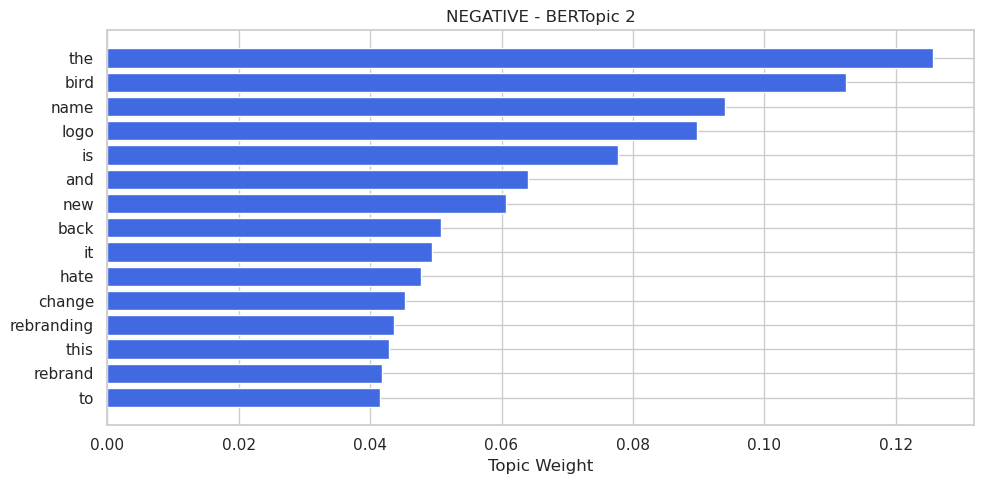

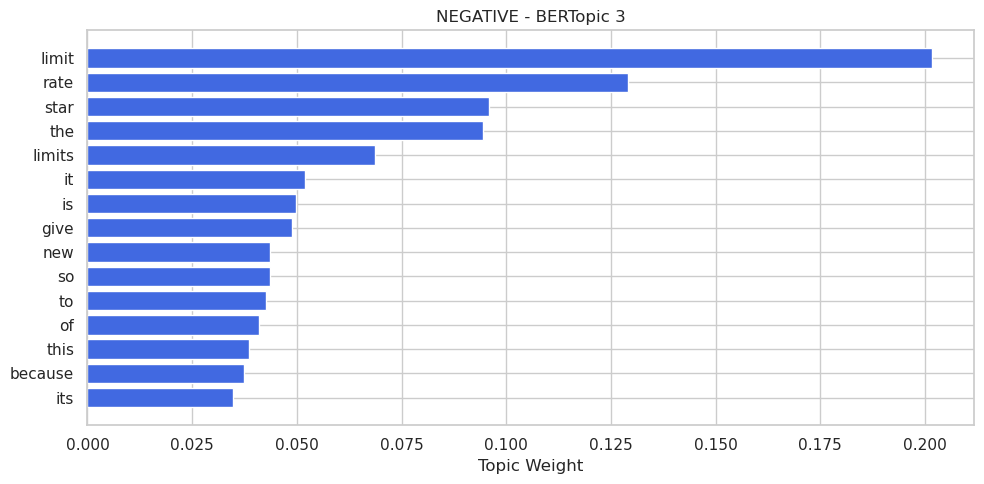


--- REPRESENTATIVE EXAMPLES (Negative) ---

Topic 0 Examples:
- Everything went down hill since elon musk bought the company. Seriously, what is this X? The logo? The new updates?Community guidelines? Absolutely horrifying, RUINED the whole app. If you want to say ...
- This app has become trash. I never write reviews, but Elon is running this app into the ground. What was the point of rebranding to X? Why did he implement a tweet-read limit that doesn't even stop bo ...
- Re-branding it as "X" is the worst thing you can do. This is supposed to be about chirping our thoughts, hence "Twitter." Not using it for $8 subscription, A.I., or cryptocurrency, or marketplace trad ...

Topic 1 Examples:
- Bad ...
- bad ...
- Bad ...

Topic 2 Examples:
- I HATE THE NEW LOGO AND NAME. ...
- hate the new logo and name ...
- new logo and new name are suck!!! change it back to twitter and the blue bird!!!!!! ...

Topic 3 Examples:
- rate limit sucks. ...
- The rate limit sucks ...
- THE RATE LIMIT SU

In [81]:
twitter_pos_model, twitter_pos_topics, twitter_pos_probs, twitter_pos_emb, twitter_pos_coh = \
    run_bertopic_pipeline(twitter_pos, sentiment_value="positive", review_col= "review_text")

twitter_neu_model, twitter_neu_topics, twitter_neu_probs, twitter_neu_emb, twitter_neu_coh = \
    run_bertopic_pipeline(twitter_neu, sentiment_value="neutral", review_col = "review_text")

twitter_neg_model, twitter_neg_topics, twitter_neg_probs, twitter_neg_emb, twitter_neg_coh = \
    run_bertopic_pipeline(twitter_neg, sentiment_value="negative",review_col="review_text")


##### BERTopic performs quite well on twitter data with coherence scores of 0.53 for positive topics, 0.57 for neutral topics and 0.54 for negative topics with an average coherence of 0.55 which is good for the data. It seems to capture the clusters quite well in neutral as well which is best among all other modelling techniques we used till now.
##### It seems to also capture the issues with X such as update issues, logo, payment and rate limit which were major issues faced by users and comparing it to twitter before it changed to X, hence being the best model among all

### Test on the best topic modelling model - BERTopic

#### BERTopic managed to perform quite well on the test set as well with a coherence scores of 0.54 for positive topics, 0.52 for neutral topics, and finally 0.57 on negative topics proving that it is a better model among all the topic models.

#### More interpretation of topics: